# Hey, Jetson!

### By Brice Walker

[View on GitHub](https://github.com/bricewalker/Hey-Jetson)

[View on nbviewer](https://nbviewer.jupyter.org/github/bricewalker/Hey-Jetson/blob/master/Speech.ipynb)

## Outline

- [Introduction](#intro)
- [Importing Libraries](#libraries)
- [Importing The Dataset](#data)
- [Acoustic Feature Extraction/Engineering for Speech Recognition](#features)
- [Visualizing The Data](#plotting)
    - [Raw Audio](#raw)
    - [Spectrograms](#spectograms)
    - [Mel-Frequency Cepstral Coefficients](#mfcc)
- [Deep Neural Networks for Acoustic Modeling](#deeplearning)
    - [RNN](#rnn)
        - [RNN + TimeDistributed Dense](#rnntd)
        - [CNN + RNN + TimeDistributed Dense](#cnnrnn)
        - [Deeper RNN + TimeDistributed Dense](#deeprnn)
        - [Bidirectional RNN + TimeDistributed Dense](#bidirectional)
        - [CNN + Deeper Bidirectional RNN + TimeDistributed Dense](#cnndeepbi)
        - [CNN + Deeper Bidirectional RNN Dropout Model](#dropout)
        - [Dilated CNN + Deeper Bidirectional RNN Model](#dilated)
    - [Final Model](#final)
- [Comparing Models](#selection)
    - [Final Model Performance](#test)
- [Exporting The Model For Inference](#export)

<a id='intro'></a>
## Introduction

This project builds a scalable speech recognition platform in Keras/Tensorflow for inference on the Nvidia Jetson Embedded Computing Platform for AI at the Edge. This is a real world application of automatic speech recognition that was inspired by my career in mental health. This project begins a journey towards building a platform for real time therapeutic intervention inference and feedback. The ultimate intent is to build a tool that can give therapists real time feedback on the efficacy of their interventions, but this has many applications in mobile, robotics, or other areas where cloud based deep learning is not desirable.

This project explores three common ways of visualizing/mathematically representing audio for use in machine learning models.
This project then walks you through the construction of a series of increasingly complex character-level phonetics sequencing models. For this project, I have chosen Recurrent Neural Networks, as they allow us to harness the power of deep neural networks for time sequencing issues and allow fast training on GPU's compared to other models. I chose character level phonetics modeling as it provides a more accurate depiction of language and would allow building a system that can pick up on the nuances of human-to-human communication in deeply personal conversations. Additionally, this notebook explores measures of model performance and makes predictions based on the trained models. Finally, I look at methods of exporting models for inference on mobile devices.

### Automatic Speech Recognition
Speech recognition models are based on a statistical optimization problem called the fundamental equation of speech recognition. Given a sequence of observations, we look for the most likely word sequence. So, using Bayes Theory, we are looking for the word sequence which maximizes the posterior probability of the word given the observation. The speech recognition problem is a search over this model for the best word sequence.

Speech recognition can be broken into two parts; the acoustic model, that describes the distribution over acoustic observations, O, given the word sequence, W; and the language model based solely on the word sequence which assigns a probability to every possible word sequence. This sequence to sequence model combines both the acoustic and language models into one neural network, though pretrained acoustic models are available from [kaldi](http://www.kaldi-asr.org/downloads/build/6/trunk/egs/) if you would like to speed up training.

### Problem Statement
My goal is to build a character-level ASR system using RNN's in tensorflow that can run inference on an Nvidia Jetson with an accuracy of >80% and latency of <200ms.

In [7]:
# Common, File Based, and Math Imports
import pandas as pd
import numpy as np
import collections
import os
from os.path import isdir, join
from pathlib import Path
from subprocess import check_output
import sys
import math
import pickle
from glob import glob
import random
from random import sample
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.lib.stride_tricks import as_strided
from tqdm import tqdm

# Audio processing
from scipy import signal
from scipy.fftpack import dct
import soundfile
import json
from python_speech_features import mfcc
import librosa
import scipy.io.wavfile as wav
from scipy.fftpack import fft
from scipy import signal

# Dimensionality Reduction
from sklearn.decomposition import PCA

# Neural Network
import keras
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras import regularizers
from keras.constraints import max_norm
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Lambda, Dense, Dropout, Flatten, Embedding, merge, Activation, GRUCell, LSTMCell,SimpleRNNCell
from keras.layers import Convolution2D, MaxPooling2D, Convolution1D, Conv1D, SimpleRNN, GRU, LSTM, CuDNNLSTM, CuDNNGRU, Conv2D
from keras.layers.advanced_activations import LeakyReLU, PReLU, ThresholdedReLU, ELU
from keras.layers import LeakyReLU, PReLU, ThresholdedReLU, ELU
from keras.layers import BatchNormalization, TimeDistributed, Bidirectional
from keras.layers import activations, Wrapper
from keras.regularizers import l2
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from keras.callbacks import ModelCheckpoint 
from keras.utils import np_utils
from keras import constraints, initializers, regularizers
from keras.engine.topology import Layer
import keras.losses
from keras.backend.tensorflow_backend import set_session
from keras.engine import InputSpec
import tensorflow as tf 
#import tensorflow.contrib.eager as tfe
from tensorflow.python.framework import graph_io
from tensorflow.python.tools import freeze_graph
from tensorflow.core.protobuf import saver_pb2
from tensorflow.python.training import saver as saver_lib

# Visualization
import IPython.display as ipd
import librosa.display
from IPython.display import Markdown, display, Audio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

color = sns.color_palette()
sns.set_style('darkgrid')
py.init_notebook_mode(connected=True)
%matplotlib inline

# Setting Random Seeds
np.random.seed(95)
RNG_SEED = 95

# Suppressing some of Tensorflow's warnings
tf.logging.set_verbosity(tf.logging.ERROR)

In [8]:
# Matrix Multiplication test to check if tf is using GPU device. If there is an output then it is able to access the device
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


<a id='data'></a>
## Importing The Dataset

The primary dataset used is the [LibriSpeech ASR corpus](http://www.openslr.org/12/) which includes 1000 hours of recorded speech. A 100 hour(6G) subset of the dataset of audio files was used for testing the models to reduce training and model building time. The final model was trained on a 360 hour (23G) subset. The dataset consists of 16kHz audio files of spoken english derived from read audiobooks from the LibriVox project. Some issues identified with this data set are the age of some of the works (the Declaration of Independence probably doesn't relate well to modern spoken english), the fact that there is much overlap in words spoken between the books, a lack of 'white noise' and other non-voice noises to help the model differentiate spoken words from background noise, and the fact that this does not include conversational english.

The dataset is prepared using a set of scripts borrowed from [Baidu Research's Deep Speech GitHub Repo](https://github.com/baidu-research/ba-dls-deepspeech).

flac_to_wav.sh converts all flac files to .wav format and create_desc_json.py will create a corpus for each data set out of the original text descriptions:

For this script to work, you will need to obtain the libav package. Use the following steps for each OS: Linux: sudo apt-get install libav-tools Mac: brew install libav Windows: Browse to the Libav website Scroll down to "Windows Nightly and Release Builds" and click on the appropriate link for your system (32-bit or 64-bit). Click nightly-gpl. Download most recent archive file. Extract the file. Move the usr directory to your C: drive. Run :

```rename C:\usr avconv```
<br>
```set PATH=C:\avconv\bin;%PATH%```

Run flac_to_wav.sh from the directory containing the dataset. This might take a while depending on your machine:

```
flac_to_wav.sh
```

Now navigate to your code repo and run create_desc_json.py, specifying the path to the dataset and the names for the corpus files:

```
python create_desc_json.py C:\Users\brice\LibriSpeech\train-clean-100\ train_corpus.json
python create_desc_json.py C:\Users\brice\LibriSpeech\dev-clean\ valid_corpus.json
python create_desc_json.py C:\Users\brice\LibriSpeech\test-clean\ test_corpus.json
```

And then for training the final model:

```
python create_desc_json.py C:\Users\brice\LibriSpeech\train-clean-360\ train_corpus.json
```

### Defining some initial functions for preparing the dataset

In [9]:
# Function for shuffling data
def shuffle_dataset(audio_paths, durations, texts):
    p = np.random.permutation(len(audio_paths))
    audio_paths = [audio_paths[i] for i in p] 
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

# Function for sorting data by duration
def sort_dataset(audio_paths, durations, texts):
    p = np.argsort(durations).tolist()
    audio_paths = [audio_paths[i] for i in p]
    durations = [durations[i] for i in p] 
    texts = [texts[i] for i in p]
    return audio_paths, durations, texts

# Mapping each character that could be spoken at each time step
char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""
# This leaves "blank" character mapped to number 28

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

# Function for converting text to an integer sequence
def text_to_int_seq(text):
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

# Function for converting an integer sequence to text
def int_seq_to_text(int_sequence):
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text
# Function for calculating feature dimensions.
def calc_feat_dim(window, max_freq):
    return int(0.001 * window * max_freq) + 1

### Defining the primary class for preparing the dataset for visualization and modeling.

This class provides options for training models on both MFCC's and Spectrograms of the data.

In [10]:
class AudioGenerator():
    def __init__(self, step=10, window=20, max_freq=8000, mfcc_dim=13,
        minibatch_size=20, desc_file=None, spectrogram=True, max_duration=10.0, 
        sort_by_duration=False):
        # Initializing variables
        self.feat_dim = calc_feat_dim(window, max_freq)
        self.mfcc_dim = mfcc_dim
        self.feats_mean = np.zeros((self.feat_dim,))
        self.feats_std = np.ones((self.feat_dim,))
        self.rng = random.Random(RNG_SEED)
        if desc_file is not None:
            self.load_metadata_from_desc_file(desc_file)
        self.step = step
        self.window = window
        self.max_freq = max_freq
        self.cur_train_index = 0
        self.cur_valid_index = 0
        self.cur_test_index = 0
        self.max_duration=max_duration
        self.minibatch_size = minibatch_size
        self.spectrogram = spectrogram
        self.sort_by_duration = sort_by_duration

    def get_batch(self, partition):
    # Obtain a batch of audio files
        if partition == 'train':
            audio_paths = self.train_audio_paths
            cur_index = self.cur_train_index
            texts = self.train_texts
        elif partition == 'valid':
            audio_paths = self.valid_audio_paths
            cur_index = self.cur_valid_index
            texts = self.valid_texts
        elif partition == 'test':
            audio_paths = self.test_audio_paths
            cur_index = self.test_valid_index
            texts = self.test_texts
        else:
            raise Exception("Invalid partition. "
                "Must be train/val")

        features = [self.normalize(self.featurize(a)) for a in 
            audio_paths[cur_index:cur_index+self.minibatch_size]]

        # Calculate size
        max_length = max([features[i].shape[0] 
            for i in range(0, self.minibatch_size)])
        max_string_length = max([len(texts[cur_index+i]) 
            for i in range(0, self.minibatch_size)])
        
        # Initialize arrays
        X_data = np.zeros([self.minibatch_size, max_length, 
            self.feat_dim*self.spectrogram + self.mfcc_dim*(not self.spectrogram)])
        labels = np.ones([self.minibatch_size, max_string_length]) * 28
        input_length = np.zeros([self.minibatch_size, 1])
        label_length = np.zeros([self.minibatch_size, 1])
        
        for i in range(0, self.minibatch_size):
            # Calculate input_length
            feat = features[i]
            input_length[i] = feat.shape[0]
            X_data[i, :feat.shape[0], :] = feat

            # Calculate label_length
            label = np.array(text_to_int_seq(texts[cur_index+i])) 
            labels[i, :len(label)] = label
            label_length[i] = len(label)

        # Output arrays
        outputs = {'ctc': np.zeros([self.minibatch_size])}
        inputs = {'the_input': X_data, 
                  'the_labels': labels, 
                  'input_length': input_length, 
                  'label_length': label_length 
                 }
        return (inputs, outputs)

    def shuffle_dataset_by_partition(self, partition):
    # Shuffle the data
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = shuffle_dataset(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = shuffle_dataset(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/val")

    def sort_dataset_by_duration(self, partition):
    # Sort the data
        if partition == 'train':
            self.train_audio_paths, self.train_durations, self.train_texts = sort_dataset(
                self.train_audio_paths, self.train_durations, self.train_texts)
        elif partition == 'valid':
            self.valid_audio_paths, self.valid_durations, self.valid_texts = sort_dataset(
                self.valid_audio_paths, self.valid_durations, self.valid_texts)
        else:
            raise Exception("Invalid partition. "
                "Must be train/val")

    def next_train(self):
    # Get a batch of training data
        while True:
            ret = self.get_batch('train')
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= len(self.train_texts) - self.minibatch_size:
                self.cur_train_index = 0
                self.shuffle_dataset_by_partition('train')
            yield ret    

    def next_valid(self):
    # Get a batch of validation data
        while True:
            ret = self.get_batch('valid')
            self.cur_valid_index += self.minibatch_size
            if self.cur_valid_index >= len(self.valid_texts) - self.minibatch_size:
                self.cur_valid_index = 0
                self.shuffle_dataset_by_partition('valid')
            yield ret

    def next_test(self):
    # Get a batch of testing data
        while True:
            ret = self.get_batch('test')
            self.cur_test_index += self.minibatch_size
            if self.cur_test_index >= len(self.test_texts) - self.minibatch_size:
                self.cur_test_index = 0
            yield ret
            
    # Load datasets
    def load_train_data(self, desc_file='train_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'train')
        self.fit_train()
        if self.sort_by_duration:
            self.sort_dataset_by_duration('train')

    def load_validation_data(self, desc_file='valid_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'validation')
        if self.sort_by_duration:
            self.sort_dataset_by_duration('valid')

    def load_test_data(self, desc_file='test_corpus.json'):
        self.load_metadata_from_desc_file(desc_file, 'test')
    
    def load_metadata_from_desc_file(self, desc_file, partition):
    # Get metadata from json corpus
        audio_paths, durations, texts = [], [], []
        with open(desc_file) as json_line_file:
            for line_num, json_line in enumerate(json_line_file):
                try:
                    spec = json.loads(json_line)
                    if float(spec['duration']) > self.max_duration:
                        continue
                    audio_paths.append(spec['key'])
                    durations.append(float(spec['duration']))
                    texts.append(spec['text'])
                except Exception as e:
                    print('Error reading line #{}: {}'
                                .format(line_num, json_line))
        if partition == 'train':
            self.train_audio_paths = audio_paths
            self.train_durations = durations
            self.train_texts = texts
        elif partition == 'validation':
            self.valid_audio_paths = audio_paths
            self.valid_durations = durations
            self.valid_texts = texts
        elif partition == 'test':
            self.test_audio_paths = audio_paths
            self.test_durations = durations
            self.test_texts = texts
        else:
            raise Exception("Invalid partition. "
             "Must be train/val/test")
            
    def fit_train(self, k_samples=100):
    # Estimate descriptive stats for training set based on sample of 100
        k_samples = min(k_samples, len(self.train_audio_paths))
        samples = self.rng.sample(self.train_audio_paths, k_samples)
        feats = [self.featurize(s) for s in samples]
        feats = np.vstack(feats)
        self.feats_mean = np.mean(feats, axis=0)
        self.feats_std = np.std(feats, axis=0)
        
    def featurize(self, audio_clip):
    # Create features from data, either spectrogram or mfcc
        if self.spectrogram:
            return spectrogram_from_file(
                audio_clip, step=self.step, window=self.window,
                max_freq=self.max_freq)
        else:
            (rate, sig) = wav.read(audio_clip)
            return mfcc(sig, rate, numcep=self.mfcc_dim)

    def normalize(self, feature, eps=1e-14):
    # Scale the data
        return (feature - self.feats_mean) / (self.feats_std + eps)

<a id='features'></a>
## Acoustic Feature Extraction/Engineering for Speech Recognition

There are 3 primary methods for extracting features for speech recognition. This includes using raw audio forms, spectrograms, and mfcc's. For this project, I will be creating a character level sequencing model. This allows me to train a model on a data set with a limited vocabulary that can generalize to more unique/rare words better. The downsides are that these models are more computationally expensive, more difficult to interpret/understand, and they are more succeptible to the problems of vanishing or exploding gradients as the sequences can be quite long.

##### The primary dataset used will not need much cleaning as it is taken from audiobooks that have been preprocessed for background noises. This will, of course, lead to reduced performance in distracting environments.

In [11]:
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
# Create a spectrogram from audio signals
    assert not np.iscomplexobj(samples), "You shall not pass in complex numbers"
    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)  
    scale = window_norm * sample_rate
    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]
    # Reshape to include the overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)
    # Window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])
    # Broadcast window, and then compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2
    # Scale 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale
    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])
    return x, freqs

def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
# Calculate log(linear spectrogram) from FFT energy
    with soundfile.SoundFile(filename) as sound_file:
        audio = sound_file.read(dtype='float32')
        sample_rate = sound_file.samplerate
        if audio.ndim >= 2:
            audio = np.mean(audio, 1)
        if max_freq is None:
            max_freq = sample_rate / 2
        if max_freq > sample_rate / 2:
            raise ValueError("max_freq can not be > than 0.5 of "
                             " sample rate")
        if step > window:
            raise ValueError("step size can not be > than window size")
        hop_length = int(0.001 * step * sample_rate)
        fft_length = int(0.001 * window * sample_rate)
        pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
        ind = np.where(freqs <= max_freq)[0][-1] + 1
    return np.transpose(np.log(pxx[:ind, :] + eps))

<a id='plotting'></a>
## Visualizing The Data

In [12]:
def vis_train_features(index):
# Function for visualizing a single audio file based on index chosen
    # Get spectrogram
    audio_gen = AudioGenerator(spectrogram=True)
    audio_gen.load_train_data()
    vis_audio_path = audio_gen.train_audio_paths[index]
    vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # Get mfcc
    audio_gen = AudioGenerator(spectrogram=False)
    audio_gen.load_train_data()
    vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
    # Obtain text label
    vis_text = audio_gen.train_texts[index]
    # Obtain raw audio
    vis_raw_audio, _ = librosa.load(vis_audio_path)
    # Print total number of training examples
    print('There are %d total training examples.' % len(audio_gen.train_audio_paths))
    # Return labels for plotting
    return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path

In [13]:
# Creating visualisations for audio file at index number 2012
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features(2012)

There are 61956 total training examples.


<a id='raw'></a>
## Raw Audio

This method uses the raw wave forms of the audio files and is a 1D vector where X = [x1, x2, x3...]

This is used by the [Pannous Sequence to Sequence](https://github.com/pannous/tensorflow-speech-recognition) models built in Caffe and TensorFlow.

In [14]:
def plot_raw_audio(vis_raw_audio):
    # Plot the raw audio signal
    fig = plt.figure(figsize=(12,3))
    ax = fig.add_subplot(111)
    steps = len(vis_raw_audio)
    ax.plot(np.linspace(1, steps, steps), vis_raw_audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

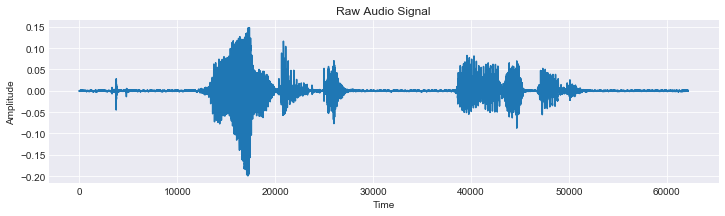

**Shape of the Audio File** : (62181,)

**Audio File Transcription** : who is that i whispered

In [15]:
# Plot the raw audio file
plot_raw_audio(vis_raw_audio)
# Printing the length of the audio file
display(Markdown('**Shape of the Audio File** : ' + str(vis_raw_audio.shape)))
# Printing the transcript corresponding to the audio file
display(Markdown('**Audio File Transcription** : ' + str(vis_text)))
# Playing the raw audio file
Audio(vis_audio_path)

<a id='spectograms'></a>
## Spectrograms

This transforms the raw audio wave forms into a 2D tensor where the first dimension corresponds to time (the horizontal axis), and the second dimension corresponds to frequency (the verticle axis) rather than amplitude. We lose a little bit of information in this conversion process as we take the log of the power of FFT. This can be written as log |FFT(X)|^2. The full transformation process is documented [here](resources/spectrograms.pdf).

Spectrograms are used in [Baidu's Deep Speech](https://github.com/baidu-research/ba-dls-deepspeech) system.

In [16]:
def plot_spectrogram_feature(vis_spectrogram_feature):
    # Plot a normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

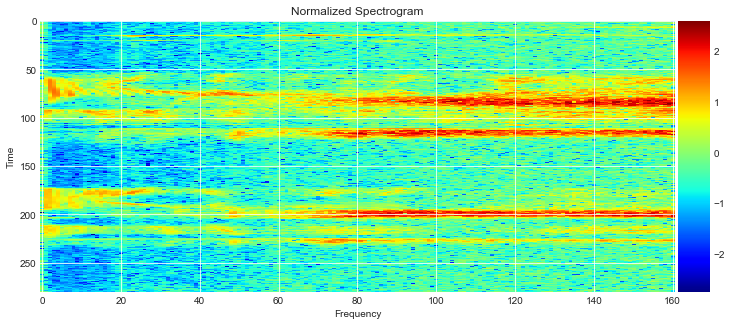

**Shape of the Spectrogram** : (281, 161)

In [17]:
# Plot the spectrogram for the selected file
plot_spectrogram_feature(vis_spectrogram_feature)
# Print shape of the spectrogram for the selected file
display(Markdown('**Shape of the Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

<a id='mfcc'></a>
## Mel-Frequency Cepstral Coefficients

Similar to the spectrogram, this turns the audio wave form into a 2D array. This works by mapping the powers of the Fourier transform of the signal, and then taking the discrete cosine transform of the logged mel powers. This produces a 2D array with reduced dimensions when compared to spectrograms, effectively allowing for compression of the spectrogram and speeding up training. The full process for deriving MFCC's from audio is outlined [here](resources/mfccs.pdf).

This is used in Mozilla's implementation of [Deep Speech](https://github.com/mozilla/DeepSpeech) in TensorFlow.

In [18]:
def plot_mfcc_feature(vis_mfcc_feature):
    # Plot a normalized MFCC feature
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()

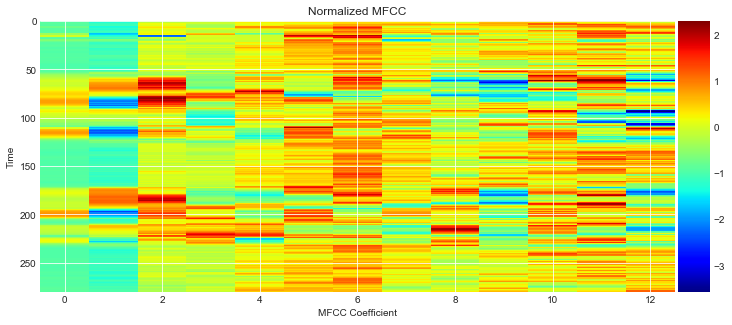

**Shape of the MFCC** : (281, 13)

In [19]:
# Plot the MFCC of the selected file
plot_mfcc_feature(vis_mfcc_feature)
# Print the shape of the MFCC of the selected file
display(Markdown('**Shape of the MFCC** : ' + str(vis_mfcc_feature.shape)))

<a id='deeplearning'></a>
## Deep Neural Networks for Acoustic Modeling

The two most common tools for automatic speech recognition are Hidden Markov Models (HMM's), and Deep Neural Networks. For this project, the architecture chosen is a (Recurrent) Deep Neural Network (RNN) as it is easy to implement, and scales well. Though the most effective and sophisticated models implement "hybrid" systems or DNN-HMM, this is beyond the scope of this project. While HMM's using weighted finite state transducers are still considered the most powerful speech recognition tools, they were ignored for this program due to their complexity and increased computing requirements. HMM's also require the development of an extensive vocabulary of phonemes and graphemes that could not be produced under the time constraints of this project.

Recurrent neurons are similar to feedforward neurons, except they also have connections pointing backward. At each step in time, each neuron recieves an input as well as its own output form the previous time step. Each neuron has two sets of weights, one for the input and one for the output at the last time step. Each layer takes vectors as inputs and outputs some vector. This model works by calculating forword propogation through each time step, t, and then back propagation through each time step. At each time step, the speaker is assumed to have spoken 1 of 29 possible characters (26 letters, 1 space character, 1 apostrophe, and 1 blank/empty character used to pad short files since inputs will have varying length). The output of this model at each time step will be a list of probabilitites for each possible character.

The RNN is comprised of an acoustic model and language model. The acoustic model scores sequences of acoustic model labels over a time frame and the language model scores sequences of words. A decoding graph then maps valid acoustic label sequences to the corresponding word sequences. Speech recognition is a path search algorithm through the decoding graph, where the score of the path is the sum of the score given to it by the decoding graph, and the score given to it by the acoustic model. So, to put it simply, speech recognition is the process of finding the word sequence that maximizes both the language and acoustic model scores.

In this notebook, I have created several end to end RNN's for ASR. I have addressed the common issues with RNN's; exploding gradients, and vanishing gradients through gradient clipping, and the use of GRU, and LSTM cells respectively.

More information on the use of deep learning in speech recongition, read [George Dahl's paper](resources/deeplearning.pdf).

In [20]:
# Custom CTC loss function (discussed below)
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def add_ctc_loss(input_to_softmax):
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model

# Functions for modifying CNN layers for sequence problems 
def conv_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
# Compute the length of conv output seq after 1D convolution across time
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid', 'causal'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif border_mode == 'causal':
        output_length = input_length
    return (output_length + stride - 1) // stride

def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
# Compute the length of cnn output seq after 1D convolution across time
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid', 'causal'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif border_mode == 'causal':
        output_length = input_length
    return (output_length + stride - 1) // stride

### Connectionist Temporal Classification

The loss function I am using is a custom implementation of Connectionist Temporal Classification (CTC), which is a special case of sequential objective functions that addresses some of the modeling burden in cross-entropy that forces the model to link every frame of input data to a label. CTC's label set includes a "blank" symbol in its alphabet so if a frame of data doesn’t contain any utterance, the CTC system can output "blank" indicating that there isn't enough information to classify an output. This also has the added benefits of allowing us to have inputs/outputs of varying length as short files can be padded with the "blank" character, and allowing us to model words using a character level classification system. This function only observes the sequence of labels along a path, ignoring the alignment of the labels to the acoustic data.

More information on CTC can be found in Alex Grave's [paper](resources/ctc.pdf).

In [21]:
def train_model(input_to_softmax, 
                pickle_path,
                save_model_path,
                train_json='train_corpus.json',
                valid_json='valid_corpus.json',
                minibatch_size=20,
                spectrogram=True,
                mfcc_dim=13,
                optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=0.5),
                epochs=30,
                verbose=1,
                sort_by_duration=False,
                max_duration=10.0):
# keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
# Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1, clipvalue=0.5)
    
    # Obtain batches of data
    audio_gen = AudioGenerator(minibatch_size=minibatch_size, 
        spectrogram=spectrogram, mfcc_dim=mfcc_dim, max_duration=max_duration,
        sort_by_duration=sort_by_duration)
    # Load the datasets
    audio_gen.load_train_data(train_json)
    audio_gen.load_validation_data(valid_json)
    # Calculate steps per epoch
    num_train_examples=len(audio_gen.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size
    # Calculate validation steps
    num_valid_samples = len(audio_gen.valid_audio_paths) 
    validation_steps = num_valid_samples//minibatch_size    
    # Add custom CTC loss function to the nn
    model = add_ctc_loss(input_to_softmax)
    # Dummy lambda function for loss since CTC loss is implemented above
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    # Make  initial results/ directory for saving model pickles
    if not os.path.exists('results'):
        os.makedirs('results')
    # Add checkpoints
    checkpointer = ModelCheckpoint(filepath='results/'+save_model_path, verbose=0)
    # Fit/train model
    hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,
        epochs=epochs, validation_data=audio_gen.next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer], verbose=verbose)
    # Save model loss
    with open('results/'+pickle_path, 'wb') as f:
        pickle.dump(hist.history, f)

In [22]:
# Creating a TensorFlow session
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1.0
set_session(tf.Session(config=config))
#tf.reset_default_graph()

<a id='rnn'></a>
## RNN

This model explores a simple RNN with 1 layer of Gated Recurrent Units, a simplified type of Long-Short Term Memory Recurrent Neuron with fewer parameters than typical LSTM's. These work via a memory update gate and provide most of the performance of traditional LSTM's at a fraction of the computing costs.

More information on the use of recurent neural networks in speech recongition, read [Alex Graves' paper](resources/rnn.pdf).

To learn more about GRU's, you can check out [this paper](resources/gru.pdf).

In [23]:
def regular_rnn_model(input_dim, output_dim=29):
    # Input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Recurrent layer
    simp_rnn = GRU(output_dim, return_sequences=True, 
                 implementation=2, name='rnn')(input_data)
    # Softmax Activation Layer
    y_pred = Activation('softmax', name='softmax')(simp_rnn)
    # Specifying the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [18]:
model_0 = regular_rnn_model(input_dim=161) # 161 for Spectrogram/13 for MFCC

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True,
           ) # True for Spectrogram/False for MFCC

Epoch 1/20
260/260 [==============================] - ETA: 8:05 - loss: 1591.22 - ETA: 5:51 - loss: 1619.84 - ETA: 4:57 - loss: 1554.18 - ETA: 4:34 - loss: 1553.93 - ETA: 4:19 - loss: 1565.11 - ETA: 4:09 - loss: 1580.34 - ETA: 4:01 - loss: 1582.91 - ETA: 3:55 - loss: 1556.73 - ETA: 3:49 - loss: 1543.09 - ETA: 3:45 - loss: 1523.38 - ETA: 3:41 - loss: 1507.29 - ETA: 3:38 - loss: 1503.94 - ETA: 3:35 - loss: 1494.28 - ETA: 3:33 - loss: 1492.75 - ETA: 3:31 - loss: 1487.43 - ETA: 3:31 - loss: 1486.13 - ETA: 3:30 - loss: 1480.48 - ETA: 3:28 - loss: 1460.82 - ETA: 3:27 - loss: 1463.97 - ETA: 3:25 - loss: 1461.54 - ETA: 3:24 - loss: 1462.08 - ETA: 3:22 - loss: 1463.69 - ETA: 3:21 - loss: 1466.96 - ETA: 3:20 - loss: 1462.78 - ETA: 3:18 - loss: 1460.66 - ETA: 3:17 - loss: 1453.63 - ETA: 3:16 - loss: 1455.62 - ETA: 3:14 - loss: 1455.84 - ETA: 3:13 - loss: 1454.56 - ETA: 3:12 - loss: 1449.18 - ETA: 3:10 - loss: 1445.61 - ETA: 3:09 - loss: 1442.47 - ETA: 3:08 - loss: 1442.35 - ETA: 3:07 - loss: 1439

260/260 [==============================] - ETA: 3:27 - loss: 1006.19 - ETA: 3:19 - loss: 939.1328 - ETA: 3:21 - loss: 961.432 - ETA: 3:19 - loss: 932.307 - ETA: 3:17 - loss: 926.680 - ETA: 3:13 - loss: 920.738 - ETA: 3:13 - loss: 921.593 - ETA: 3:13 - loss: 930.002 - ETA: 3:12 - loss: 922.891 - ETA: 3:11 - loss: 923.219 - ETA: 3:10 - loss: 925.766 - ETA: 3:09 - loss: 925.527 - ETA: 3:08 - loss: 920.496 - ETA: 3:07 - loss: 913.068 - ETA: 3:07 - loss: 917.788 - ETA: 3:06 - loss: 916.662 - ETA: 3:05 - loss: 916.505 - ETA: 3:05 - loss: 920.307 - ETA: 3:04 - loss: 922.742 - ETA: 3:03 - loss: 921.385 - ETA: 3:02 - loss: 918.387 - ETA: 3:01 - loss: 917.064 - ETA: 3:01 - loss: 915.080 - ETA: 3:00 - loss: 911.519 - ETA: 2:59 - loss: 907.459 - ETA: 2:58 - loss: 908.305 - ETA: 2:57 - loss: 911.056 - ETA: 2:56 - loss: 906.971 - ETA: 2:56 - loss: 910.030 - ETA: 2:55 - loss: 910.992 - ETA: 2:55 - loss: 908.488 - ETA: 2:54 - loss: 907.624 - ETA: 2:54 - loss: 908.040 - ETA: 2:54 - loss: 909.130 - ETA:

260/260 [==============================] - ETA: 3:15 - loss: 934.298 - ETA: 3:15 - loss: 901.139 - ETA: 3:13 - loss: 899.263 - ETA: 3:14 - loss: 918.196 - ETA: 3:14 - loss: 937.985 - ETA: 3:14 - loss: 931.792 - ETA: 3:14 - loss: 935.486 - ETA: 3:13 - loss: 936.000 - ETA: 3:11 - loss: 923.103 - ETA: 3:11 - loss: 933.454 - ETA: 3:10 - loss: 932.481 - ETA: 3:09 - loss: 934.003 - ETA: 3:08 - loss: 926.561 - ETA: 3:08 - loss: 926.228 - ETA: 3:07 - loss: 918.983 - ETA: 3:05 - loss: 911.426 - ETA: 3:05 - loss: 912.935 - ETA: 3:04 - loss: 913.930 - ETA: 3:04 - loss: 915.662 - ETA: 3:03 - loss: 912.321 - ETA: 3:02 - loss: 914.274 - ETA: 3:01 - loss: 910.400 - ETA: 2:59 - loss: 908.330 - ETA: 2:59 - loss: 911.528 - ETA: 2:58 - loss: 904.377 - ETA: 2:58 - loss: 906.568 - ETA: 2:57 - loss: 909.475 - ETA: 2:56 - loss: 908.603 - ETA: 2:56 - loss: 912.666 - ETA: 2:55 - loss: 912.865 - ETA: 2:54 - loss: 909.796 - ETA: 2:54 - loss: 913.308 - ETA: 2:53 - loss: 912.939 - ETA: 2:52 - loss: 908.096 - ETA: 

260/260 [==============================] - ETA: 3:32 - loss: 882.609 - ETA: 3:28 - loss: 880.085 - ETA: 3:27 - loss: 914.584 - ETA: 3:24 - loss: 900.253 - ETA: 3:24 - loss: 902.538 - ETA: 3:22 - loss: 887.873 - ETA: 3:22 - loss: 885.227 - ETA: 3:21 - loss: 889.746 - ETA: 3:19 - loss: 891.616 - ETA: 3:18 - loss: 893.646 - ETA: 3:17 - loss: 892.039 - ETA: 3:16 - loss: 894.750 - ETA: 3:15 - loss: 896.114 - ETA: 3:14 - loss: 901.402 - ETA: 3:13 - loss: 902.011 - ETA: 3:12 - loss: 906.251 - ETA: 3:12 - loss: 905.575 - ETA: 3:11 - loss: 908.331 - ETA: 3:10 - loss: 909.746 - ETA: 3:08 - loss: 908.321 - ETA: 3:07 - loss: 906.474 - ETA: 3:06 - loss: 910.140 - ETA: 3:05 - loss: 906.916 - ETA: 3:04 - loss: 910.215 - ETA: 3:03 - loss: 908.275 - ETA: 3:02 - loss: 906.074 - ETA: 3:02 - loss: 907.939 - ETA: 3:01 - loss: 913.788 - ETA: 3:00 - loss: 913.498 - ETA: 2:59 - loss: 912.505 - ETA: 2:58 - loss: 914.460 - ETA: 2:57 - loss: 908.480 - ETA: 2:56 - loss: 907.165 - ETA: 2:56 - loss: 907.329 - ETA: 

260/260 [==============================] - ETA: 3:23 - loss: 975.008 - ETA: 3:21 - loss: 942.697 - ETA: 3:18 - loss: 903.298 - ETA: 3:17 - loss: 912.224 - ETA: 3:17 - loss: 944.408 - ETA: 3:17 - loss: 940.267 - ETA: 3:16 - loss: 930.331 - ETA: 3:17 - loss: 943.324 - ETA: 3:17 - loss: 939.038 - ETA: 3:17 - loss: 936.342 - ETA: 3:17 - loss: 938.988 - ETA: 3:15 - loss: 930.911 - ETA: 3:14 - loss: 923.362 - ETA: 3:13 - loss: 927.449 - ETA: 3:12 - loss: 928.980 - ETA: 3:11 - loss: 927.315 - ETA: 3:10 - loss: 918.644 - ETA: 3:09 - loss: 914.850 - ETA: 3:08 - loss: 913.285 - ETA: 3:07 - loss: 914.444 - ETA: 3:06 - loss: 916.509 - ETA: 3:05 - loss: 913.139 - ETA: 3:04 - loss: 910.470 - ETA: 3:03 - loss: 909.714 - ETA: 3:03 - loss: 905.455 - ETA: 3:02 - loss: 908.258 - ETA: 3:01 - loss: 905.848 - ETA: 3:00 - loss: 909.085 - ETA: 2:59 - loss: 907.240 - ETA: 2:59 - loss: 908.273 - ETA: 2:58 - loss: 909.156 - ETA: 2:57 - loss: 913.294 - ETA: 2:56 - loss: 908.411 - ETA: 2:55 - loss: 906.670 - ETA: 

260/260 [==============================] - ETA: 3:23 - loss: 859.986 - ETA: 3:23 - loss: 911.792 - ETA: 3:20 - loss: 892.165 - ETA: 3:19 - loss: 893.955 - ETA: 3:16 - loss: 855.659 - ETA: 3:16 - loss: 883.786 - ETA: 3:15 - loss: 883.735 - ETA: 3:13 - loss: 894.353 - ETA: 3:12 - loss: 893.786 - ETA: 3:11 - loss: 872.006 - ETA: 3:09 - loss: 867.939 - ETA: 3:09 - loss: 876.726 - ETA: 3:08 - loss: 884.130 - ETA: 3:07 - loss: 883.214 - ETA: 3:07 - loss: 886.808 - ETA: 3:06 - loss: 891.809 - ETA: 3:05 - loss: 893.866 - ETA: 3:05 - loss: 894.855 - ETA: 3:04 - loss: 893.181 - ETA: 3:03 - loss: 887.603 - ETA: 3:02 - loss: 888.381 - ETA: 3:02 - loss: 891.783 - ETA: 3:01 - loss: 890.377 - ETA: 3:00 - loss: 890.348 - ETA: 3:00 - loss: 886.627 - ETA: 2:59 - loss: 888.929 - ETA: 2:58 - loss: 889.177 - ETA: 2:58 - loss: 890.915 - ETA: 2:57 - loss: 891.898 - ETA: 2:56 - loss: 895.649 - ETA: 2:55 - loss: 895.449 - ETA: 2:55 - loss: 895.718 - ETA: 2:54 - loss: 895.444 - ETA: 2:53 - loss: 896.732 - ETA: 

260/260 [==============================] - ETA: 3:20 - loss: 914.387 - ETA: 3:24 - loss: 951.471 - ETA: 3:23 - loss: 941.176 - ETA: 3:20 - loss: 916.511 - ETA: 3:21 - loss: 917.242 - ETA: 3:20 - loss: 905.935 - ETA: 3:19 - loss: 901.488 - ETA: 3:19 - loss: 923.272 - ETA: 3:18 - loss: 923.699 - ETA: 3:18 - loss: 926.326 - ETA: 3:17 - loss: 929.419 - ETA: 3:16 - loss: 922.276 - ETA: 3:14 - loss: 918.982 - ETA: 3:13 - loss: 915.001 - ETA: 3:13 - loss: 919.303 - ETA: 3:12 - loss: 914.467 - ETA: 3:11 - loss: 911.914 - ETA: 3:09 - loss: 911.497 - ETA: 3:08 - loss: 908.435 - ETA: 3:08 - loss: 903.759 - ETA: 3:06 - loss: 902.915 - ETA: 3:05 - loss: 904.849 - ETA: 3:05 - loss: 907.862 - ETA: 3:04 - loss: 904.792 - ETA: 3:03 - loss: 906.871 - ETA: 3:01 - loss: 908.744 - ETA: 3:01 - loss: 909.858 - ETA: 3:00 - loss: 907.532 - ETA: 2:59 - loss: 907.981 - ETA: 2:58 - loss: 904.549 - ETA: 2:57 - loss: 904.361 - ETA: 2:56 - loss: 907.709 - ETA: 2:55 - loss: 908.227 - ETA: 2:55 - loss: 908.007 - ETA: 

260/260 [==============================] - ETA: 3:09 - loss: 777.086 - ETA: 3:14 - loss: 913.415 - ETA: 3:13 - loss: 880.013 - ETA: 3:15 - loss: 877.695 - ETA: 3:16 - loss: 873.575 - ETA: 3:15 - loss: 868.627 - ETA: 3:14 - loss: 866.455 - ETA: 3:14 - loss: 880.585 - ETA: 3:12 - loss: 868.072 - ETA: 3:11 - loss: 865.576 - ETA: 3:10 - loss: 868.126 - ETA: 3:08 - loss: 865.423 - ETA: 3:08 - loss: 879.995 - ETA: 3:08 - loss: 880.575 - ETA: 3:07 - loss: 880.798 - ETA: 3:06 - loss: 881.723 - ETA: 3:06 - loss: 885.934 - ETA: 3:05 - loss: 883.562 - ETA: 3:04 - loss: 882.645 - ETA: 3:03 - loss: 882.397 - ETA: 3:02 - loss: 881.615 - ETA: 3:01 - loss: 884.056 - ETA: 3:01 - loss: 883.791 - ETA: 3:01 - loss: 881.470 - ETA: 3:00 - loss: 881.890 - ETA: 2:59 - loss: 884.813 - ETA: 2:59 - loss: 890.253 - ETA: 2:59 - loss: 891.872 - ETA: 2:58 - loss: 893.183 - ETA: 2:57 - loss: 893.349 - ETA: 2:57 - loss: 896.093 - ETA: 2:56 - loss: 893.596 - ETA: 2:55 - loss: 895.681 - ETA: 2:54 - loss: 894.060 - ETA: 

260/260 [==============================] - ETA: 3:19 - loss: 831.631 - ETA: 3:15 - loss: 875.643 - ETA: 3:15 - loss: 900.146 - ETA: 3:10 - loss: 882.443 - ETA: 3:10 - loss: 876.321 - ETA: 3:10 - loss: 860.988 - ETA: 3:10 - loss: 869.113 - ETA: 3:10 - loss: 892.347 - ETA: 3:09 - loss: 903.490 - ETA: 3:09 - loss: 896.043 - ETA: 3:09 - loss: 901.669 - ETA: 3:06 - loss: 887.792 - ETA: 3:05 - loss: 886.042 - ETA: 3:05 - loss: 902.688 - ETA: 3:04 - loss: 903.921 - ETA: 3:04 - loss: 906.325 - ETA: 3:03 - loss: 907.967 - ETA: 3:02 - loss: 909.587 - ETA: 3:02 - loss: 913.006 - ETA: 3:01 - loss: 910.655 - ETA: 3:00 - loss: 909.713 - ETA: 3:00 - loss: 912.884 - ETA: 2:59 - loss: 914.546 - ETA: 2:58 - loss: 912.271 - ETA: 2:58 - loss: 914.906 - ETA: 2:57 - loss: 913.489 - ETA: 2:57 - loss: 908.942 - ETA: 2:55 - loss: 902.237 - ETA: 2:54 - loss: 903.606 - ETA: 2:54 - loss: 902.968 - ETA: 2:53 - loss: 898.871 - ETA: 2:52 - loss: 899.356 - ETA: 2:51 - loss: 897.450 - ETA: 2:50 - loss: 898.890 - ETA: 

260/260 [==============================] - ETA: 3:21 - loss: 852.578 - ETA: 3:26 - loss: 917.221 - ETA: 3:28 - loss: 902.938 - ETA: 3:26 - loss: 888.261 - ETA: 3:25 - loss: 907.964 - ETA: 3:22 - loss: 892.147 - ETA: 3:22 - loss: 895.291 - ETA: 3:19 - loss: 882.912 - ETA: 3:20 - loss: 888.670 - ETA: 3:19 - loss: 895.183 - ETA: 3:17 - loss: 900.974 - ETA: 3:16 - loss: 898.771 - ETA: 3:15 - loss: 903.571 - ETA: 3:14 - loss: 908.139 - ETA: 3:13 - loss: 908.650 - ETA: 3:11 - loss: 907.351 - ETA: 3:11 - loss: 913.753 - ETA: 3:10 - loss: 913.238 - ETA: 3:09 - loss: 912.556 - ETA: 3:08 - loss: 910.201 - ETA: 3:07 - loss: 916.263 - ETA: 3:06 - loss: 916.011 - ETA: 3:05 - loss: 915.220 - ETA: 3:04 - loss: 909.681 - ETA: 3:03 - loss: 905.729 - ETA: 3:02 - loss: 909.254 - ETA: 3:01 - loss: 908.723 - ETA: 3:00 - loss: 906.452 - ETA: 3:00 - loss: 909.350 - ETA: 2:59 - loss: 905.433 - ETA: 2:58 - loss: 906.904 - ETA: 2:57 - loss: 906.085 - ETA: 2:56 - loss: 906.477 - ETA: 2:55 - loss: 903.162 - ETA: 

This model came a long ways, but still has a long ways to go. Its performance is alright, but let's see if we can improve it with a more complex model.

<a id='rnntd'></a>
## RNN + TimeDistributed Dense

This model explores the addition of layers of normal Dense neurons to every temporal slice of an input. This model also uses batch normalization, which normalizes the activations of the layers with a mean close to 0 and standard deviation close to 1.

This model uses LSTM's. These cells include forget and output gates, which allow more control over the cell's memory by allowing separate control of what is forgotten and what is passed through to the next hidden layer of cells. This will also make it easier to implement 'peepholes' later, which allow the cell to look at both the previous output state and hidden state when making this determination.

More information on the use of LSTM's in speech recongition, read [this paper](resources/lstm.pdf) from Google and for more info on TimeDistributed Layers, check out the [Keras Documentation](https://keras.io/layers/wrappers/).

In [20]:
def rnn_tdd_model(input_dim, units, activation, output_dim=29):
    # Input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Recurrent layer
    simp_rnn = LSTM(units, activation=activation,
        return_sequences=True, implementation=2, name='rnn')(input_data)
    bn_rnn = BatchNormalization()(simp_rnn)
    # TimeDistributed Dense layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specifying the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [21]:
model_1 = rnn_tdd_model(input_dim=161, # 161 for Spectrogram/13 for MFCC
                            units=200,
                            activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (LSTM)                   (None, None, 200)         289600    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 296,229
Trainable params: 295,829
Non-trainable params: 400
_________________________________________________________________
None


In [22]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True) # True for Spectrogram/False for MFCC

Epoch 1/20
260/260 [==============================] - ETA: 9:09 - loss: 1340.52 - ETA: 6:19 - loss: 1553.10 - ETA: 5:18 - loss: 1539.38 - ETA: 4:51 - loss: 1565.97 - ETA: 4:32 - loss: 1586.17 - ETA: 4:19 - loss: 1598.87 - ETA: 4:10 - loss: 1595.14 - ETA: 4:02 - loss: 1558.18 - ETA: 3:57 - loss: 1531.99 - ETA: 3:51 - loss: 1493.98 - ETA: 3:47 - loss: 1457.73 - ETA: 3:43 - loss: 1425.39 - ETA: 3:40 - loss: 1382.66 - ETA: 3:37 - loss: 1341.82 - ETA: 3:34 - loss: 1295.03 - ETA: 3:32 - loss: 1248.42 - ETA: 3:30 - loss: 1199.66 - ETA: 3:27 - loss: 1148.33 - ETA: 3:25 - loss: 1103.98 - ETA: 3:24 - loss: 1062.20 - ETA: 3:23 - loss: 1021.12 - ETA: 3:22 - loss: 984.2471 - ETA: 3:21 - loss: 957.250 - ETA: 3:19 - loss: 929.895 - ETA: 3:18 - loss: 905.591 - ETA: 3:16 - loss: 881.898 - ETA: 3:15 - loss: 862.180 - ETA: 3:14 - loss: 844.670 - ETA: 3:13 - loss: 828.476 - ETA: 3:11 - loss: 810.625 - ETA: 3:10 - loss: 793.798 - ETA: 3:09 - loss: 776.216 - ETA: 3:08 - loss: 762.997 - ETA: 3:07 - loss: 748

260/260 [==============================] - ETA: 3:14 - loss: 224.032 - ETA: 3:20 - loss: 237.907 - ETA: 3:20 - loss: 259.410 - ETA: 3:20 - loss: 256.198 - ETA: 3:21 - loss: 265.198 - ETA: 3:20 - loss: 263.691 - ETA: 3:20 - loss: 267.521 - ETA: 3:19 - loss: 267.183 - ETA: 3:18 - loss: 268.699 - ETA: 3:17 - loss: 265.519 - ETA: 3:16 - loss: 266.836 - ETA: 3:15 - loss: 265.047 - ETA: 3:14 - loss: 263.266 - ETA: 3:13 - loss: 262.134 - ETA: 3:11 - loss: 261.447 - ETA: 3:10 - loss: 261.889 - ETA: 3:10 - loss: 264.461 - ETA: 3:08 - loss: 263.281 - ETA: 3:07 - loss: 263.521 - ETA: 3:07 - loss: 266.091 - ETA: 3:07 - loss: 266.941 - ETA: 3:07 - loss: 267.385 - ETA: 3:06 - loss: 268.525 - ETA: 3:06 - loss: 269.289 - ETA: 3:05 - loss: 269.209 - ETA: 3:05 - loss: 270.130 - ETA: 3:03 - loss: 268.758 - ETA: 3:02 - loss: 268.398 - ETA: 3:01 - loss: 267.322 - ETA: 3:01 - loss: 267.903 - ETA: 3:00 - loss: 268.912 - ETA: 2:59 - loss: 268.918 - ETA: 2:58 - loss: 269.175 - ETA: 2:57 - loss: 269.358 - ETA: 

260/260 [==============================] - ETA: 3:18 - loss: 263.110 - ETA: 3:20 - loss: 269.534 - ETA: 3:20 - loss: 271.920 - ETA: 3:19 - loss: 280.594 - ETA: 3:19 - loss: 281.879 - ETA: 3:18 - loss: 279.282 - ETA: 3:18 - loss: 275.143 - ETA: 3:17 - loss: 271.821 - ETA: 3:16 - loss: 271.738 - ETA: 3:15 - loss: 273.929 - ETA: 3:15 - loss: 273.423 - ETA: 3:14 - loss: 273.914 - ETA: 3:13 - loss: 273.091 - ETA: 3:12 - loss: 271.119 - ETA: 3:12 - loss: 271.176 - ETA: 3:11 - loss: 269.974 - ETA: 3:10 - loss: 269.828 - ETA: 3:09 - loss: 269.830 - ETA: 3:08 - loss: 268.980 - ETA: 3:08 - loss: 269.020 - ETA: 3:06 - loss: 267.279 - ETA: 3:06 - loss: 268.183 - ETA: 3:05 - loss: 267.119 - ETA: 3:04 - loss: 267.954 - ETA: 3:03 - loss: 266.174 - ETA: 3:02 - loss: 264.820 - ETA: 3:01 - loss: 263.771 - ETA: 3:00 - loss: 264.175 - ETA: 2:59 - loss: 265.242 - ETA: 2:59 - loss: 265.422 - ETA: 2:58 - loss: 264.336 - ETA: 2:57 - loss: 265.537 - ETA: 2:56 - loss: 264.413 - ETA: 2:56 - loss: 263.981 - ETA: 

260/260 [==============================] - ETA: 3:14 - loss: 262.453 - ETA: 3:21 - loss: 284.479 - ETA: 3:21 - loss: 275.170 - ETA: 3:22 - loss: 278.389 - ETA: 3:22 - loss: 279.161 - ETA: 3:20 - loss: 276.653 - ETA: 3:19 - loss: 274.806 - ETA: 3:18 - loss: 272.977 - ETA: 3:16 - loss: 268.414 - ETA: 3:16 - loss: 266.841 - ETA: 3:15 - loss: 265.274 - ETA: 3:14 - loss: 261.961 - ETA: 3:14 - loss: 262.864 - ETA: 3:13 - loss: 265.765 - ETA: 3:12 - loss: 266.616 - ETA: 3:11 - loss: 263.194 - ETA: 3:10 - loss: 263.883 - ETA: 3:10 - loss: 265.281 - ETA: 3:09 - loss: 266.868 - ETA: 3:09 - loss: 266.822 - ETA: 3:06 - loss: 264.413 - ETA: 3:05 - loss: 262.562 - ETA: 3:05 - loss: 262.943 - ETA: 3:04 - loss: 263.481 - ETA: 3:03 - loss: 264.308 - ETA: 3:03 - loss: 265.787 - ETA: 3:02 - loss: 264.990 - ETA: 3:01 - loss: 266.980 - ETA: 3:01 - loss: 268.349 - ETA: 3:00 - loss: 268.860 - ETA: 2:59 - loss: 268.531 - ETA: 2:59 - loss: 268.611 - ETA: 2:58 - loss: 267.822 - ETA: 2:57 - loss: 267.872 - ETA: 

260/260 [==============================] - ETA: 3:22 - loss: 237.914 - ETA: 3:16 - loss: 237.344 - ETA: 3:23 - loss: 245.859 - ETA: 3:23 - loss: 254.473 - ETA: 3:22 - loss: 262.623 - ETA: 3:21 - loss: 262.843 - ETA: 3:18 - loss: 261.896 - ETA: 3:17 - loss: 261.959 - ETA: 3:19 - loss: 263.972 - ETA: 3:19 - loss: 267.450 - ETA: 3:20 - loss: 269.028 - ETA: 3:18 - loss: 265.296 - ETA: 3:18 - loss: 267.532 - ETA: 3:17 - loss: 268.348 - ETA: 3:16 - loss: 266.903 - ETA: 3:15 - loss: 268.267 - ETA: 3:14 - loss: 268.665 - ETA: 3:12 - loss: 267.765 - ETA: 3:11 - loss: 267.562 - ETA: 3:10 - loss: 267.508 - ETA: 3:09 - loss: 265.426 - ETA: 3:08 - loss: 265.107 - ETA: 3:06 - loss: 263.664 - ETA: 3:06 - loss: 265.188 - ETA: 3:05 - loss: 264.062 - ETA: 3:05 - loss: 265.314 - ETA: 3:04 - loss: 264.117 - ETA: 3:03 - loss: 263.323 - ETA: 3:02 - loss: 263.039 - ETA: 3:01 - loss: 262.920 - ETA: 3:00 - loss: 263.399 - ETA: 2:59 - loss: 263.601 - ETA: 2:58 - loss: 264.242 - ETA: 2:57 - loss: 264.098 - ETA: 

260/260 [==============================] - ETA: 2:59 - loss: 220.929 - ETA: 2:59 - loss: 246.928 - ETA: 3:03 - loss: 250.418 - ETA: 3:01 - loss: 256.713 - ETA: 3:02 - loss: 256.788 - ETA: 3:00 - loss: 254.164 - ETA: 2:59 - loss: 256.676 - ETA: 3:00 - loss: 253.826 - ETA: 3:00 - loss: 257.033 - ETA: 3:00 - loss: 261.246 - ETA: 3:00 - loss: 265.170 - ETA: 2:59 - loss: 266.386 - ETA: 2:59 - loss: 262.444 - ETA: 2:59 - loss: 262.630 - ETA: 2:59 - loss: 264.837 - ETA: 2:58 - loss: 261.254 - ETA: 2:57 - loss: 260.456 - ETA: 2:57 - loss: 260.580 - ETA: 2:56 - loss: 260.530 - ETA: 2:55 - loss: 260.546 - ETA: 2:55 - loss: 259.992 - ETA: 2:54 - loss: 259.026 - ETA: 2:53 - loss: 257.996 - ETA: 2:52 - loss: 257.995 - ETA: 2:52 - loss: 257.186 - ETA: 2:51 - loss: 258.000 - ETA: 2:50 - loss: 258.917 - ETA: 2:49 - loss: 258.084 - ETA: 2:48 - loss: 258.514 - ETA: 2:48 - loss: 259.554 - ETA: 2:47 - loss: 260.866 - ETA: 2:47 - loss: 261.540 - ETA: 2:46 - loss: 262.187 - ETA: 2:46 - loss: 261.279 - ETA: 

260/260 [==============================] - ETA: 3:12 - loss: 271.829 - ETA: 3:17 - loss: 286.209 - ETA: 3:12 - loss: 274.105 - ETA: 3:11 - loss: 273.641 - ETA: 3:11 - loss: 276.078 - ETA: 3:09 - loss: 273.968 - ETA: 3:07 - loss: 275.651 - ETA: 3:05 - loss: 276.464 - ETA: 3:05 - loss: 282.076 - ETA: 3:01 - loss: 275.458 - ETA: 3:00 - loss: 274.475 - ETA: 2:58 - loss: 274.278 - ETA: 2:58 - loss: 274.846 - ETA: 2:58 - loss: 277.579 - ETA: 2:59 - loss: 276.747 - ETA: 2:58 - loss: 276.462 - ETA: 2:57 - loss: 276.095 - ETA: 2:56 - loss: 275.310 - ETA: 2:56 - loss: 274.823 - ETA: 2:56 - loss: 274.748 - ETA: 2:55 - loss: 272.113 - ETA: 2:55 - loss: 273.047 - ETA: 2:54 - loss: 272.027 - ETA: 2:54 - loss: 271.765 - ETA: 2:54 - loss: 271.412 - ETA: 2:53 - loss: 272.580 - ETA: 2:52 - loss: 272.026 - ETA: 2:51 - loss: 271.270 - ETA: 2:50 - loss: 270.196 - ETA: 2:50 - loss: 269.173 - ETA: 2:48 - loss: 268.812 - ETA: 2:48 - loss: 269.332 - ETA: 2:47 - loss: 270.003 - ETA: 2:47 - loss: 269.552 - ETA: 

260/260 [==============================] - ETA: 3:18 - loss: 276.543 - ETA: 3:16 - loss: 272.028 - ETA: 3:13 - loss: 278.263 - ETA: 3:10 - loss: 273.160 - ETA: 3:10 - loss: 275.901 - ETA: 3:08 - loss: 271.326 - ETA: 3:07 - loss: 274.362 - ETA: 3:07 - loss: 274.599 - ETA: 3:06 - loss: 272.471 - ETA: 3:05 - loss: 269.629 - ETA: 3:05 - loss: 269.304 - ETA: 3:04 - loss: 266.518 - ETA: 3:03 - loss: 267.042 - ETA: 3:01 - loss: 265.490 - ETA: 3:00 - loss: 266.943 - ETA: 2:59 - loss: 267.765 - ETA: 2:59 - loss: 269.347 - ETA: 2:57 - loss: 269.178 - ETA: 2:57 - loss: 270.529 - ETA: 2:56 - loss: 271.317 - ETA: 2:55 - loss: 271.347 - ETA: 2:54 - loss: 270.648 - ETA: 2:53 - loss: 270.245 - ETA: 2:52 - loss: 270.259 - ETA: 2:52 - loss: 270.602 - ETA: 2:51 - loss: 269.021 - ETA: 2:50 - loss: 268.414 - ETA: 2:50 - loss: 267.767 - ETA: 2:49 - loss: 266.938 - ETA: 2:49 - loss: 265.866 - ETA: 2:49 - loss: 267.473 - ETA: 2:48 - loss: 269.199 - ETA: 2:47 - loss: 269.222 - ETA: 2:46 - loss: 269.000 - ETA: 

260/260 [==============================] - ETA: 3:07 - loss: 266.581 - ETA: 3:09 - loss: 270.034 - ETA: 3:11 - loss: 274.612 - ETA: 3:08 - loss: 271.197 - ETA: 3:06 - loss: 263.381 - ETA: 3:06 - loss: 270.457 - ETA: 3:06 - loss: 269.237 - ETA: 3:04 - loss: 264.796 - ETA: 3:04 - loss: 265.536 - ETA: 3:03 - loss: 260.445 - ETA: 2:59 - loss: 255.419 - ETA: 2:59 - loss: 255.195 - ETA: 2:57 - loss: 254.859 - ETA: 2:57 - loss: 257.850 - ETA: 2:58 - loss: 259.666 - ETA: 2:57 - loss: 260.174 - ETA: 2:56 - loss: 261.283 - ETA: 2:55 - loss: 258.943 - ETA: 2:55 - loss: 260.627 - ETA: 2:54 - loss: 260.710 - ETA: 2:54 - loss: 261.472 - ETA: 2:53 - loss: 261.194 - ETA: 2:53 - loss: 262.788 - ETA: 2:53 - loss: 262.918 - ETA: 2:52 - loss: 264.058 - ETA: 2:51 - loss: 263.909 - ETA: 2:51 - loss: 265.540 - ETA: 2:50 - loss: 265.031 - ETA: 2:50 - loss: 264.566 - ETA: 2:48 - loss: 263.219 - ETA: 2:48 - loss: 263.252 - ETA: 2:47 - loss: 263.437 - ETA: 2:46 - loss: 263.155 - ETA: 2:45 - loss: 262.321 - ETA: 

260/260 [==============================] - ETA: 3:13 - loss: 230.315 - ETA: 3:15 - loss: 234.877 - ETA: 3:17 - loss: 237.819 - ETA: 3:16 - loss: 243.779 - ETA: 3:12 - loss: 239.747 - ETA: 3:12 - loss: 237.371 - ETA: 3:11 - loss: 240.407 - ETA: 3:10 - loss: 245.804 - ETA: 3:06 - loss: 246.840 - ETA: 3:06 - loss: 251.685 - ETA: 3:05 - loss: 254.508 - ETA: 3:04 - loss: 259.263 - ETA: 3:04 - loss: 260.628 - ETA: 3:04 - loss: 259.909 - ETA: 3:03 - loss: 261.222 - ETA: 3:02 - loss: 261.797 - ETA: 3:02 - loss: 263.724 - ETA: 3:01 - loss: 265.677 - ETA: 3:01 - loss: 267.620 - ETA: 3:00 - loss: 268.393 - ETA: 2:59 - loss: 267.768 - ETA: 2:58 - loss: 269.149 - ETA: 2:56 - loss: 267.061 - ETA: 2:56 - loss: 267.157 - ETA: 2:55 - loss: 267.389 - ETA: 2:54 - loss: 267.304 - ETA: 2:53 - loss: 267.225 - ETA: 2:53 - loss: 268.345 - ETA: 2:52 - loss: 267.662 - ETA: 2:51 - loss: 267.093 - ETA: 2:50 - loss: 267.467 - ETA: 2:49 - loss: 267.450 - ETA: 2:49 - loss: 267.034 - ETA: 2:48 - loss: 265.667 - ETA: 

This model did significantly better, so let's see if deepening the framework can improve our scores.

<a id='cnnrnn'></a>
## CNN + RNN + TimeDistributed Dense

This model explores the addition of a Convolutional Neural Network to the RNN.

In [23]:
def cnn_rnn_td_model(input_dim, filters, activation, kernel_size, conv_stride,
    conv_border_mode, units, output_dim=29):
    # Input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch normalization
    bn_cnn = BatchNormalization(name='bn_conv1d')(conv_1d)
    # Recurrent layer
    simp_rnn = GRU(units, activation=activation,
        return_sequences=True, implementation=2, name='rnn')(bn_cnn)
    # Batch Normalization
    bn_rnn = BatchNormalization()(simp_rnn)
    # TimeDistributed Dense layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specifying the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model.summary())
    return model

In [24]:
model_2 = cnn_rnn_td_model(input_dim=161, # 161 for Spectrogram/13 for MFCC
                           filters=200,
                           kernel_size=11, 
                           conv_stride=2,
                           conv_border_mode='valid',
                           activation='relu',
                           units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv1d (BatchNormalizatio (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [25]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True) # True for Spectrogram/False for MFCC

Epoch 1/20
260/260 [==============================] - ETA: 9:49 - loss: 743.025 - ETA: 6:02 - loss: 579.238 - ETA: 4:40 - loss: 514.618 - ETA: 3:59 - loss: 471.246 - ETA: 3:35 - loss: 454.841 - ETA: 3:16 - loss: 443.080 - ETA: 3:03 - loss: 428.361 - ETA: 2:53 - loss: 411.809 - ETA: 2:44 - loss: 402.240 - ETA: 2:38 - loss: 393.214 - ETA: 2:33 - loss: 385.146 - ETA: 2:28 - loss: 380.963 - ETA: 2:24 - loss: 374.198 - ETA: 2:21 - loss: 369.921 - ETA: 2:19 - loss: 362.532 - ETA: 2:17 - loss: 357.698 - ETA: 2:15 - loss: 351.040 - ETA: 2:12 - loss: 342.701 - ETA: 2:11 - loss: 339.431 - ETA: 2:09 - loss: 334.965 - ETA: 2:07 - loss: 328.309 - ETA: 2:05 - loss: 323.009 - ETA: 2:04 - loss: 321.754 - ETA: 2:03 - loss: 318.504 - ETA: 2:02 - loss: 316.508 - ETA: 2:00 - loss: 313.230 - ETA: 1:59 - loss: 311.576 - ETA: 1:58 - loss: 311.043 - ETA: 1:58 - loss: 310.675 - ETA: 1:56 - loss: 308.412 - ETA: 1:55 - loss: 306.541 - ETA: 1:54 - loss: 303.764 - ETA: 1:53 - loss: 304.209 - ETA: 1:52 - loss: 302.

260/260 [==============================] - ETA: 1:42 - loss: 144.885 - ETA: 1:45 - loss: 144.563 - ETA: 1:46 - loss: 150.695 - ETA: 1:46 - loss: 159.395 - ETA: 1:47 - loss: 160.789 - ETA: 1:46 - loss: 167.912 - ETA: 1:46 - loss: 168.548 - ETA: 1:46 - loss: 167.942 - ETA: 1:45 - loss: 165.345 - ETA: 1:43 - loss: 162.459 - ETA: 1:43 - loss: 164.636 - ETA: 1:43 - loss: 163.489 - ETA: 1:42 - loss: 161.601 - ETA: 1:42 - loss: 159.879 - ETA: 1:41 - loss: 159.354 - ETA: 1:41 - loss: 158.222 - ETA: 1:40 - loss: 158.228 - ETA: 1:39 - loss: 158.392 - ETA: 1:39 - loss: 158.498 - ETA: 1:39 - loss: 158.444 - ETA: 1:39 - loss: 158.636 - ETA: 1:38 - loss: 158.598 - ETA: 1:38 - loss: 158.403 - ETA: 1:38 - loss: 157.809 - ETA: 1:37 - loss: 158.533 - ETA: 1:37 - loss: 158.629 - ETA: 1:36 - loss: 158.297 - ETA: 1:36 - loss: 157.618 - ETA: 1:35 - loss: 158.030 - ETA: 1:35 - loss: 158.050 - ETA: 1:35 - loss: 157.590 - ETA: 1:35 - loss: 158.156 - ETA: 1:34 - loss: 157.873 - ETA: 1:34 - loss: 157.693 - ETA: 

260/260 [==============================] - ETA: 1:45 - loss: 144.199 - ETA: 1:44 - loss: 132.836 - ETA: 1:48 - loss: 129.078 - ETA: 1:48 - loss: 132.895 - ETA: 1:47 - loss: 132.515 - ETA: 1:46 - loss: 136.422 - ETA: 1:46 - loss: 139.388 - ETA: 1:45 - loss: 142.807 - ETA: 1:44 - loss: 140.867 - ETA: 1:44 - loss: 139.101 - ETA: 1:43 - loss: 136.960 - ETA: 1:42 - loss: 136.205 - ETA: 1:42 - loss: 137.104 - ETA: 1:42 - loss: 135.880 - ETA: 1:41 - loss: 136.727 - ETA: 1:41 - loss: 135.766 - ETA: 1:40 - loss: 137.382 - ETA: 1:40 - loss: 138.078 - ETA: 1:39 - loss: 139.245 - ETA: 1:39 - loss: 137.879 - ETA: 1:38 - loss: 136.641 - ETA: 1:38 - loss: 135.991 - ETA: 1:38 - loss: 135.106 - ETA: 1:38 - loss: 134.989 - ETA: 1:37 - loss: 134.454 - ETA: 1:37 - loss: 134.287 - ETA: 1:37 - loss: 133.934 - ETA: 1:37 - loss: 133.844 - ETA: 1:36 - loss: 133.564 - ETA: 1:36 - loss: 133.476 - ETA: 1:35 - loss: 132.597 - ETA: 1:35 - loss: 133.393 - ETA: 1:35 - loss: 133.185 - ETA: 1:34 - loss: 134.077 - ETA: 

260/260 [==============================] - ETA: 1:45 - loss: 129.421 - ETA: 1:48 - loss: 129.987 - ETA: 1:49 - loss: 130.016 - ETA: 1:47 - loss: 130.233 - ETA: 1:47 - loss: 130.959 - ETA: 1:46 - loss: 128.429 - ETA: 1:46 - loss: 126.133 - ETA: 1:45 - loss: 126.161 - ETA: 1:46 - loss: 128.762 - ETA: 1:45 - loss: 129.399 - ETA: 1:45 - loss: 127.520 - ETA: 1:44 - loss: 126.187 - ETA: 1:44 - loss: 126.168 - ETA: 1:44 - loss: 127.280 - ETA: 1:43 - loss: 128.108 - ETA: 1:43 - loss: 128.919 - ETA: 1:43 - loss: 128.945 - ETA: 1:43 - loss: 128.751 - ETA: 1:42 - loss: 129.043 - ETA: 1:41 - loss: 128.868 - ETA: 1:41 - loss: 128.414 - ETA: 1:40 - loss: 127.132 - ETA: 1:40 - loss: 127.572 - ETA: 1:40 - loss: 128.200 - ETA: 1:39 - loss: 127.683 - ETA: 1:39 - loss: 127.964 - ETA: 1:38 - loss: 128.242 - ETA: 1:38 - loss: 128.614 - ETA: 1:37 - loss: 128.504 - ETA: 1:37 - loss: 128.387 - ETA: 1:36 - loss: 128.051 - ETA: 1:36 - loss: 128.280 - ETA: 1:35 - loss: 127.937 - ETA: 1:35 - loss: 127.763 - ETA: 

260/260 [==============================] - ETA: 1:46 - loss: 115.253 - ETA: 1:44 - loss: 113.058 - ETA: 1:46 - loss: 112.913 - ETA: 1:44 - loss: 111.863 - ETA: 1:43 - loss: 111.776 - ETA: 1:45 - loss: 113.575 - ETA: 1:44 - loss: 111.587 - ETA: 1:44 - loss: 113.141 - ETA: 1:43 - loss: 113.959 - ETA: 1:43 - loss: 113.891 - ETA: 1:42 - loss: 115.179 - ETA: 1:42 - loss: 114.833 - ETA: 1:42 - loss: 115.327 - ETA: 1:42 - loss: 117.352 - ETA: 1:41 - loss: 118.134 - ETA: 1:41 - loss: 118.807 - ETA: 1:41 - loss: 117.323 - ETA: 1:40 - loss: 118.452 - ETA: 1:40 - loss: 118.711 - ETA: 1:40 - loss: 119.646 - ETA: 1:39 - loss: 119.561 - ETA: 1:38 - loss: 118.617 - ETA: 1:38 - loss: 118.476 - ETA: 1:37 - loss: 118.004 - ETA: 1:37 - loss: 118.110 - ETA: 1:36 - loss: 117.006 - ETA: 1:35 - loss: 116.661 - ETA: 1:35 - loss: 116.577 - ETA: 1:35 - loss: 115.998 - ETA: 1:34 - loss: 115.674 - ETA: 1:34 - loss: 115.183 - ETA: 1:34 - loss: 115.135 - ETA: 1:33 - loss: 115.076 - ETA: 1:33 - loss: 115.701 - ETA: 

260/260 [==============================] - ETA: 1:44 - loss: 101.467 - ETA: 1:39 - loss: 101.419 - ETA: 1:42 - loss: 109.475 - ETA: 1:42 - loss: 111.619 - ETA: 1:43 - loss: 111.155 - ETA: 1:43 - loss: 108.744 - ETA: 1:43 - loss: 111.929 - ETA: 1:42 - loss: 111.448 - ETA: 1:42 - loss: 111.363 - ETA: 1:42 - loss: 112.401 - ETA: 1:42 - loss: 111.398 - ETA: 1:43 - loss: 111.969 - ETA: 1:42 - loss: 111.841 - ETA: 1:41 - loss: 111.072 - ETA: 1:41 - loss: 110.984 - ETA: 1:41 - loss: 110.757 - ETA: 1:40 - loss: 110.702 - ETA: 1:40 - loss: 110.555 - ETA: 1:40 - loss: 112.019 - ETA: 1:40 - loss: 112.549 - ETA: 1:39 - loss: 113.721 - ETA: 1:39 - loss: 114.107 - ETA: 1:39 - loss: 113.771 - ETA: 1:38 - loss: 113.626 - ETA: 1:38 - loss: 113.302 - ETA: 1:38 - loss: 113.477 - ETA: 1:37 - loss: 113.401 - ETA: 1:37 - loss: 113.257 - ETA: 1:36 - loss: 113.186 - ETA: 1:36 - loss: 113.297 - ETA: 1:35 - loss: 113.304 - ETA: 1:35 - loss: 113.104 - ETA: 1:35 - loss: 113.065 - ETA: 1:34 - loss: 112.489 - ETA: 

260/260 [==============================] - ETA: 1:29 - loss: 95.58 - ETA: 1:39 - loss: 100.598 - ETA: 1:40 - loss: 99.820 - ETA: 1:43 - loss: 99.93 - ETA: 1:43 - loss: 102.331 - ETA: 1:43 - loss: 106.706 - ETA: 1:42 - loss: 108.251 - ETA: 1:43 - loss: 108.530 - ETA: 1:43 - loss: 108.830 - ETA: 1:43 - loss: 108.093 - ETA: 1:42 - loss: 109.268 - ETA: 1:41 - loss: 109.988 - ETA: 1:41 - loss: 111.440 - ETA: 1:41 - loss: 110.595 - ETA: 1:41 - loss: 110.858 - ETA: 1:41 - loss: 111.131 - ETA: 1:41 - loss: 110.736 - ETA: 1:41 - loss: 110.586 - ETA: 1:40 - loss: 110.218 - ETA: 1:39 - loss: 110.073 - ETA: 1:39 - loss: 109.766 - ETA: 1:39 - loss: 108.985 - ETA: 1:38 - loss: 108.753 - ETA: 1:38 - loss: 108.407 - ETA: 1:37 - loss: 108.545 - ETA: 1:37 - loss: 108.081 - ETA: 1:36 - loss: 107.729 - ETA: 1:36 - loss: 108.162 - ETA: 1:35 - loss: 108.569 - ETA: 1:35 - loss: 108.551 - ETA: 1:34 - loss: 108.426 - ETA: 1:34 - loss: 109.068 - ETA: 1:34 - loss: 108.756 - ETA: 1:33 - loss: 108.657 - ETA: 1:32 

260/260 [==============================] - ETA: 1:47 - loss: 88.52 - ETA: 1:45 - loss: 109.682 - ETA: 1:48 - loss: 102.444 - ETA: 1:48 - loss: 99.605 - ETA: 1:48 - loss: 99.65 - ETA: 1:47 - loss: 99.41 - ETA: 1:47 - loss: 103.281 - ETA: 1:48 - loss: 101.614 - ETA: 1:47 - loss: 101.862 - ETA: 1:47 - loss: 101.971 - ETA: 1:45 - loss: 101.195 - ETA: 1:45 - loss: 101.747 - ETA: 1:44 - loss: 100.136 - ETA: 1:44 - loss: 99.686 - ETA: 1:43 - loss: 99.39 - ETA: 1:42 - loss: 98.36 - ETA: 1:42 - loss: 98.19 - ETA: 1:42 - loss: 99.31 - ETA: 1:41 - loss: 99.52 - ETA: 1:41 - loss: 99.73 - ETA: 1:40 - loss: 99.56 - ETA: 1:39 - loss: 99.74 - ETA: 1:39 - loss: 99.59 - ETA: 1:39 - loss: 99.84 - ETA: 1:38 - loss: 99.35 - ETA: 1:38 - loss: 99.54 - ETA: 1:37 - loss: 99.27 - ETA: 1:37 - loss: 99.65 - ETA: 1:37 - loss: 99.05 - ETA: 1:36 - loss: 99.81 - ETA: 1:36 - loss: 99.63 - ETA: 1:35 - loss: 99.58 - ETA: 1:35 - loss: 99.74 - ETA: 1:35 - loss: 100.193 - ETA: 1:34 - loss: 99.699 - ETA: 1:34 - loss: 99.95 

260/260 [==============================] - ETA: 1:40 - loss: 86.70 - ETA: 1:45 - loss: 92.22 - ETA: 1:43 - loss: 94.24 - ETA: 1:44 - loss: 96.99 - ETA: 1:44 - loss: 96.96 - ETA: 1:44 - loss: 95.49 - ETA: 1:44 - loss: 95.39 - ETA: 1:44 - loss: 96.30 - ETA: 1:44 - loss: 96.85 - ETA: 1:43 - loss: 95.24 - ETA: 1:43 - loss: 94.66 - ETA: 1:43 - loss: 95.14 - ETA: 1:43 - loss: 95.49 - ETA: 1:42 - loss: 95.77 - ETA: 1:41 - loss: 96.34 - ETA: 1:41 - loss: 96.94 - ETA: 1:41 - loss: 99.11 - ETA: 1:40 - loss: 98.38 - ETA: 1:40 - loss: 98.56 - ETA: 1:40 - loss: 99.44 - ETA: 1:39 - loss: 99.07 - ETA: 1:39 - loss: 98.67 - ETA: 1:39 - loss: 99.23 - ETA: 1:38 - loss: 98.67 - ETA: 1:38 - loss: 98.72 - ETA: 1:38 - loss: 98.07 - ETA: 1:37 - loss: 98.24 - ETA: 1:37 - loss: 97.98 - ETA: 1:36 - loss: 98.74 - ETA: 1:36 - loss: 98.24 - ETA: 1:35 - loss: 98.54 - ETA: 1:35 - loss: 98.14 - ETA: 1:34 - loss: 98.21 - ETA: 1:34 - loss: 98.24 - ETA: 1:33 - loss: 98.18 - ETA: 1:33 - loss: 98.13 - ETA: 1:33 - loss: 97.

260/260 [==============================] - ETA: 1:46 - loss: 101.241 - ETA: 1:44 - loss: 97.485 - ETA: 1:45 - loss: 99.39 - ETA: 1:46 - loss: 98.19 - ETA: 1:45 - loss: 97.94 - ETA: 1:44 - loss: 95.48 - ETA: 1:44 - loss: 97.32 - ETA: 1:44 - loss: 96.60 - ETA: 1:44 - loss: 96.51 - ETA: 1:45 - loss: 98.60 - ETA: 1:44 - loss: 96.93 - ETA: 1:43 - loss: 96.52 - ETA: 1:43 - loss: 96.21 - ETA: 1:42 - loss: 95.31 - ETA: 1:42 - loss: 95.58 - ETA: 1:42 - loss: 95.95 - ETA: 1:42 - loss: 96.33 - ETA: 1:41 - loss: 96.27 - ETA: 1:41 - loss: 96.51 - ETA: 1:40 - loss: 96.63 - ETA: 1:40 - loss: 96.71 - ETA: 1:40 - loss: 96.77 - ETA: 1:39 - loss: 96.73 - ETA: 1:39 - loss: 95.94 - ETA: 1:38 - loss: 95.60 - ETA: 1:38 - loss: 95.22 - ETA: 1:37 - loss: 95.40 - ETA: 1:37 - loss: 95.20 - ETA: 1:37 - loss: 95.78 - ETA: 1:37 - loss: 96.02 - ETA: 1:36 - loss: 96.13 - ETA: 1:36 - loss: 96.12 - ETA: 1:35 - loss: 95.91 - ETA: 1:35 - loss: 95.72 - ETA: 1:34 - loss: 95.63 - ETA: 1:34 - loss: 95.51 - ETA: 1:34 - loss: 

Adding a convolution layer greatly improved our score, but what about adding another RNN layer?

<a id='deeprnn'></a>
## Deeper RNN + TimeDistributed Dense

This model explores deepening of the network with additional recurrent layers.

In [26]:
def deep_rnn_tdd_model(input_dim, units, recur_layers, activation, output_dim=29):
    # Input
    input_data = Input(name='the_input', shape=(None, input_dim))
    #  1st Recurrent layer
    simp_rnn = GRU(units, activation=activation, 
        return_sequences=True, implementation=2, name='rnn_0')(input_data)
    # Batch normalization 
    bn_rnn = BatchNormalization()(simp_rnn)
    # Loop for additional layers
    for i in range(recur_layers - 1):
        name = 'rnn_' + str(i + 1)
        simp_rnn = GRU(units, activation=activation, 
        return_sequences=True, implementation=2, name=name)(bn_rnn)
        bn_rnn = BatchNormalization()(simp_rnn)
    # TimeDistributed Dense layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specifying the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [27]:
model_3 = deep_rnn_tdd_model(input_dim=161, units=200, recur_layers=2, activation='relu') # 161 for Spectrogram/13 for MFCC

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

In [28]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True) # True for Spectrogram/False for MFCC

Epoch 1/20
260/260 [==============================] - ETA: 13:35 - loss: 1280.318 - ETA: 9:59 - loss: 989.8096  - ETA: 8:43 - loss: 783.984 - ETA: 8:06 - loss: 729.403 - ETA: 7:42 - loss: 673.083 - ETA: 7:25 - loss: 636.997 - ETA: 7:13 - loss: 603.054 - ETA: 7:04 - loss: 580.146 - ETA: 6:56 - loss: 559.815 - ETA: 6:48 - loss: 541.967 - ETA: 6:42 - loss: 526.704 - ETA: 6:37 - loss: 515.216 - ETA: 6:31 - loss: 511.326 - ETA: 6:27 - loss: 505.136 - ETA: 6:23 - loss: 492.348 - ETA: 6:20 - loss: 485.370 - ETA: 6:17 - loss: 474.737 - ETA: 6:12 - loss: 462.112 - ETA: 6:09 - loss: 458.479 - ETA: 6:07 - loss: 450.951 - ETA: 6:05 - loss: 443.487 - ETA: 6:03 - loss: 437.755 - ETA: 6:00 - loss: 434.862 - ETA: 5:58 - loss: 430.741 - ETA: 5:55 - loss: 444.425 - ETA: 5:53 - loss: 453.110 - ETA: 5:51 - loss: 469.970 - ETA: 5:49 - loss: 482.973 - ETA: 5:47 - loss: 489.473 - ETA: 5:45 - loss: 489.236 - ETA: 5:43 - loss: 488.716 - ETA: 5:41 - loss: 484.468 - ETA: 5:39 - loss: 483.283 - ETA: 5:38 - loss: 

260/260 [==============================] - ETA: 6:17 - loss: 196.832 - ETA: 6:23 - loss: 197.346 - ETA: 6:19 - loss: 189.115 - ETA: 6:17 - loss: 189.099 - ETA: 6:14 - loss: 188.238 - ETA: 6:14 - loss: 187.051 - ETA: 6:12 - loss: 190.942 - ETA: 6:10 - loss: 190.970 - ETA: 6:09 - loss: 190.185 - ETA: 6:07 - loss: 190.101 - ETA: 6:05 - loss: 191.287 - ETA: 6:01 - loss: 191.081 - ETA: 5:59 - loss: 191.654 - ETA: 5:59 - loss: 191.698 - ETA: 5:59 - loss: 191.070 - ETA: 5:58 - loss: 191.298 - ETA: 5:56 - loss: 191.127 - ETA: 5:55 - loss: 192.224 - ETA: 5:53 - loss: 191.806 - ETA: 5:51 - loss: 192.999 - ETA: 5:49 - loss: 193.102 - ETA: 5:47 - loss: 192.797 - ETA: 5:45 - loss: 191.855 - ETA: 5:44 - loss: 193.252 - ETA: 5:43 - loss: 192.300 - ETA: 5:42 - loss: 191.454 - ETA: 5:41 - loss: 191.504 - ETA: 5:39 - loss: 191.804 - ETA: 5:38 - loss: 192.076 - ETA: 5:36 - loss: 191.586 - ETA: 5:35 - loss: 191.379 - ETA: 5:33 - loss: 190.750 - ETA: 5:31 - loss: 190.514 - ETA: 5:30 - loss: 190.571 - ETA: 

260/260 [==============================] - ETA: 6:16 - loss: 209.184 - ETA: 6:24 - loss: 187.495 - ETA: 6:21 - loss: 181.008 - ETA: 6:22 - loss: 182.572 - ETA: 6:20 - loss: 187.633 - ETA: 6:17 - loss: 184.301 - ETA: 6:17 - loss: 185.749 - ETA: 6:11 - loss: 183.217 - ETA: 6:10 - loss: 182.138 - ETA: 6:09 - loss: 182.792 - ETA: 6:07 - loss: 184.392 - ETA: 6:05 - loss: 183.010 - ETA: 6:00 - loss: 180.668 - ETA: 5:59 - loss: 180.935 - ETA: 5:58 - loss: 181.516 - ETA: 5:56 - loss: 180.243 - ETA: 5:54 - loss: 180.323 - ETA: 5:52 - loss: 179.908 - ETA: 5:51 - loss: 180.996 - ETA: 5:50 - loss: 180.008 - ETA: 5:48 - loss: 181.123 - ETA: 5:47 - loss: 181.005 - ETA: 5:46 - loss: 180.548 - ETA: 5:44 - loss: 179.850 - ETA: 5:42 - loss: 179.577 - ETA: 5:41 - loss: 178.673 - ETA: 5:39 - loss: 178.542 - ETA: 5:38 - loss: 178.269 - ETA: 5:36 - loss: 177.784 - ETA: 5:35 - loss: 177.824 - ETA: 5:33 - loss: 177.566 - ETA: 5:32 - loss: 177.258 - ETA: 5:30 - loss: 176.951 - ETA: 5:29 - loss: 176.913 - ETA: 

260/260 [==============================] - ETA: 6:20 - loss: 161.262 - ETA: 6:20 - loss: 167.698 - ETA: 6:18 - loss: 172.946 - ETA: 6:12 - loss: 168.398 - ETA: 6:09 - loss: 165.598 - ETA: 6:07 - loss: 168.891 - ETA: 6:07 - loss: 169.842 - ETA: 6:06 - loss: 167.688 - ETA: 6:04 - loss: 166.573 - ETA: 6:04 - loss: 165.920 - ETA: 6:02 - loss: 168.060 - ETA: 6:00 - loss: 168.893 - ETA: 5:58 - loss: 167.709 - ETA: 5:58 - loss: 167.535 - ETA: 5:57 - loss: 166.076 - ETA: 5:56 - loss: 164.491 - ETA: 5:54 - loss: 165.191 - ETA: 5:53 - loss: 165.111 - ETA: 5:51 - loss: 166.327 - ETA: 5:50 - loss: 166.342 - ETA: 5:48 - loss: 165.882 - ETA: 5:47 - loss: 166.246 - ETA: 5:46 - loss: 166.275 - ETA: 5:45 - loss: 166.850 - ETA: 5:43 - loss: 167.001 - ETA: 5:41 - loss: 166.442 - ETA: 5:39 - loss: 166.422 - ETA: 5:38 - loss: 164.776 - ETA: 5:36 - loss: 164.596 - ETA: 5:35 - loss: 165.457 - ETA: 5:34 - loss: 165.451 - ETA: 5:33 - loss: 164.556 - ETA: 5:31 - loss: 164.280 - ETA: 5:29 - loss: 164.508 - ETA: 

260/260 [==============================] - ETA: 6:40 - loss: 178.411 - ETA: 6:35 - loss: 169.021 - ETA: 6:32 - loss: 172.294 - ETA: 6:27 - loss: 173.615 - ETA: 6:12 - loss: 168.513 - ETA: 6:12 - loss: 171.625 - ETA: 6:12 - loss: 171.680 - ETA: 6:10 - loss: 167.549 - ETA: 6:09 - loss: 165.406 - ETA: 6:07 - loss: 163.831 - ETA: 6:02 - loss: 162.061 - ETA: 6:01 - loss: 162.832 - ETA: 5:59 - loss: 162.924 - ETA: 5:58 - loss: 161.571 - ETA: 5:56 - loss: 161.745 - ETA: 5:54 - loss: 161.896 - ETA: 5:53 - loss: 162.687 - ETA: 5:52 - loss: 164.509 - ETA: 5:51 - loss: 166.210 - ETA: 5:50 - loss: 165.909 - ETA: 5:48 - loss: 165.176 - ETA: 5:47 - loss: 164.693 - ETA: 5:45 - loss: 163.914 - ETA: 5:44 - loss: 164.430 - ETA: 5:42 - loss: 163.522 - ETA: 5:41 - loss: 163.091 - ETA: 5:40 - loss: 163.054 - ETA: 5:38 - loss: 162.559 - ETA: 5:37 - loss: 162.966 - ETA: 5:37 - loss: 163.399 - ETA: 5:35 - loss: 163.382 - ETA: 5:34 - loss: 163.059 - ETA: 5:33 - loss: 162.728 - ETA: 5:31 - loss: 162.285 - ETA: 

260/260 [==============================] - ETA: 5:57 - loss: 136.267 - ETA: 5:52 - loss: 144.263 - ETA: 6:00 - loss: 146.198 - ETA: 6:04 - loss: 141.780 - ETA: 5:53 - loss: 137.603 - ETA: 5:55 - loss: 140.354 - ETA: 5:55 - loss: 139.963 - ETA: 5:54 - loss: 142.350 - ETA: 5:54 - loss: 142.400 - ETA: 5:54 - loss: 143.303 - ETA: 5:51 - loss: 143.853 - ETA: 5:52 - loss: 145.291 - ETA: 5:53 - loss: 148.608 - ETA: 5:53 - loss: 146.941 - ETA: 5:52 - loss: 148.879 - ETA: 5:50 - loss: 149.265 - ETA: 5:49 - loss: 149.612 - ETA: 5:49 - loss: 149.850 - ETA: 5:48 - loss: 150.219 - ETA: 5:46 - loss: 151.172 - ETA: 5:45 - loss: 151.604 - ETA: 5:43 - loss: 152.010 - ETA: 5:43 - loss: 152.513 - ETA: 5:42 - loss: 151.984 - ETA: 5:42 - loss: 152.759 - ETA: 5:41 - loss: 153.302 - ETA: 5:39 - loss: 153.977 - ETA: 5:38 - loss: 153.783 - ETA: 5:36 - loss: 152.539 - ETA: 5:34 - loss: 152.970 - ETA: 5:31 - loss: 152.804 - ETA: 5:30 - loss: 152.766 - ETA: 5:28 - loss: 152.288 - ETA: 5:27 - loss: 152.452 - ETA: 

260/260 [==============================] - ETA: 6:31 - loss: 144.389 - ETA: 6:21 - loss: 148.356 - ETA: 6:14 - loss: 149.402 - ETA: 6:09 - loss: 149.594 - ETA: 6:07 - loss: 151.081 - ETA: 6:05 - loss: 148.636 - ETA: 6:05 - loss: 152.251 - ETA: 6:01 - loss: 150.441 - ETA: 5:55 - loss: 146.752 - ETA: 5:54 - loss: 146.290 - ETA: 5:54 - loss: 148.738 - ETA: 5:54 - loss: 151.040 - ETA: 5:53 - loss: 150.609 - ETA: 5:48 - loss: 148.619 - ETA: 5:47 - loss: 148.208 - ETA: 5:44 - loss: 149.090 - ETA: 5:44 - loss: 147.970 - ETA: 5:43 - loss: 148.882 - ETA: 5:42 - loss: 148.081 - ETA: 5:40 - loss: 148.149 - ETA: 5:39 - loss: 148.332 - ETA: 5:38 - loss: 149.083 - ETA: 5:37 - loss: 148.913 - ETA: 5:36 - loss: 148.711 - ETA: 5:35 - loss: 148.122 - ETA: 5:33 - loss: 147.273 - ETA: 5:32 - loss: 147.121 - ETA: 5:31 - loss: 146.866 - ETA: 5:30 - loss: 146.213 - ETA: 5:28 - loss: 146.199 - ETA: 5:26 - loss: 145.392 - ETA: 5:25 - loss: 145.561 - ETA: 5:24 - loss: 145.809 - ETA: 5:23 - loss: 145.353 - ETA: 

260/260 [==============================] - ETA: 6:04 - loss: 182.987 - ETA: 6:04 - loss: 158.482 - ETA: 5:53 - loss: 150.999 - ETA: 5:57 - loss: 146.693 - ETA: 5:59 - loss: 146.966 - ETA: 6:02 - loss: 152.059 - ETA: 6:03 - loss: 148.725 - ETA: 6:00 - loss: 149.820 - ETA: 6:01 - loss: 150.585 - ETA: 6:00 - loss: 150.221 - ETA: 6:01 - loss: 152.252 - ETA: 5:58 - loss: 151.452 - ETA: 5:57 - loss: 150.394 - ETA: 5:55 - loss: 150.581 - ETA: 5:54 - loss: 151.172 - ETA: 5:53 - loss: 150.238 - ETA: 5:51 - loss: 150.519 - ETA: 5:50 - loss: 151.141 - ETA: 5:49 - loss: 150.241 - ETA: 5:49 - loss: 150.524 - ETA: 5:48 - loss: 149.953 - ETA: 5:48 - loss: 150.227 - ETA: 5:46 - loss: 150.153 - ETA: 5:45 - loss: 149.798 - ETA: 5:43 - loss: 149.824 - ETA: 5:42 - loss: 149.784 - ETA: 5:41 - loss: 150.826 - ETA: 5:39 - loss: 151.883 - ETA: 5:38 - loss: 152.115 - ETA: 5:36 - loss: 151.829 - ETA: 5:34 - loss: 151.587 - ETA: 5:33 - loss: 151.935 - ETA: 5:31 - loss: 151.650 - ETA: 5:30 - loss: 151.925 - ETA: 

260/260 [==============================] - ETA: 6:14 - loss: 142.784 - ETA: 6:13 - loss: 146.957 - ETA: 6:10 - loss: 142.460 - ETA: 6:09 - loss: 140.315 - ETA: 6:06 - loss: 140.787 - ETA: 6:06 - loss: 144.079 - ETA: 6:05 - loss: 145.173 - ETA: 6:05 - loss: 146.806 - ETA: 6:03 - loss: 145.469 - ETA: 6:01 - loss: 146.209 - ETA: 6:00 - loss: 144.161 - ETA: 5:59 - loss: 144.814 - ETA: 5:57 - loss: 145.201 - ETA: 5:56 - loss: 145.900 - ETA: 5:55 - loss: 146.720 - ETA: 5:54 - loss: 147.186 - ETA: 5:52 - loss: 146.866 - ETA: 5:50 - loss: 147.304 - ETA: 5:49 - loss: 146.531 - ETA: 5:48 - loss: 145.716 - ETA: 5:46 - loss: 145.208 - ETA: 5:45 - loss: 144.373 - ETA: 5:44 - loss: 144.778 - ETA: 5:43 - loss: 145.545 - ETA: 5:41 - loss: 144.895 - ETA: 5:39 - loss: 144.742 - ETA: 5:37 - loss: 144.166 - ETA: 5:35 - loss: 143.873 - ETA: 5:34 - loss: 144.378 - ETA: 5:33 - loss: 144.465 - ETA: 5:32 - loss: 144.647 - ETA: 5:31 - loss: 144.698 - ETA: 5:30 - loss: 145.209 - ETA: 5:29 - loss: 145.094 - ETA: 

260/260 [==============================] - ETA: 5:54 - loss: 130.541 - ETA: 6:06 - loss: 137.969 - ETA: 6:13 - loss: 144.469 - ETA: 6:07 - loss: 144.049 - ETA: 6:03 - loss: 146.692 - ETA: 6:05 - loss: 145.197 - ETA: 6:07 - loss: 144.047 - ETA: 6:03 - loss: 144.087 - ETA: 6:03 - loss: 142.225 - ETA: 6:03 - loss: 141.699 - ETA: 6:01 - loss: 141.218 - ETA: 5:55 - loss: 138.834 - ETA: 5:53 - loss: 137.940 - ETA: 5:52 - loss: 137.842 - ETA: 5:51 - loss: 137.219 - ETA: 5:49 - loss: 138.413 - ETA: 5:49 - loss: 137.599 - ETA: 5:48 - loss: 137.843 - ETA: 5:48 - loss: 138.209 - ETA: 5:47 - loss: 138.230 - ETA: 5:45 - loss: 138.616 - ETA: 5:43 - loss: 137.868 - ETA: 5:40 - loss: 136.732 - ETA: 5:39 - loss: 136.611 - ETA: 5:38 - loss: 137.032 - ETA: 5:36 - loss: 136.683 - ETA: 5:35 - loss: 137.514 - ETA: 5:34 - loss: 137.538 - ETA: 5:32 - loss: 138.161 - ETA: 5:29 - loss: 137.473 - ETA: 5:28 - loss: 137.735 - ETA: 5:27 - loss: 138.585 - ETA: 5:26 - loss: 138.975 - ETA: 5:24 - loss: 138.664 - ETA: 

This one did pretty well, but didn't perform quite as well as the convolution layer.

<a id='bidirectional'></a>
## Bidirectional RNN + TimeDistributed Dense

This model explores connecting two hidden layers of opposite directions to the same output, making their future input information reachable from the current state. To put it simply, this creates two layers of neurons; 1 that goes through the sequence forward in time and 1 that goes through it backward through time. This allows the output layer to get information from past and future states meaning that it will have knowledge of the letters located before and after the current utterance. This can lead to great improvements in performance but comes at a cost of increased latency.

Inspiration for bidirectional layers came from [this paper](resources/bidirectional.pdf).

> Note: The original implementation of this model ran into the problem of exploding gradients (which can be recognized by your loss being nan) and clipnorm=1 was added to the Adam optimizer above to  clip the gradients and address this issue. This [blog post](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/) gives a great overview of the various approaches for dealing with exploding gradients.

In [29]:
def brnn_tdd_model(input_dim, units, activation, output_dim=29):
    # Input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Bidirectional recurrent layer
    brnn = Bidirectional(LSTM(units, activation=activation, 
        return_sequences=True, implementation=2, name='brnn'))(input_data)
    # TimeDistributed Dense layer
    time_dense = TimeDistributed(Dense(output_dim))(brnn)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specifying the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [30]:
model_4 = brnn_tdd_model(input_dim=161, units=200, activation='relu') # 161 for Spectrogram/13 for MFCC

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         579200    
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 590,829
Trainable params: 590,829
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True) # True for Spectrogram/False for MFCC

Epoch 1/20
260/260 [==============================] - ETA: 12:31 - loss: 1951.514 - ETA: 9:19 - loss: 2110.712 - ETA: 8:14 - loss: 1918.43 - ETA: 7:41 - loss: 1860.59 - ETA: 7:21 - loss: 1835.59 - ETA: 7:06 - loss: 1824.49 - ETA: 6:58 - loss: 1810.71 - ETA: 6:51 - loss: 1770.13 - ETA: 6:43 - loss: 1749.66 - ETA: 6:36 - loss: 1722.32 - ETA: 6:31 - loss: 1704.20 - ETA: 6:27 - loss: 1698.63 - ETA: 6:22 - loss: 1685.59 - ETA: 6:19 - loss: 1681.37 - ETA: 6:14 - loss: 1674.45 - ETA: 6:11 - loss: 1670.46 - ETA: 6:09 - loss: 1665.02 - ETA: 6:04 - loss: 1642.76 - ETA: 6:01 - loss: 1647.42 - ETA: 5:59 - loss: 1646.78 - ETA: 5:56 - loss: 1649.73 - ETA: 5:54 - loss: 1651.62 - ETA: 5:53 - loss: 1654.29 - ETA: 5:50 - loss: 1649.28 - ETA: 5:48 - loss: 1646.69 - ETA: 5:46 - loss: 1638.96 - ETA: 5:45 - loss: 1640.97 - ETA: 5:42 - loss: 1641.68 - ETA: 5:40 - loss: 1641.15 - ETA: 5:38 - loss: 1635.97 - ETA: 5:36 - loss: 1633.55 - ETA: 5:34 - loss: 1633.24 - ETA: 5:33 - loss: 1634.49 - ETA: 5:32 - loss: 1

260/260 [==============================] - ETA: 6:08 - loss: 683.016 - ETA: 5:58 - loss: 687.349 - ETA: 6:00 - loss: 715.042 - ETA: 6:01 - loss: 719.873 - ETA: 5:57 - loss: 708.892 - ETA: 5:54 - loss: 693.700 - ETA: 5:55 - loss: 683.302 - ETA: 5:53 - loss: 683.729 - ETA: 5:52 - loss: 690.456 - ETA: 5:53 - loss: 698.891 - ETA: 5:52 - loss: 695.903 - ETA: 5:51 - loss: 694.293 - ETA: 5:49 - loss: 691.559 - ETA: 5:48 - loss: 691.716 - ETA: 5:48 - loss: 691.003 - ETA: 5:47 - loss: 691.228 - ETA: 5:44 - loss: 689.498 - ETA: 5:43 - loss: 693.404 - ETA: 5:42 - loss: 695.039 - ETA: 5:41 - loss: 698.620 - ETA: 5:40 - loss: 698.318 - ETA: 5:39 - loss: 696.400 - ETA: 5:39 - loss: 692.568 - ETA: 5:38 - loss: 693.120 - ETA: 5:37 - loss: 692.641 - ETA: 5:35 - loss: 687.942 - ETA: 5:34 - loss: 688.837 - ETA: 5:32 - loss: 685.649 - ETA: 5:30 - loss: 685.760 - ETA: 5:28 - loss: 686.272 - ETA: 5:26 - loss: 685.126 - ETA: 5:25 - loss: 686.019 - ETA: 5:24 - loss: 686.523 - ETA: 5:22 - loss: 685.217 - ETA: 

260/260 [==============================] - ETA: 6:06 - loss: 362.941 - ETA: 6:11 - loss: 363.857 - ETA: 6:13 - loss: 353.456 - ETA: 6:11 - loss: 371.235 - ETA: 6:09 - loss: 368.464 - ETA: 6:09 - loss: 368.410 - ETA: 6:06 - loss: 366.348 - ETA: 6:07 - loss: 376.775 - ETA: 6:05 - loss: 373.317 - ETA: 6:02 - loss: 366.298 - ETA: 6:03 - loss: 367.277 - ETA: 6:01 - loss: 365.854 - ETA: 6:00 - loss: 366.946 - ETA: 5:57 - loss: 368.193 - ETA: 5:55 - loss: 366.273 - ETA: 5:54 - loss: 367.767 - ETA: 5:53 - loss: 370.380 - ETA: 5:51 - loss: 372.287 - ETA: 5:49 - loss: 371.710 - ETA: 5:47 - loss: 371.611 - ETA: 5:44 - loss: 372.249 - ETA: 5:43 - loss: 373.665 - ETA: 5:41 - loss: 373.158 - ETA: 5:39 - loss: 373.545 - ETA: 5:38 - loss: 372.655 - ETA: 5:37 - loss: 372.491 - ETA: 5:35 - loss: 371.723 - ETA: 5:34 - loss: 372.400 - ETA: 5:32 - loss: 373.526 - ETA: 5:30 - loss: 372.644 - ETA: 5:28 - loss: 371.987 - ETA: 5:27 - loss: 369.735 - ETA: 5:25 - loss: 368.780 - ETA: 5:24 - loss: 368.496 - ETA: 

260/260 [==============================] - ETA: 6:01 - loss: 255.471 - ETA: 6:17 - loss: 275.636 - ETA: 6:12 - loss: 275.258 - ETA: 6:10 - loss: 272.725 - ETA: 6:05 - loss: 275.904 - ETA: 5:58 - loss: 273.550 - ETA: 5:55 - loss: 270.076 - ETA: 5:52 - loss: 270.051 - ETA: 5:53 - loss: 273.797 - ETA: 5:51 - loss: 277.895 - ETA: 5:50 - loss: 278.304 - ETA: 5:50 - loss: 275.748 - ETA: 5:48 - loss: 276.114 - ETA: 5:46 - loss: 279.324 - ETA: 5:45 - loss: 280.125 - ETA: 5:44 - loss: 278.449 - ETA: 5:43 - loss: 279.997 - ETA: 5:41 - loss: 281.096 - ETA: 5:40 - loss: 282.490 - ETA: 5:39 - loss: 282.727 - ETA: 5:39 - loss: 281.280 - ETA: 5:38 - loss: 281.198 - ETA: 5:35 - loss: 281.981 - ETA: 5:34 - loss: 282.389 - ETA: 5:33 - loss: 279.931 - ETA: 5:32 - loss: 280.726 - ETA: 5:30 - loss: 280.600 - ETA: 5:29 - loss: 280.556 - ETA: 5:27 - loss: 281.132 - ETA: 5:26 - loss: 280.418 - ETA: 5:25 - loss: 280.292 - ETA: 5:24 - loss: 280.786 - ETA: 5:22 - loss: 279.205 - ETA: 5:21 - loss: 277.832 - ETA: 

260/260 [==============================] - ETA: 6:11 - loss: 251.106 - ETA: 6:12 - loss: 244.014 - ETA: 6:05 - loss: 242.015 - ETA: 6:06 - loss: 256.444 - ETA: 5:59 - loss: 263.989 - ETA: 5:57 - loss: 270.509 - ETA: 5:58 - loss: 266.351 - ETA: 5:56 - loss: 270.738 - ETA: 5:55 - loss: 270.907 - ETA: 5:54 - loss: 268.783 - ETA: 5:52 - loss: 269.956 - ETA: 5:51 - loss: 272.723 - ETA: 5:49 - loss: 270.366 - ETA: 5:48 - loss: 272.759 - ETA: 5:46 - loss: 272.338 - ETA: 5:45 - loss: 274.839 - ETA: 5:44 - loss: 273.032 - ETA: 5:43 - loss: 271.873 - ETA: 5:42 - loss: 271.559 - ETA: 5:40 - loss: 271.849 - ETA: 5:39 - loss: 272.585 - ETA: 5:37 - loss: 273.747 - ETA: 5:36 - loss: 274.995 - ETA: 5:35 - loss: 274.479 - ETA: 5:34 - loss: 274.153 - ETA: 5:33 - loss: 274.420 - ETA: 5:32 - loss: 274.143 - ETA: 5:31 - loss: 274.897 - ETA: 5:29 - loss: 274.292 - ETA: 5:28 - loss: 274.007 - ETA: 5:27 - loss: 275.198 - ETA: 5:26 - loss: 274.909 - ETA: 5:24 - loss: 274.819 - ETA: 5:23 - loss: 275.054 - ETA: 

260/260 [==============================] - ETA: 6:05 - loss: 308.492 - ETA: 5:50 - loss: 266.972 - ETA: 5:49 - loss: 266.870 - ETA: 5:55 - loss: 275.614 - ETA: 5:57 - loss: 279.949 - ETA: 5:54 - loss: 277.209 - ETA: 5:56 - loss: 275.137 - ETA: 5:54 - loss: 273.115 - ETA: 5:54 - loss: 273.424 - ETA: 5:53 - loss: 276.761 - ETA: 5:51 - loss: 277.399 - ETA: 5:50 - loss: 279.331 - ETA: 5:50 - loss: 281.048 - ETA: 5:48 - loss: 280.396 - ETA: 5:47 - loss: 276.863 - ETA: 5:47 - loss: 276.896 - ETA: 5:46 - loss: 273.144 - ETA: 5:45 - loss: 272.375 - ETA: 5:44 - loss: 271.717 - ETA: 5:42 - loss: 272.697 - ETA: 5:41 - loss: 274.121 - ETA: 5:38 - loss: 271.813 - ETA: 5:37 - loss: 273.837 - ETA: 5:36 - loss: 273.947 - ETA: 5:34 - loss: 273.799 - ETA: 5:34 - loss: 273.343 - ETA: 5:33 - loss: 272.807 - ETA: 5:32 - loss: 272.281 - ETA: 5:31 - loss: 271.902 - ETA: 5:30 - loss: 271.192 - ETA: 5:29 - loss: 270.986 - ETA: 5:28 - loss: 272.220 - ETA: 5:26 - loss: 272.959 - ETA: 5:25 - loss: 272.326 - ETA: 

260/260 [==============================] - ETA: 6:12 - loss: 311.829 - ETA: 6:17 - loss: 284.354 - ETA: 6:16 - loss: 284.435 - ETA: 6:15 - loss: 285.490 - ETA: 6:14 - loss: 278.290 - ETA: 6:11 - loss: 271.013 - ETA: 6:05 - loss: 267.469 - ETA: 6:04 - loss: 263.134 - ETA: 6:03 - loss: 261.054 - ETA: 6:03 - loss: 267.120 - ETA: 6:01 - loss: 267.940 - ETA: 6:00 - loss: 273.046 - ETA: 6:00 - loss: 271.595 - ETA: 5:59 - loss: 272.782 - ETA: 5:59 - loss: 274.529 - ETA: 5:57 - loss: 272.534 - ETA: 5:55 - loss: 272.718 - ETA: 5:53 - loss: 272.721 - ETA: 5:52 - loss: 272.140 - ETA: 5:48 - loss: 268.358 - ETA: 5:47 - loss: 267.396 - ETA: 5:46 - loss: 268.712 - ETA: 5:43 - loss: 269.785 - ETA: 5:42 - loss: 271.009 - ETA: 5:40 - loss: 270.050 - ETA: 5:39 - loss: 270.087 - ETA: 5:37 - loss: 271.017 - ETA: 5:35 - loss: 270.514 - ETA: 5:33 - loss: 269.415 - ETA: 5:32 - loss: 269.690 - ETA: 5:30 - loss: 270.225 - ETA: 5:29 - loss: 271.220 - ETA: 5:27 - loss: 270.214 - ETA: 5:25 - loss: 269.227 - ETA: 

260/260 [==============================] - ETA: 6:11 - loss: 263.806 - ETA: 6:19 - loss: 264.567 - ETA: 6:20 - loss: 256.516 - ETA: 6:23 - loss: 259.435 - ETA: 6:18 - loss: 262.412 - ETA: 6:15 - loss: 265.081 - ETA: 6:12 - loss: 263.769 - ETA: 6:08 - loss: 258.341 - ETA: 6:07 - loss: 260.137 - ETA: 6:04 - loss: 257.720 - ETA: 6:04 - loss: 262.551 - ETA: 6:02 - loss: 265.191 - ETA: 6:01 - loss: 264.108 - ETA: 5:59 - loss: 265.535 - ETA: 5:57 - loss: 268.865 - ETA: 5:54 - loss: 267.439 - ETA: 5:53 - loss: 271.560 - ETA: 5:51 - loss: 272.132 - ETA: 5:49 - loss: 272.600 - ETA: 5:47 - loss: 272.822 - ETA: 5:46 - loss: 272.336 - ETA: 5:45 - loss: 271.773 - ETA: 5:43 - loss: 272.156 - ETA: 5:42 - loss: 270.455 - ETA: 5:39 - loss: 270.182 - ETA: 5:38 - loss: 269.136 - ETA: 5:36 - loss: 267.633 - ETA: 5:35 - loss: 267.564 - ETA: 5:33 - loss: 266.988 - ETA: 5:31 - loss: 267.412 - ETA: 5:30 - loss: 267.783 - ETA: 5:28 - loss: 267.340 - ETA: 5:27 - loss: 267.017 - ETA: 5:26 - loss: 267.054 - ETA: 

260/260 [==============================] - ETA: 6:09 - loss: 280.764 - ETA: 5:58 - loss: 263.830 - ETA: 6:00 - loss: 257.651 - ETA: 6:00 - loss: 246.326 - ETA: 5:54 - loss: 238.888 - ETA: 5:53 - loss: 239.393 - ETA: 5:52 - loss: 242.234 - ETA: 5:53 - loss: 246.568 - ETA: 5:52 - loss: 253.904 - ETA: 5:52 - loss: 253.509 - ETA: 5:51 - loss: 254.620 - ETA: 5:49 - loss: 260.259 - ETA: 5:48 - loss: 263.217 - ETA: 5:49 - loss: 265.158 - ETA: 5:47 - loss: 265.329 - ETA: 5:46 - loss: 266.261 - ETA: 5:44 - loss: 264.410 - ETA: 5:43 - loss: 262.075 - ETA: 5:42 - loss: 263.465 - ETA: 5:40 - loss: 262.385 - ETA: 5:36 - loss: 260.317 - ETA: 5:34 - loss: 260.708 - ETA: 5:33 - loss: 260.113 - ETA: 5:32 - loss: 260.167 - ETA: 5:30 - loss: 260.173 - ETA: 5:29 - loss: 260.306 - ETA: 5:28 - loss: 260.559 - ETA: 5:27 - loss: 261.672 - ETA: 5:26 - loss: 260.885 - ETA: 5:25 - loss: 260.834 - ETA: 5:23 - loss: 261.110 - ETA: 5:22 - loss: 260.441 - ETA: 5:21 - loss: 260.018 - ETA: 5:20 - loss: 259.125 - ETA: 

260/260 [==============================] - ETA: 5:21 - loss: 285.152 - ETA: 5:45 - loss: 263.882 - ETA: 5:56 - loss: 263.967 - ETA: 5:55 - loss: 265.335 - ETA: 5:55 - loss: 267.135 - ETA: 5:57 - loss: 268.306 - ETA: 5:57 - loss: 271.889 - ETA: 5:57 - loss: 277.804 - ETA: 5:55 - loss: 275.594 - ETA: 5:52 - loss: 274.457 - ETA: 5:51 - loss: 272.663 - ETA: 5:48 - loss: 272.158 - ETA: 5:48 - loss: 271.152 - ETA: 5:46 - loss: 271.047 - ETA: 5:46 - loss: 270.126 - ETA: 5:45 - loss: 266.853 - ETA: 5:45 - loss: 269.653 - ETA: 5:44 - loss: 267.904 - ETA: 5:44 - loss: 268.371 - ETA: 5:42 - loss: 268.561 - ETA: 5:40 - loss: 267.587 - ETA: 5:38 - loss: 266.260 - ETA: 5:36 - loss: 268.205 - ETA: 5:35 - loss: 267.863 - ETA: 5:35 - loss: 268.433 - ETA: 5:34 - loss: 268.042 - ETA: 5:34 - loss: 267.480 - ETA: 5:33 - loss: 267.229 - ETA: 5:31 - loss: 266.853 - ETA: 5:30 - loss: 265.590 - ETA: 5:27 - loss: 265.018 - ETA: 5:25 - loss: 266.036 - ETA: 5:23 - loss: 265.457 - ETA: 5:22 - loss: 266.235 - ETA: 

This also lead to some improvements in the model so let's see if we can combine these techniques for increased performance.

<a id='cnndeepbi'></a>
## CNN + Deeper Bidirectional RNN + TimeDistributed Dense

This model combines all of the ideas in the precedding models.

In [32]:
def cnn_deep_brnn_tdd_model(input_dim, filters, activation, kernel_size, conv_stride,
    conv_border_mode, recur_layers, units, output_dim=29):
    # Input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch normalization
    bn_cnn = BatchNormalization()(conv_1d)
    # Bidirectional recurrent layer
    brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, name='brnn'))(bn_cnn)
    # Batch normalization 
    bn_rnn = BatchNormalization()(brnn)
    # Loop for additional layers
    for i in range(recur_layers - 1):
        name = 'brnn_' + str(i + 1)
        brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, implementation=2, name=name))(bn_rnn)
        bn_rnn = BatchNormalization()(brnn)
    # TimeDistributed Dense layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specifying the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model.summary())
    return model

In [33]:
model_5 = cnn_deep_brnn_tdd_model(input_dim=161, # 161 for Spectrogram/13 for MFCC
                                  filters=200,
                                  activation='relu',
                                  kernel_size=11, 
                                  conv_stride=2,
                                  conv_border_mode='valid',
                                  recur_layers=2,
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 400)         1600      
__________

In [34]:
train_model(input_to_softmax=model_5, 
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5', 
            spectrogram=True) # True for Spectrogram/False for MFCC

Epoch 1/20
260/260 [==============================] - ETA: 18:50 - loss: 679.36 - ETA: 12:43 - loss: 531.43 - ETA: 10:35 - loss: 492.31 - ETA: 9:32 - loss: 478.0552 - ETA: 9:00 - loss: 474.555 - ETA: 8:35 - loss: 466.743 - ETA: 8:19 - loss: 451.163 - ETA: 8:08 - loss: 435.120 - ETA: 7:59 - loss: 425.088 - ETA: 7:45 - loss: 413.279 - ETA: 7:37 - loss: 404.297 - ETA: 7:29 - loss: 399.618 - ETA: 7:20 - loss: 392.363 - ETA: 7:16 - loss: 387.533 - ETA: 7:10 - loss: 378.942 - ETA: 7:05 - loss: 373.651 - ETA: 7:00 - loss: 366.299 - ETA: 6:54 - loss: 357.713 - ETA: 6:50 - loss: 353.816 - ETA: 6:47 - loss: 349.326 - ETA: 6:45 - loss: 343.060 - ETA: 6:42 - loss: 337.677 - ETA: 6:39 - loss: 336.282 - ETA: 6:35 - loss: 333.061 - ETA: 6:32 - loss: 330.178 - ETA: 6:28 - loss: 326.448 - ETA: 6:25 - loss: 324.404 - ETA: 6:22 - loss: 323.259 - ETA: 6:19 - loss: 322.520 - ETA: 6:16 - loss: 320.212 - ETA: 6:14 - loss: 318.347 - ETA: 6:12 - loss: 315.712 - ETA: 6:09 - loss: 315.822 - ETA: 6:07 - loss: 313

260/260 [==============================] - ETA: 6:17 - loss: 129.707 - ETA: 6:45 - loss: 141.679 - ETA: 6:49 - loss: 141.071 - ETA: 6:51 - loss: 139.181 - ETA: 6:43 - loss: 138.282 - ETA: 6:40 - loss: 138.825 - ETA: 6:36 - loss: 141.415 - ETA: 6:34 - loss: 140.878 - ETA: 6:35 - loss: 142.592 - ETA: 6:32 - loss: 143.092 - ETA: 6:30 - loss: 144.968 - ETA: 6:27 - loss: 144.776 - ETA: 6:24 - loss: 142.100 - ETA: 6:24 - loss: 142.042 - ETA: 6:21 - loss: 141.521 - ETA: 6:19 - loss: 140.587 - ETA: 6:17 - loss: 141.369 - ETA: 6:16 - loss: 142.855 - ETA: 6:13 - loss: 142.493 - ETA: 6:11 - loss: 142.345 - ETA: 6:10 - loss: 142.291 - ETA: 6:08 - loss: 141.648 - ETA: 6:07 - loss: 141.012 - ETA: 6:04 - loss: 140.817 - ETA: 6:02 - loss: 140.484 - ETA: 6:00 - loss: 139.977 - ETA: 5:59 - loss: 140.225 - ETA: 5:58 - loss: 140.546 - ETA: 5:56 - loss: 140.254 - ETA: 5:55 - loss: 139.334 - ETA: 5:53 - loss: 139.076 - ETA: 5:52 - loss: 138.507 - ETA: 5:50 - loss: 137.936 - ETA: 5:48 - loss: 137.527 - ETA: 

260/260 [==============================] - ETA: 6:28 - loss: 108.410 - ETA: 6:18 - loss: 99.720 - ETA: 6:33 - loss: 103.055 - ETA: 6:38 - loss: 99.144 - ETA: 6:35 - loss: 103.929 - ETA: 6:35 - loss: 105.972 - ETA: 6:33 - loss: 108.383 - ETA: 6:27 - loss: 107.285 - ETA: 6:29 - loss: 108.050 - ETA: 6:28 - loss: 108.008 - ETA: 6:28 - loss: 108.571 - ETA: 6:26 - loss: 107.846 - ETA: 6:23 - loss: 106.773 - ETA: 6:22 - loss: 107.378 - ETA: 6:21 - loss: 106.466 - ETA: 6:22 - loss: 108.406 - ETA: 6:20 - loss: 107.227 - ETA: 6:17 - loss: 106.769 - ETA: 6:16 - loss: 106.349 - ETA: 6:14 - loss: 105.690 - ETA: 6:13 - loss: 106.879 - ETA: 6:12 - loss: 107.267 - ETA: 6:12 - loss: 107.116 - ETA: 6:10 - loss: 106.061 - ETA: 6:09 - loss: 106.346 - ETA: 6:08 - loss: 106.434 - ETA: 6:08 - loss: 106.670 - ETA: 6:06 - loss: 105.819 - ETA: 6:04 - loss: 105.519 - ETA: 6:02 - loss: 105.920 - ETA: 6:01 - loss: 105.921 - ETA: 5:59 - loss: 106.548 - ETA: 5:57 - loss: 106.613 - ETA: 5:55 - loss: 106.966 - ETA: 5:

260/260 [==============================] - ETA: 6:47 - loss: 98.17 - ETA: 6:43 - loss: 95.31 - ETA: 6:35 - loss: 93.43 - ETA: 6:36 - loss: 92.08 - ETA: 6:37 - loss: 94.58 - ETA: 6:29 - loss: 94.40 - ETA: 6:27 - loss: 93.10 - ETA: 6:28 - loss: 93.33 - ETA: 6:26 - loss: 91.96 - ETA: 6:26 - loss: 92.36 - ETA: 6:27 - loss: 91.31 - ETA: 6:25 - loss: 92.40 - ETA: 6:24 - loss: 90.96 - ETA: 6:24 - loss: 90.81 - ETA: 6:21 - loss: 90.27 - ETA: 6:19 - loss: 89.91 - ETA: 6:19 - loss: 90.19 - ETA: 6:18 - loss: 90.99 - ETA: 6:17 - loss: 90.88 - ETA: 6:14 - loss: 90.65 - ETA: 6:13 - loss: 91.55 - ETA: 6:13 - loss: 92.25 - ETA: 6:11 - loss: 92.56 - ETA: 6:09 - loss: 92.47 - ETA: 6:08 - loss: 92.75 - ETA: 6:07 - loss: 92.66 - ETA: 6:05 - loss: 92.76 - ETA: 6:03 - loss: 93.01 - ETA: 6:00 - loss: 92.83 - ETA: 5:58 - loss: 92.52 - ETA: 5:57 - loss: 92.30 - ETA: 5:55 - loss: 92.30 - ETA: 5:54 - loss: 92.95 - ETA: 5:53 - loss: 92.96 - ETA: 5:51 - loss: 93.33 - ETA: 5:50 - loss: 93.11 - ETA: 5:48 - loss: 92.

260/260 [==============================] - ETA: 6:26 - loss: 82.95 - ETA: 6:25 - loss: 81.23 - ETA: 6:27 - loss: 79.74 - ETA: 6:26 - loss: 78.69 - ETA: 6:29 - loss: 78.16 - ETA: 6:32 - loss: 76.71 - ETA: 6:31 - loss: 79.44 - ETA: 6:29 - loss: 80.22 - ETA: 6:25 - loss: 79.33 - ETA: 6:26 - loss: 80.08 - ETA: 6:24 - loss: 80.43 - ETA: 6:25 - loss: 79.65 - ETA: 6:23 - loss: 80.46 - ETA: 6:21 - loss: 80.80 - ETA: 6:19 - loss: 81.39 - ETA: 6:17 - loss: 81.38 - ETA: 6:16 - loss: 81.43 - ETA: 6:15 - loss: 80.68 - ETA: 6:14 - loss: 81.29 - ETA: 6:13 - loss: 81.69 - ETA: 6:13 - loss: 81.88 - ETA: 6:12 - loss: 81.82 - ETA: 6:11 - loss: 81.60 - ETA: 6:10 - loss: 81.47 - ETA: 6:09 - loss: 81.54 - ETA: 6:07 - loss: 81.32 - ETA: 6:05 - loss: 81.80 - ETA: 6:03 - loss: 81.41 - ETA: 6:01 - loss: 81.77 - ETA: 6:00 - loss: 81.91 - ETA: 5:58 - loss: 81.55 - ETA: 5:57 - loss: 81.42 - ETA: 5:55 - loss: 81.29 - ETA: 5:53 - loss: 81.57 - ETA: 5:52 - loss: 82.20 - ETA: 5:50 - loss: 82.03 - ETA: 5:48 - loss: 81.

260/260 [==============================] - ETA: 6:29 - loss: 68.77 - ETA: 6:39 - loss: 72.21 - ETA: 6:35 - loss: 72.45 - ETA: 6:34 - loss: 73.14 - ETA: 6:39 - loss: 75.96 - ETA: 6:39 - loss: 73.54 - ETA: 6:40 - loss: 74.76 - ETA: 6:40 - loss: 74.74 - ETA: 6:34 - loss: 73.81 - ETA: 6:32 - loss: 73.50 - ETA: 6:31 - loss: 74.07 - ETA: 6:31 - loss: 73.66 - ETA: 6:31 - loss: 73.93 - ETA: 6:29 - loss: 74.25 - ETA: 6:27 - loss: 75.27 - ETA: 6:24 - loss: 74.63 - ETA: 6:21 - loss: 74.62 - ETA: 6:19 - loss: 74.55 - ETA: 6:17 - loss: 74.13 - ETA: 6:15 - loss: 74.56 - ETA: 6:12 - loss: 74.98 - ETA: 6:12 - loss: 74.70 - ETA: 6:10 - loss: 74.88 - ETA: 6:08 - loss: 74.81 - ETA: 6:07 - loss: 74.41 - ETA: 6:06 - loss: 74.17 - ETA: 6:05 - loss: 73.90 - ETA: 6:04 - loss: 74.01 - ETA: 6:02 - loss: 74.14 - ETA: 6:00 - loss: 74.16 - ETA: 5:59 - loss: 73.91 - ETA: 5:57 - loss: 74.01 - ETA: 5:55 - loss: 73.92 - ETA: 5:54 - loss: 73.88 - ETA: 5:53 - loss: 74.27 - ETA: 5:52 - loss: 74.45 - ETA: 5:50 - loss: 74.

260/260 [==============================] - ETA: 7:04 - loss: 72.81 - ETA: 7:08 - loss: 71.02 - ETA: 7:08 - loss: 70.83 - ETA: 7:00 - loss: 70.33 - ETA: 6:57 - loss: 69.60 - ETA: 6:49 - loss: 68.22 - ETA: 6:42 - loss: 66.87 - ETA: 6:40 - loss: 66.15 - ETA: 6:39 - loss: 65.54 - ETA: 6:37 - loss: 65.67 - ETA: 6:35 - loss: 65.15 - ETA: 6:33 - loss: 65.57 - ETA: 6:32 - loss: 66.03 - ETA: 6:31 - loss: 66.52 - ETA: 6:27 - loss: 66.77 - ETA: 6:26 - loss: 67.07 - ETA: 6:25 - loss: 66.45 - ETA: 6:22 - loss: 66.34 - ETA: 6:21 - loss: 65.82 - ETA: 6:18 - loss: 65.53 - ETA: 6:17 - loss: 66.16 - ETA: 6:12 - loss: 66.27 - ETA: 6:11 - loss: 66.34 - ETA: 6:11 - loss: 66.03 - ETA: 6:09 - loss: 66.10 - ETA: 6:07 - loss: 66.41 - ETA: 6:06 - loss: 66.35 - ETA: 6:03 - loss: 66.19 - ETA: 6:02 - loss: 66.42 - ETA: 6:01 - loss: 66.63 - ETA: 6:00 - loss: 66.70 - ETA: 5:59 - loss: 67.17 - ETA: 5:57 - loss: 66.82 - ETA: 5:54 - loss: 66.90 - ETA: 5:53 - loss: 66.74 - ETA: 5:52 - loss: 66.37 - ETA: 5:50 - loss: 66.

260/260 [==============================] - ETA: 6:40 - loss: 84.65 - ETA: 7:02 - loss: 71.80 - ETA: 7:06 - loss: 67.18 - ETA: 6:57 - loss: 65.53 - ETA: 6:50 - loss: 64.46 - ETA: 6:45 - loss: 63.83 - ETA: 6:43 - loss: 65.06 - ETA: 6:41 - loss: 67.16 - ETA: 6:41 - loss: 66.92 - ETA: 6:36 - loss: 65.82 - ETA: 6:32 - loss: 65.42 - ETA: 6:32 - loss: 66.21 - ETA: 6:29 - loss: 66.16 - ETA: 6:27 - loss: 65.55 - ETA: 6:27 - loss: 65.84 - ETA: 6:25 - loss: 65.28 - ETA: 6:23 - loss: 64.27 - ETA: 6:21 - loss: 64.59 - ETA: 6:19 - loss: 64.51 - ETA: 6:16 - loss: 64.75 - ETA: 6:15 - loss: 64.29 - ETA: 6:13 - loss: 63.69 - ETA: 6:12 - loss: 63.43 - ETA: 6:10 - loss: 63.37 - ETA: 6:08 - loss: 62.92 - ETA: 6:06 - loss: 62.61 - ETA: 6:04 - loss: 62.35 - ETA: 6:02 - loss: 62.26 - ETA: 6:01 - loss: 62.37 - ETA: 6:00 - loss: 62.59 - ETA: 5:58 - loss: 62.50 - ETA: 5:57 - loss: 62.41 - ETA: 5:55 - loss: 62.48 - ETA: 5:53 - loss: 62.38 - ETA: 5:51 - loss: 62.60 - ETA: 5:49 - loss: 62.36 - ETA: 5:48 - loss: 62.

260/260 [==============================] - ETA: 6:37 - loss: 57.47 - ETA: 6:35 - loss: 55.61 - ETA: 6:36 - loss: 58.68 - ETA: 6:24 - loss: 58.28 - ETA: 6:33 - loss: 57.53 - ETA: 6:32 - loss: 56.38 - ETA: 6:26 - loss: 56.13 - ETA: 6:23 - loss: 54.66 - ETA: 6:20 - loss: 53.93 - ETA: 6:18 - loss: 54.68 - ETA: 6:18 - loss: 53.49 - ETA: 6:20 - loss: 54.40 - ETA: 6:18 - loss: 54.42 - ETA: 6:17 - loss: 53.62 - ETA: 6:15 - loss: 53.91 - ETA: 6:16 - loss: 54.31 - ETA: 6:14 - loss: 54.80 - ETA: 6:13 - loss: 54.66 - ETA: 6:14 - loss: 54.40 - ETA: 6:14 - loss: 54.64 - ETA: 6:13 - loss: 54.36 - ETA: 6:12 - loss: 54.18 - ETA: 6:11 - loss: 54.26 - ETA: 6:10 - loss: 54.15 - ETA: 6:09 - loss: 54.41 - ETA: 6:07 - loss: 54.48 - ETA: 6:04 - loss: 54.59 - ETA: 6:02 - loss: 54.19 - ETA: 6:01 - loss: 53.76 - ETA: 5:59 - loss: 53.84 - ETA: 5:58 - loss: 53.90 - ETA: 5:56 - loss: 54.17 - ETA: 5:55 - loss: 54.29 - ETA: 5:54 - loss: 54.35 - ETA: 5:53 - loss: 54.45 - ETA: 5:51 - loss: 54.63 - ETA: 5:49 - loss: 54.

260/260 [==============================] - ETA: 6:45 - loss: 48.00 - ETA: 6:44 - loss: 47.85 - ETA: 6:33 - loss: 49.52 - ETA: 6:34 - loss: 48.23 - ETA: 6:36 - loss: 49.84 - ETA: 6:37 - loss: 49.79 - ETA: 6:35 - loss: 51.21 - ETA: 6:34 - loss: 50.07 - ETA: 6:31 - loss: 50.97 - ETA: 6:29 - loss: 51.19 - ETA: 6:28 - loss: 51.68 - ETA: 6:28 - loss: 51.53 - ETA: 6:26 - loss: 50.44 - ETA: 6:26 - loss: 49.83 - ETA: 6:25 - loss: 49.39 - ETA: 6:22 - loss: 49.34 - ETA: 6:20 - loss: 49.43 - ETA: 6:18 - loss: 49.54 - ETA: 6:18 - loss: 49.18 - ETA: 6:16 - loss: 49.12 - ETA: 6:15 - loss: 49.40 - ETA: 6:14 - loss: 49.39 - ETA: 6:12 - loss: 48.93 - ETA: 6:10 - loss: 49.13 - ETA: 6:08 - loss: 48.95 - ETA: 6:08 - loss: 48.72 - ETA: 6:06 - loss: 48.82 - ETA: 6:04 - loss: 48.80 - ETA: 6:02 - loss: 48.89 - ETA: 6:01 - loss: 49.08 - ETA: 5:59 - loss: 48.90 - ETA: 5:57 - loss: 48.91 - ETA: 5:55 - loss: 49.30 - ETA: 5:54 - loss: 49.19 - ETA: 5:53 - loss: 49.41 - ETA: 5:51 - loss: 49.28 - ETA: 5:49 - loss: 49.

This ASR program scored very well, so let's see if we can squeeze a little more out of our model using a few tricks.

<a id='dropout'></a>
## CNN + Deeper Bidirectional RNN Dropout Model

This model adds randomized dropout of inputs to the aggregate model to prevent the model from over fitting.

> Note: The dropout rate is 1%. Any larger than this will lead to exploding gradients. Due to this, this idea won't be pursued any further but one proposed solution can be found in this [paper](resources/gradientsexplode.pdf) and an example of this in action can be found in this [paper](resources/microsoft2016.pdf).

In [20]:
def cnn_deep_brnn_dropout_model(input_dim, filters, activation, kernel_size, conv_stride,
    conv_border_mode, recur_layers, units, output_dim=29):
    # Input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch normalization
    bn_cnn = BatchNormalization()(conv_1d)
    # Bidirectional recurrent layer
    brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, implementation=2, recurrent_dropout=0.01, name='brnn'))(bn_cnn)
    # Batch normalization 
    bn_rnn = BatchNormalization()(brnn)
    # Loop for additional layers
    for i in range(recur_layers - 1):
        name = 'brnn_' + str(i + 1)
        brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, implementation=2, name=name))(bn_rnn)
        bn_rnn = BatchNormalization()(brnn)
    # TimeDistributed Dense layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specifying the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model.summary())
    return model

In [21]:
model_6 = cnn_deep_brnn_dropout_model(input_dim=161, # 161 for Spectrogram/13 for MFCC
                                      filters=200,
                                      activation='relu',
                                      kernel_size=11, 
                                      conv_stride=2,
                                      conv_border_mode='valid',
                                      recur_layers=2,
                                      units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 400)         1600      
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 400)         721200    
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 400)         1600      
__________

In [40]:
train_model(input_to_softmax=model_6, 
            pickle_path='model_6.pickle', 
            save_model_path='model_6.h5', 
            spectrogram=True) # True for Spectrogram/False for MFCC

Epoch 1/20
260/260 [==============================] - ETA: 24:51 - loss: 775.48 - ETA: 15:44 - loss: 625.15 - ETA: 12:36 - loss: 562.22 - ETA: 11:02 - loss: 525.91 - ETA: 10:04 - loss: 504.22 - ETA: 9:25 - loss: 486.9317 - ETA: 8:57 - loss: 469.187 - ETA: 8:35 - loss: 449.564 - ETA: 8:18 - loss: 439.775 - ETA: 8:02 - loss: 429.033 - ETA: 7:50 - loss: 417.781 - ETA: 7:40 - loss: 410.957 - ETA: 7:30 - loss: 402.530 - ETA: 7:23 - loss: 397.134 - ETA: 7:15 - loss: 387.410 - ETA: 7:10 - loss: 380.888 - ETA: 7:05 - loss: 373.937 - ETA: 6:57 - loss: 364.742 - ETA: 6:52 - loss: 359.483 - ETA: 6:48 - loss: 354.595 - ETA: 6:45 - loss: 347.809 - ETA: 6:41 - loss: 341.516 - ETA: 6:38 - loss: 339.918 - ETA: 6:34 - loss: 335.853 - ETA: 6:30 - loss: 332.774 - ETA: 6:27 - loss: 329.170 - ETA: 6:24 - loss: 327.392 - ETA: 6:21 - loss: 326.614 - ETA: 6:19 - loss: 326.057 - ETA: 6:15 - loss: 323.921 - ETA: 6:13 - loss: 321.978 - ETA: 6:10 - loss: 318.834 - ETA: 6:08 - loss: 319.023 - ETA: 6:06 - loss: 317

260/260 [==============================] - ETA: 6:30 - loss: 185.371 - ETA: 6:29 - loss: 166.397 - ETA: 6:27 - loss: 162.704 - ETA: 6:25 - loss: 165.056 - ETA: 6:16 - loss: 165.820 - ETA: 6:15 - loss: 165.073 - ETA: 6:11 - loss: 165.457 - ETA: 6:12 - loss: 167.885 - ETA: 6:12 - loss: 170.690 - ETA: 6:12 - loss: 169.058 - ETA: 6:10 - loss: 168.379 - ETA: 6:10 - loss: 168.210 - ETA: 6:09 - loss: 168.993 - ETA: 6:08 - loss: 170.349 - ETA: 6:07 - loss: 169.179 - ETA: 6:06 - loss: 169.865 - ETA: 6:05 - loss: 168.996 - ETA: 6:04 - loss: 169.860 - ETA: 6:02 - loss: 169.380 - ETA: 6:01 - loss: 170.467 - ETA: 5:59 - loss: 170.260 - ETA: 5:58 - loss: 171.117 - ETA: 5:56 - loss: 170.132 - ETA: 5:55 - loss: 169.342 - ETA: 5:53 - loss: 169.632 - ETA: 5:52 - loss: 169.314 - ETA: 5:50 - loss: 168.835 - ETA: 5:49 - loss: 168.982 - ETA: 5:47 - loss: 168.654 - ETA: 5:46 - loss: 168.393 - ETA: 5:43 - loss: 168.400 - ETA: 5:42 - loss: 167.987 - ETA: 5:40 - loss: 167.809 - ETA: 5:39 - loss: 167.741 - ETA: 

260/260 [==============================] - ETA: 6:22 - loss: 137.349 - ETA: 6:20 - loss: 136.573 - ETA: 6:24 - loss: 136.023 - ETA: 6:24 - loss: 137.610 - ETA: 6:24 - loss: 137.817 - ETA: 6:19 - loss: 136.422 - ETA: 6:17 - loss: 136.923 - ETA: 6:14 - loss: 135.011 - ETA: 6:13 - loss: 134.947 - ETA: 6:12 - loss: 135.402 - ETA: 6:10 - loss: 134.933 - ETA: 6:10 - loss: 134.449 - ETA: 6:09 - loss: 135.089 - ETA: 6:08 - loss: 135.208 - ETA: 6:07 - loss: 135.170 - ETA: 6:04 - loss: 134.116 - ETA: 6:03 - loss: 134.432 - ETA: 6:02 - loss: 133.923 - ETA: 6:00 - loss: 133.137 - ETA: 5:59 - loss: 133.609 - ETA: 5:57 - loss: 134.678 - ETA: 5:56 - loss: 135.135 - ETA: 5:53 - loss: 135.028 - ETA: 5:52 - loss: 134.296 - ETA: 5:50 - loss: 133.946 - ETA: 5:48 - loss: 133.391 - ETA: 5:47 - loss: 133.053 - ETA: 5:45 - loss: 133.109 - ETA: 5:44 - loss: 133.484 - ETA: 5:43 - loss: 134.163 - ETA: 5:41 - loss: 134.411 - ETA: 5:40 - loss: 134.540 - ETA: 5:39 - loss: 134.220 - ETA: 5:37 - loss: 134.202 - ETA: 

260/260 [==============================] - ETA: 6:21 - loss: 115.476 - ETA: 6:42 - loss: 120.447 - ETA: 6:58 - loss: 116.186 - ETA: 7:20 - loss: 110.853 - ETA: 7:14 - loss: 105.982 - ETA: 7:05 - loss: 106.505 - ETA: 6:58 - loss: 111.239 - ETA: 6:50 - loss: 109.135 - ETA: 6:46 - loss: 108.891 - ETA: 6:44 - loss: 110.597 - ETA: 6:41 - loss: 113.173 - ETA: 6:37 - loss: 112.825 - ETA: 6:35 - loss: 112.565 - ETA: 6:33 - loss: 114.331 - ETA: 6:31 - loss: 114.592 - ETA: 6:28 - loss: 114.827 - ETA: 6:26 - loss: 114.540 - ETA: 6:23 - loss: 114.821 - ETA: 6:20 - loss: 114.721 - ETA: 6:18 - loss: 114.634 - ETA: 6:17 - loss: 115.139 - ETA: 6:15 - loss: 116.430 - ETA: 6:12 - loss: 115.536 - ETA: 6:09 - loss: 115.949 - ETA: 6:08 - loss: 115.706 - ETA: 6:06 - loss: 115.713 - ETA: 6:05 - loss: 115.970 - ETA: 6:02 - loss: 115.617 - ETA: 6:00 - loss: 115.862 - ETA: 5:59 - loss: 115.372 - ETA: 5:57 - loss: 115.811 - ETA: 5:55 - loss: 115.503 - ETA: 5:53 - loss: 115.347 - ETA: 5:51 - loss: 115.116 - ETA: 

260/260 [==============================] - ETA: 6:43 - loss: 98.10 - ETA: 6:34 - loss: 89.74 - ETA: 6:33 - loss: 95.13 - ETA: 6:29 - loss: 97.32 - ETA: 6:23 - loss: 96.19 - ETA: 6:24 - loss: 101.813 - ETA: 6:23 - loss: 103.476 - ETA: 6:22 - loss: 104.091 - ETA: 6:18 - loss: 103.438 - ETA: 6:17 - loss: 102.228 - ETA: 6:15 - loss: 102.515 - ETA: 6:14 - loss: 101.957 - ETA: 6:13 - loss: 104.512 - ETA: 6:12 - loss: 105.322 - ETA: 6:10 - loss: 106.281 - ETA: 6:09 - loss: 106.293 - ETA: 6:08 - loss: 106.635 - ETA: 6:07 - loss: 105.640 - ETA: 6:06 - loss: 106.427 - ETA: 6:04 - loss: 107.058 - ETA: 6:00 - loss: 106.783 - ETA: 5:59 - loss: 107.226 - ETA: 5:57 - loss: 107.364 - ETA: 5:55 - loss: 107.787 - ETA: 5:54 - loss: 107.570 - ETA: 5:52 - loss: 107.957 - ETA: 5:51 - loss: 108.179 - ETA: 5:49 - loss: 108.331 - ETA: 5:48 - loss: 108.239 - ETA: 5:46 - loss: 107.712 - ETA: 5:44 - loss: 107.779 - ETA: 5:42 - loss: 107.903 - ETA: 5:40 - loss: 107.802 - ETA: 5:39 - loss: 107.241 - ETA: 5:38 - los

260/260 [==============================] - ETA: 6:37 - loss: 111.990 - ETA: 6:37 - loss: 107.564 - ETA: 6:33 - loss: 104.443 - ETA: 6:33 - loss: 99.198 - ETA: 6:25 - loss: 96.12 - ETA: 6:23 - loss: 96.34 - ETA: 6:20 - loss: 97.30 - ETA: 6:18 - loss: 96.37 - ETA: 6:14 - loss: 95.03 - ETA: 6:13 - loss: 94.59 - ETA: 6:12 - loss: 95.16 - ETA: 6:11 - loss: 96.45 - ETA: 6:10 - loss: 98.15 - ETA: 6:08 - loss: 98.56 - ETA: 6:07 - loss: 99.00 - ETA: 6:06 - loss: 99.89 - ETA: 6:06 - loss: 99.41 - ETA: 6:04 - loss: 99.85 - ETA: 6:02 - loss: 98.84 - ETA: 6:00 - loss: 98.89 - ETA: 5:59 - loss: 100.021 - ETA: 5:57 - loss: 100.651 - ETA: 5:56 - loss: 101.197 - ETA: 5:55 - loss: 101.906 - ETA: 5:53 - loss: 101.949 - ETA: 5:52 - loss: 101.948 - ETA: 5:50 - loss: 101.424 - ETA: 5:49 - loss: 101.358 - ETA: 5:47 - loss: 101.188 - ETA: 5:46 - loss: 100.584 - ETA: 5:44 - loss: 100.346 - ETA: 5:43 - loss: 100.551 - ETA: 5:41 - loss: 100.066 - ETA: 5:40 - loss: 99.790 - ETA: 5:39 - loss: 99.62 - ETA: 5:37 - l

260/260 [==============================] - ETA: 6:27 - loss: 96.54 - ETA: 6:28 - loss: 92.89 - ETA: 6:36 - loss: 100.442 - ETA: 6:32 - loss: 95.541 - ETA: 6:32 - loss: 95.00 - ETA: 6:29 - loss: 93.62 - ETA: 6:28 - loss: 91.80 - ETA: 6:25 - loss: 90.94 - ETA: 6:24 - loss: 89.83 - ETA: 6:19 - loss: 90.08 - ETA: 6:18 - loss: 89.99 - ETA: 6:18 - loss: 91.07 - ETA: 6:16 - loss: 90.93 - ETA: 6:14 - loss: 90.79 - ETA: 6:13 - loss: 92.58 - ETA: 6:11 - loss: 93.53 - ETA: 6:09 - loss: 94.18 - ETA: 6:08 - loss: 94.94 - ETA: 6:06 - loss: 94.71 - ETA: 6:04 - loss: 94.59 - ETA: 6:03 - loss: 95.51 - ETA: 6:01 - loss: 94.47 - ETA: 5:59 - loss: 95.27 - ETA: 5:58 - loss: 95.52 - ETA: 5:56 - loss: 95.53 - ETA: 5:54 - loss: 95.32 - ETA: 5:52 - loss: 94.88 - ETA: 5:51 - loss: 94.57 - ETA: 5:50 - loss: 95.10 - ETA: 5:48 - loss: 95.59 - ETA: 5:46 - loss: 95.95 - ETA: 5:45 - loss: 96.61 - ETA: 5:43 - loss: 96.55 - ETA: 5:41 - loss: 96.62 - ETA: 5:40 - loss: 96.43 - ETA: 5:38 - loss: 96.31 - ETA: 5:36 - loss: 

260/260 [==============================] - ETA: 6:35 - loss: 99.15 - ETA: 6:38 - loss: 100.232 - ETA: 6:25 - loss: 95.116 - ETA: 6:23 - loss: 90.64 - ETA: 6:20 - loss: 87.56 - ETA: 6:17 - loss: 87.37 - ETA: 6:16 - loss: 86.63 - ETA: 6:15 - loss: 88.04 - ETA: 6:14 - loss: 87.51 - ETA: 6:14 - loss: 86.38 - ETA: 6:12 - loss: 86.43 - ETA: 6:12 - loss: 86.64 - ETA: 6:08 - loss: 86.30 - ETA: 6:07 - loss: 85.75 - ETA: 6:06 - loss: 85.39 - ETA: 6:05 - loss: 84.23 - ETA: 6:04 - loss: 84.24 - ETA: 6:03 - loss: 85.18 - ETA: 6:03 - loss: 85.38 - ETA: 6:01 - loss: 86.37 - ETA: 6:00 - loss: 85.88 - ETA: 5:58 - loss: 85.96 - ETA: 5:56 - loss: 85.69 - ETA: 5:54 - loss: 85.46 - ETA: 5:52 - loss: 85.57 - ETA: 5:51 - loss: 85.34 - ETA: 5:50 - loss: 85.66 - ETA: 5:48 - loss: 85.59 - ETA: 5:47 - loss: 85.77 - ETA: 5:45 - loss: 86.33 - ETA: 5:44 - loss: 86.18 - ETA: 5:42 - loss: 86.50 - ETA: 5:41 - loss: 86.72 - ETA: 5:39 - loss: 86.88 - ETA: 5:37 - loss: 86.48 - ETA: 5:36 - loss: 86.21 - ETA: 5:34 - loss: 

260/260 [==============================] - ETA: 6:34 - loss: 73.82 - ETA: 6:32 - loss: 76.12 - ETA: 6:34 - loss: 77.81 - ETA: 6:33 - loss: 82.44 - ETA: 6:30 - loss: 82.67 - ETA: 6:28 - loss: 82.25 - ETA: 6:19 - loss: 81.78 - ETA: 6:17 - loss: 80.25 - ETA: 6:13 - loss: 79.19 - ETA: 6:14 - loss: 80.40 - ETA: 6:14 - loss: 81.44 - ETA: 6:13 - loss: 81.71 - ETA: 6:09 - loss: 81.50 - ETA: 6:07 - loss: 82.25 - ETA: 6:03 - loss: 82.00 - ETA: 6:03 - loss: 82.39 - ETA: 6:01 - loss: 82.79 - ETA: 6:00 - loss: 82.64 - ETA: 5:59 - loss: 83.14 - ETA: 5:58 - loss: 82.94 - ETA: 5:56 - loss: 82.64 - ETA: 5:55 - loss: 82.61 - ETA: 5:54 - loss: 82.78 - ETA: 5:53 - loss: 82.67 - ETA: 5:51 - loss: 82.54 - ETA: 5:50 - loss: 82.44 - ETA: 5:48 - loss: 82.22 - ETA: 5:47 - loss: 82.04 - ETA: 5:46 - loss: 81.50 - ETA: 5:45 - loss: 81.79 - ETA: 5:44 - loss: 82.29 - ETA: 5:42 - loss: 82.34 - ETA: 5:41 - loss: 82.56 - ETA: 5:39 - loss: 82.29 - ETA: 5:38 - loss: 82.41 - ETA: 5:37 - loss: 82.45 - ETA: 5:35 - loss: 82.

260/260 [==============================] - ETA: 6:34 - loss: 72.83 - ETA: 6:33 - loss: 80.97 - ETA: 6:34 - loss: 81.15 - ETA: 6:31 - loss: 82.99 - ETA: 6:27 - loss: 81.07 - ETA: 6:25 - loss: 80.83 - ETA: 6:23 - loss: 80.41 - ETA: 6:22 - loss: 80.07 - ETA: 6:21 - loss: 78.72 - ETA: 6:19 - loss: 77.94 - ETA: 6:18 - loss: 78.81 - ETA: 6:17 - loss: 77.97 - ETA: 6:17 - loss: 78.32 - ETA: 6:16 - loss: 78.21 - ETA: 6:15 - loss: 78.42 - ETA: 6:13 - loss: 78.33 - ETA: 6:10 - loss: 78.33 - ETA: 6:08 - loss: 77.78 - ETA: 6:07 - loss: 77.63 - ETA: 6:05 - loss: 77.55 - ETA: 6:04 - loss: 77.10 - ETA: 6:03 - loss: 77.72 - ETA: 6:01 - loss: 77.61 - ETA: 6:00 - loss: 77.83 - ETA: 5:59 - loss: 77.83 - ETA: 5:57 - loss: 77.77 - ETA: 5:56 - loss: 77.88 - ETA: 5:54 - loss: 77.89 - ETA: 5:53 - loss: 77.52 - ETA: 5:50 - loss: 77.42 - ETA: 5:48 - loss: 76.99 - ETA: 5:46 - loss: 76.91 - ETA: 5:45 - loss: 77.25 - ETA: 5:43 - loss: 77.35 - ETA: 5:42 - loss: 76.98 - ETA: 5:40 - loss: 77.40 - ETA: 5:39 - loss: 77.

Despite the small amount of instances dropped, this still lead to improved performance.

<a id='dilated'></a>
## Dilated CNN + Deeper Bidirectional RNN Model

This model adds dilated CNN's to the aggregate model. Dilation introduces gaps into the CNN's kernels, so that the receptive field has to encircle areas rather than simply slide over the window in a systematic way. This means that the convolutional layer can pick up on the global context of what it is looking at while still only having as many weights/inputs as the standard form.

Inspiration for this technique came from [IBM's Watson Team](resources/dilation.pdf).

In [22]:
def cnn_deep_brnn_dilated_model(input_dim, filters, activation, kernel_size, conv_stride,
    conv_border_mode, recur_layers, dilation_rate, units, conv_layers, output_dim=29):
    input_data = Input(name='the_input', shape=(None, input_dim))
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch normalization
    bn_cnn = BatchNormalization()(conv_1d)
    for i in range(conv_layers - 1):
        conv_1d = Conv1D(filters, kernel_size,
                         padding='causal',
                         activation='relu',
                         dilation_rate=2**i,
                         name="conv_1d_"+str(i))(bn_cnn)
        bn_cnn = BatchNormalization()(conv_1d)
   # Bidirectional recurrent layer
    brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, implementation=2, name='brnn'))(bn_cnn)
    # Batch normalization 
    bn_rnn = BatchNormalization()(brnn)
    # Loop for additional layers
    for i in range(recur_layers - 1):
        name = 'brnn_' + str(i + 1)
        brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, implementation=2, name=name))(bn_rnn)
        bn_rnn = BatchNormalization()(brnn)
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    y_pred = Activation('softmax', name='softmax')(time_dense)
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, 'causal', 1)
    print(model.summary())
    return model

In [23]:
model_7 = cnn_deep_brnn_dilated_model(input_dim=161, # 161 for Spectrogram/13 for MFCC
                                      filters=200,
                                      activation='relu',
                                      kernel_size=11, 
                                      conv_stride=1,
                                      conv_border_mode='causal',
                                      recur_layers=2,
                                      conv_layers=2,
                                      dilation_rate=2,
                                      units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 200)         800       
_________________________________________________________________
conv_1d_0 (Conv1D)           (None, None, 200)         440200    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 200)         800       
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 400)         481200    
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 400)         1600      
__________

In [49]:
train_model(input_to_softmax=model_7, 
            pickle_path='model_7.pickle', 
            save_model_path='model_7.h5', 
            spectrogram=True) # True for Spectrogram/False for MFCC

Epoch 1/20
260/260 [==============================] - ETA: 36:35 - loss: 1408.392 - ETA: 25:03 - loss: 987.982 - ETA: 21:10 - loss: 817.06 - ETA: 19:14 - loss: 737.80 - ETA: 18:05 - loss: 686.09 - ETA: 17:18 - loss: 643.89 - ETA: 16:44 - loss: 599.96 - ETA: 16:15 - loss: 577.84 - ETA: 15:55 - loss: 553.53 - ETA: 15:35 - loss: 537.85 - ETA: 15:16 - loss: 517.90 - ETA: 15:05 - loss: 504.05 - ETA: 14:49 - loss: 494.39 - ETA: 14:41 - loss: 483.57 - ETA: 14:27 - loss: 469.23 - ETA: 14:19 - loss: 459.82 - ETA: 14:12 - loss: 448.38 - ETA: 14:02 - loss: 436.16 - ETA: 13:55 - loss: 432.53 - ETA: 13:50 - loss: 424.29 - ETA: 13:44 - loss: 415.05 - ETA: 13:37 - loss: 407.06 - ETA: 13:32 - loss: 403.06 - ETA: 13:25 - loss: 397.34 - ETA: 13:19 - loss: 392.72 - ETA: 13:14 - loss: 386.91 - ETA: 13:09 - loss: 383.26 - ETA: 13:04 - loss: 380.51 - ETA: 12:59 - loss: 378.07 - ETA: 12:52 - loss: 374.18 - ETA: 12:47 - loss: 370.61 - ETA: 12:42 - loss: 366.33 - ETA: 12:37 - loss: 365.43 - ETA: 12:33 - loss: 

260/260 [==============================] - ETA: 12:17 - loss: 231.29 - ETA: 12:46 - loss: 217.96 - ETA: 12:39 - loss: 212.83 - ETA: 12:51 - loss: 212.80 - ETA: 12:47 - loss: 214.02 - ETA: 12:51 - loss: 214.70 - ETA: 12:51 - loss: 210.33 - ETA: 12:46 - loss: 214.95 - ETA: 12:47 - loss: 213.94 - ETA: 12:41 - loss: 214.78 - ETA: 12:41 - loss: 213.59 - ETA: 12:35 - loss: 210.10 - ETA: 12:33 - loss: 208.78 - ETA: 12:29 - loss: 213.61 - ETA: 12:25 - loss: 212.79 - ETA: 12:21 - loss: 210.24 - ETA: 12:18 - loss: 210.24 - ETA: 12:18 - loss: 210.58 - ETA: 12:13 - loss: 209.97 - ETA: 12:09 - loss: 211.00 - ETA: 12:07 - loss: 210.99 - ETA: 12:03 - loss: 210.88 - ETA: 12:00 - loss: 210.73 - ETA: 11:57 - loss: 210.55 - ETA: 11:54 - loss: 210.20 - ETA: 11:51 - loss: 209.34 - ETA: 11:47 - loss: 210.59 - ETA: 11:46 - loss: 210.31 - ETA: 11:43 - loss: 209.38 - ETA: 11:40 - loss: 209.24 - ETA: 11:36 - loss: 208.56 - ETA: 11:34 - loss: 208.52 - ETA: 11:30 - loss: 207.73 - ETA: 11:28 - loss: 207.92 - ETA: 

260/260 [==============================] - ETA: 13:26 - loss: 154.13 - ETA: 13:24 - loss: 154.94 - ETA: 13:14 - loss: 154.20 - ETA: 13:14 - loss: 160.26 - ETA: 13:12 - loss: 160.32 - ETA: 13:11 - loss: 159.58 - ETA: 13:06 - loss: 162.70 - ETA: 13:08 - loss: 163.80 - ETA: 13:04 - loss: 166.84 - ETA: 13:02 - loss: 166.22 - ETA: 12:59 - loss: 167.74 - ETA: 12:53 - loss: 169.16 - ETA: 12:49 - loss: 170.61 - ETA: 12:46 - loss: 171.42 - ETA: 12:44 - loss: 171.99 - ETA: 12:43 - loss: 170.16 - ETA: 12:39 - loss: 170.05 - ETA: 12:36 - loss: 171.53 - ETA: 12:31 - loss: 170.39 - ETA: 12:28 - loss: 170.64 - ETA: 12:24 - loss: 171.86 - ETA: 12:19 - loss: 171.83 - ETA: 12:17 - loss: 171.38 - ETA: 12:12 - loss: 171.35 - ETA: 12:10 - loss: 170.73 - ETA: 12:06 - loss: 170.39 - ETA: 12:02 - loss: 169.33 - ETA: 11:59 - loss: 170.14 - ETA: 11:50 - loss: 169.83 - ETA: 11:47 - loss: 169.11 - ETA: 11:45 - loss: 169.05 - ETA: 11:42 - loss: 169.42 - ETA: 11:39 - loss: 169.88 - ETA: 11:36 - loss: 169.73 - ETA: 

260/260 [==============================] - ETA: 13:07 - loss: 151.96 - ETA: 13:04 - loss: 150.92 - ETA: 12:46 - loss: 146.10 - ETA: 12:48 - loss: 147.59 - ETA: 12:43 - loss: 147.58 - ETA: 12:47 - loss: 146.72 - ETA: 12:50 - loss: 148.19 - ETA: 12:43 - loss: 146.20 - ETA: 12:45 - loss: 146.25 - ETA: 12:46 - loss: 149.19 - ETA: 12:44 - loss: 149.06 - ETA: 12:41 - loss: 149.14 - ETA: 12:39 - loss: 149.60 - ETA: 12:34 - loss: 148.76 - ETA: 12:32 - loss: 148.53 - ETA: 12:27 - loss: 146.80 - ETA: 12:26 - loss: 147.52 - ETA: 12:23 - loss: 146.14 - ETA: 12:21 - loss: 145.61 - ETA: 12:19 - loss: 145.16 - ETA: 12:15 - loss: 145.44 - ETA: 12:12 - loss: 144.96 - ETA: 12:09 - loss: 145.07 - ETA: 12:07 - loss: 145.19 - ETA: 12:03 - loss: 145.98 - ETA: 12:00 - loss: 146.52 - ETA: 11:57 - loss: 146.17 - ETA: 11:54 - loss: 146.59 - ETA: 11:52 - loss: 146.94 - ETA: 11:49 - loss: 147.07 - ETA: 11:45 - loss: 147.09 - ETA: 11:42 - loss: 147.52 - ETA: 11:39 - loss: 147.22 - ETA: 11:36 - loss: 146.88 - ETA: 

260/260 [==============================] - ETA: 13:09 - loss: 139.58 - ETA: 13:11 - loss: 143.89 - ETA: 13:19 - loss: 137.88 - ETA: 13:04 - loss: 136.69 - ETA: 13:04 - loss: 133.31 - ETA: 12:58 - loss: 130.96 - ETA: 12:59 - loss: 132.18 - ETA: 12:52 - loss: 131.33 - ETA: 12:53 - loss: 135.73 - ETA: 12:51 - loss: 132.79 - ETA: 12:48 - loss: 133.46 - ETA: 12:46 - loss: 131.67 - ETA: 12:45 - loss: 132.27 - ETA: 12:37 - loss: 132.60 - ETA: 12:34 - loss: 133.01 - ETA: 12:32 - loss: 133.80 - ETA: 12:31 - loss: 134.05 - ETA: 12:28 - loss: 134.94 - ETA: 12:24 - loss: 135.33 - ETA: 12:21 - loss: 135.14 - ETA: 12:18 - loss: 134.55 - ETA: 12:16 - loss: 134.90 - ETA: 12:14 - loss: 134.26 - ETA: 12:10 - loss: 134.06 - ETA: 12:06 - loss: 133.58 - ETA: 12:03 - loss: 132.98 - ETA: 12:00 - loss: 133.44 - ETA: 11:58 - loss: 133.22 - ETA: 11:54 - loss: 132.95 - ETA: 11:51 - loss: 132.51 - ETA: 11:48 - loss: 132.06 - ETA: 11:45 - loss: 131.67 - ETA: 11:42 - loss: 131.89 - ETA: 11:38 - loss: 132.00 - ETA: 

260/260 [==============================] - ETA: 12:54 - loss: 127.59 - ETA: 13:14 - loss: 127.47 - ETA: 13:00 - loss: 125.62 - ETA: 12:57 - loss: 122.81 - ETA: 13:00 - loss: 127.26 - ETA: 12:58 - loss: 127.53 - ETA: 12:50 - loss: 126.51 - ETA: 12:46 - loss: 126.59 - ETA: 12:47 - loss: 125.64 - ETA: 12:41 - loss: 124.92 - ETA: 12:36 - loss: 123.35 - ETA: 12:31 - loss: 123.94 - ETA: 12:27 - loss: 124.35 - ETA: 12:22 - loss: 124.15 - ETA: 12:18 - loss: 123.50 - ETA: 12:15 - loss: 123.20 - ETA: 12:15 - loss: 122.75 - ETA: 12:11 - loss: 123.41 - ETA: 12:08 - loss: 123.08 - ETA: 12:03 - loss: 122.51 - ETA: 11:55 - loss: 121.47 - ETA: 11:51 - loss: 121.72 - ETA: 11:49 - loss: 121.39 - ETA: 11:46 - loss: 121.79 - ETA: 11:41 - loss: 121.91 - ETA: 11:40 - loss: 121.75 - ETA: 11:38 - loss: 121.55 - ETA: 11:37 - loss: 122.33 - ETA: 11:35 - loss: 122.90 - ETA: 11:31 - loss: 122.73 - ETA: 11:28 - loss: 122.68 - ETA: 11:25 - loss: 122.15 - ETA: 11:22 - loss: 122.42 - ETA: 11:18 - loss: 122.65 - ETA: 

260/260 [==============================] - ETA: 13:32 - loss: 121.31 - ETA: 13:31 - loss: 117.30 - ETA: 13:22 - loss: 118.62 - ETA: 13:21 - loss: 120.53 - ETA: 13:16 - loss: 124.44 - ETA: 13:12 - loss: 123.97 - ETA: 13:09 - loss: 123.71 - ETA: 13:06 - loss: 124.78 - ETA: 12:58 - loss: 121.13 - ETA: 12:56 - loss: 118.10 - ETA: 12:53 - loss: 117.09 - ETA: 12:51 - loss: 117.36 - ETA: 12:49 - loss: 116.20 - ETA: 12:48 - loss: 117.75 - ETA: 12:42 - loss: 117.44 - ETA: 12:39 - loss: 117.52 - ETA: 12:35 - loss: 117.48 - ETA: 12:31 - loss: 116.64 - ETA: 12:29 - loss: 117.03 - ETA: 12:26 - loss: 117.30 - ETA: 12:24 - loss: 117.73 - ETA: 12:21 - loss: 117.51 - ETA: 12:18 - loss: 118.02 - ETA: 12:14 - loss: 118.83 - ETA: 12:11 - loss: 118.01 - ETA: 12:08 - loss: 118.16 - ETA: 12:04 - loss: 118.45 - ETA: 12:01 - loss: 118.37 - ETA: 11:57 - loss: 118.40 - ETA: 11:54 - loss: 118.54 - ETA: 11:52 - loss: 118.63 - ETA: 11:49 - loss: 118.11 - ETA: 11:45 - loss: 118.49 - ETA: 11:42 - loss: 118.18 - ETA: 

260/260 [==============================] - ETA: 13:36 - loss: 128.92 - ETA: 13:32 - loss: 119.83 - ETA: 12:57 - loss: 111.78 - ETA: 12:54 - loss: 115.12 - ETA: 12:57 - loss: 116.15 - ETA: 12:57 - loss: 116.94 - ETA: 12:55 - loss: 117.60 - ETA: 12:51 - loss: 115.26 - ETA: 12:50 - loss: 112.63 - ETA: 12:45 - loss: 113.42 - ETA: 12:45 - loss: 113.89 - ETA: 12:43 - loss: 113.80 - ETA: 12:40 - loss: 112.99 - ETA: 12:39 - loss: 112.73 - ETA: 12:36 - loss: 112.31 - ETA: 12:32 - loss: 112.63 - ETA: 12:29 - loss: 113.59 - ETA: 12:27 - loss: 114.11 - ETA: 12:22 - loss: 113.68 - ETA: 12:18 - loss: 114.13 - ETA: 12:12 - loss: 114.37 - ETA: 12:06 - loss: 114.17 - ETA: 12:02 - loss: 113.67 - ETA: 12:00 - loss: 113.41 - ETA: 11:57 - loss: 113.53 - ETA: 11:53 - loss: 113.08 - ETA: 11:51 - loss: 113.26 - ETA: 11:48 - loss: 113.34 - ETA: 11:43 - loss: 113.44 - ETA: 11:38 - loss: 113.27 - ETA: 11:34 - loss: 112.83 - ETA: 11:31 - loss: 113.25 - ETA: 11:27 - loss: 112.87 - ETA: 11:23 - loss: 112.26 - ETA: 

260/260 [==============================] - ETA: 13:17 - loss: 99.303 - ETA: 13:13 - loss: 101.22 - ETA: 13:08 - loss: 104.62 - ETA: 13:12 - loss: 107.46 - ETA: 13:07 - loss: 105.38 - ETA: 13:04 - loss: 104.12 - ETA: 12:50 - loss: 103.70 - ETA: 12:46 - loss: 102.35 - ETA: 12:40 - loss: 102.99 - ETA: 12:38 - loss: 103.47 - ETA: 12:40 - loss: 104.83 - ETA: 12:38 - loss: 106.58 - ETA: 12:32 - loss: 107.57 - ETA: 12:30 - loss: 108.24 - ETA: 12:28 - loss: 109.07 - ETA: 12:25 - loss: 108.59 - ETA: 12:21 - loss: 108.41 - ETA: 12:18 - loss: 108.95 - ETA: 12:18 - loss: 109.20 - ETA: 12:13 - loss: 109.48 - ETA: 12:10 - loss: 108.65 - ETA: 12:08 - loss: 108.96 - ETA: 12:05 - loss: 109.30 - ETA: 12:03 - loss: 109.24 - ETA: 12:00 - loss: 108.62 - ETA: 11:57 - loss: 108.86 - ETA: 11:53 - loss: 107.67 - ETA: 11:51 - loss: 107.72 - ETA: 11:46 - loss: 108.06 - ETA: 11:42 - loss: 107.83 - ETA: 11:39 - loss: 107.73 - ETA: 11:37 - loss: 107.76 - ETA: 11:35 - loss: 107.92 - ETA: 11:31 - loss: 108.22 - ETA: 

260/260 [==============================] - ETA: 13:14 - loss: 98.845 - ETA: 13:26 - loss: 95.909 - ETA: 13:24 - loss: 95.093 - ETA: 13:21 - loss: 96.209 - ETA: 13:15 - loss: 98.216 - ETA: 13:11 - loss: 99.849 - ETA: 13:07 - loss: 100.66 - ETA: 12:55 - loss: 97.5435 - ETA: 12:46 - loss: 95.947 - ETA: 12:43 - loss: 96.939 - ETA: 12:41 - loss: 97.048 - ETA: 12:40 - loss: 97.445 - ETA: 12:38 - loss: 98.906 - ETA: 12:36 - loss: 97.769 - ETA: 12:32 - loss: 97.382 - ETA: 12:30 - loss: 97.216 - ETA: 12:26 - loss: 96.871 - ETA: 12:19 - loss: 97.515 - ETA: 12:09 - loss: 96.155 - ETA: 12:04 - loss: 96.581 - ETA: 12:01 - loss: 96.577 - ETA: 11:59 - loss: 97.055 - ETA: 11:57 - loss: 97.229 - ETA: 11:56 - loss: 97.731 - ETA: 11:54 - loss: 98.199 - ETA: 11:52 - loss: 98.430 - ETA: 11:50 - loss: 98.612 - ETA: 11:48 - loss: 98.875 - ETA: 11:45 - loss: 98.593 - ETA: 11:43 - loss: 98.850 - ETA: 11:39 - loss: 98.054 - ETA: 11:35 - loss: 98.243 - ETA: 11:33 - loss: 98.471 - ETA: 11:30 - loss: 98.593 - ETA:

This model also does pretty well (at the cost of increased training time) so let's see if we can combine all of these ideas into one very deep and very powerful speech recognition platform.

<a id='final'></a>
## Final Keras Model
## Dilated CNN + Deeper Bidirectional RNN  with Dropout

The final Keras model combines all of the ideas explored earlier, and trains a significantly deeper model on a much larger data set.

Inspiration for the final architechture came from Baidu's [Deep Speech 2](resources/deepspeech2.pdf) engine.

In [27]:
def keras_model(input_dim, filters, activation, dilation_rate, kernel_size, conv_stride,
    conv_border_mode, recur_layers, units, conv_layers, output_dim=29):
    input_data = Input(name='the_input', shape=(None, input_dim))
    # First Convolution Layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation=activation,
                     name='conv1d')(input_data)
    # Batch Normalization
    bn_cnn = BatchNormalization()(conv_1d)
    # Dilated Convolutions
    for i in range(conv_layers - 1):
        conv_1d = Conv1D(filters, kernel_size,
                         padding='causal',
                         activation='relu',
                         dilation_rate=2**i,
                         name="conv_1d_"+str(i))(bn_cnn)
        bn_cnn = BatchNormalization()(conv_1d)
   # Bidirectional recurrent layer
    brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, implementation=2, recurrent_dropout=0.1, name='brnn'))(bn_cnn)
    # Batch normalization 
    bn_rnn = BatchNormalization()(brnn)
    # Loop for additional recurrent layers
    for i in range(recur_layers - 1):
        name = 'brnn_' + str(i + 1)
        brnn = Bidirectional(GRU(units, activation=activation, 
        return_sequences=True, name=name))(bn_rnn)
        bn_rnn = BatchNormalization()(brnn)
    # Time Dense
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    y_pred = Activation('softmax', name='softmax')(time_dense)
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, 'causal', 1)
    print(model.summary())
    return model

In [ ]:
final_keras = keras_model(input_dim=161, # 161 for Spectrogram/13 for MFCC
                                      filters=200,
                                      activation='relu',
                                      kernel_size=11, 
                                      conv_stride=1,
                                      conv_border_mode='causal',
                                      recur_layers=7,
                                      conv_layers=3,
                                      dilation_rate=2,
                                      units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 200)         800       
_________________________________________________________________
conv_1d_0 (Conv1D)           (None, None, 200)         440200    
_________________________________________________________________
batch_normalization_12 (Batc (None, None, 200)         800       
_________________________________________________________________
conv_1d_1 (Conv1D)           (None, None, 200)         440200    
_________________________________________________________________
batch_normalization_13 (Batc (None, None, 200)         800       
__________

In [ ]:
train_model(input_to_softmax=final_keras, 
            pickle_path='final_keras.pickle', 
            save_model_path='final_keras.h5', 
            spectrogram=True) # True for Spectrogram/False for MFCC

Epoch 1/30


 256/3097 [=>............................] - ETA: 22:35:09 - loss: 1803.28 - ETA: 17:10:23 - loss: 1795.47 - ETA: 15:05:30 - loss: 1723.07 - ETA: 13:54:02 - loss: 1717.15 - ETA: 13:09:42 - loss: 1693.86 - ETA: 12:44:11 - loss: 1598.25 - ETA: 12:28:25 - loss: 1516.98 - ETA: 12:17:43 - loss: 1580.89 - ETA: 12:10:49 - loss: 1611.58 - ETA: 12:05:47 - loss: 1653.31 - ETA: 12:04:32 - loss: 1666.16 - ETA: 12:00:19 - loss: 1678.45 - ETA: 11:55:01 - loss: 1637.15 - ETA: 11:45:27 - loss: 1564.76 - ETA: 11:43:19 - loss: 1505.39 - ETA: 11:38:05 - loss: 1449.83 - ETA: 11:38:21 - loss: 1392.75 - ETA: 11:38:58 - loss: 1339.69 - ETA: 11:46:27 - loss: 1297.86 - ETA: 11:54:36 - loss: 1254.87 - ETA: 11:59:49 - loss: 1218.00 - ETA: 11:57:36 - loss: 1183.84 - ETA: 11:58:33 - loss: 1149.84 - ETA: 11:53:19 - loss: 1121.23 - ETA: 11:51:20 - loss: 1093.48 - ETA: 11:48:46 - loss: 1068.44 - ETA: 11:49:35 - loss: 1042.92 - ETA: 11:51:20 - loss: 1015.19 - ETA: 11:53:04 - loss: 995.7928 - ETA: 11:55:05 - loss: 980.

 528/3097 [====>.........................] - ETA: 9:52:53 - loss: 381.27 - ETA: 9:52:28 - loss: 381.11 - ETA: 9:52:19 - loss: 380.70 - ETA: 9:51:55 - loss: 380.24 - ETA: 9:51:49 - loss: 379.90 - ETA: 9:51:39 - loss: 379.47 - ETA: 9:51:31 - loss: 379.14 - ETA: 9:51:07 - loss: 378.70 - ETA: 9:50:57 - loss: 378.42 - ETA: 9:50:51 - loss: 377.71 - ETA: 9:50:43 - loss: 377.46 - ETA: 9:50:22 - loss: 377.15 - ETA: 9:50:08 - loss: 376.90 - ETA: 9:49:54 - loss: 376.63 - ETA: 9:49:28 - loss: 376.03 - ETA: 9:49:09 - loss: 375.59 - ETA: 9:48:44 - loss: 375.24 - ETA: 9:48:27 - loss: 374.83 - ETA: 9:48:12 - loss: 374.28 - ETA: 9:47:51 - loss: 373.79 - ETA: 9:47:44 - loss: 373.48 - ETA: 9:47:30 - loss: 373.20 - ETA: 9:47:20 - loss: 372.84 - ETA: 9:46:59 - loss: 372.52 - ETA: 9:46:38 - loss: 372.04 - ETA: 9:46:19 - loss: 371.54 - ETA: 9:46:12 - loss: 371.18 - ETA: 9:45:56 - loss: 370.91 - ETA: 9:45:45 - loss: 370.51 - ETA: 9:45:32 - loss: 370.01 - ETA: 9:44:56 - loss: 369.27 - ETA: 9:44:36 - loss: 368.

 800/3097 [======>.......................] - ETA: 8:46:16 - loss: 326.37 - ETA: 8:45:50 - loss: 326.13 - ETA: 8:45:33 - loss: 326.01 - ETA: 8:45:11 - loss: 325.83 - ETA: 8:44:57 - loss: 325.66 - ETA: 8:44:32 - loss: 325.48 - ETA: 8:44:08 - loss: 325.29 - ETA: 8:43:45 - loss: 324.99 - ETA: 8:43:30 - loss: 324.85 - ETA: 8:43:18 - loss: 324.67 - ETA: 8:43:05 - loss: 324.48 - ETA: 8:42:52 - loss: 324.27 - ETA: 8:42:36 - loss: 324.16 - ETA: 8:42:20 - loss: 324.04 - ETA: 8:42:11 - loss: 323.96 - ETA: 8:41:57 - loss: 323.83 - ETA: 8:41:34 - loss: 323.66 - ETA: 8:41:17 - loss: 323.62 - ETA: 8:41:01 - loss: 323.49 - ETA: 8:40:48 - loss: 323.31 - ETA: 8:40:31 - loss: 323.08 - ETA: 8:40:19 - loss: 322.96 - ETA: 8:40:07 - loss: 322.90 - ETA: 8:39:45 - loss: 322.73 - ETA: 8:39:32 - loss: 322.54 - ETA: 8:39:17 - loss: 322.37 - ETA: 8:39:01 - loss: 322.27 - ETA: 8:38:43 - loss: 322.17 - ETA: 8:38:30 - loss: 322.16 - ETA: 8:38:14 - loss: 322.22 - ETA: 8:37:54 - loss: 322.15 - ETA: 8:37:44 - loss: 321.

1072/3097 [=========>....................] - ETA: 7:40:04 - loss: 303.72 - ETA: 7:39:52 - loss: 303.71 - ETA: 7:39:42 - loss: 303.63 - ETA: 7:39:33 - loss: 303.60 - ETA: 7:39:22 - loss: 303.60 - ETA: 7:39:09 - loss: 303.49 - ETA: 7:38:56 - loss: 303.46 - ETA: 7:38:42 - loss: 303.49 - ETA: 7:38:27 - loss: 303.50 - ETA: 7:38:14 - loss: 303.53 - ETA: 7:38:02 - loss: 303.50 - ETA: 7:37:45 - loss: 303.57 - ETA: 7:37:29 - loss: 303.53 - ETA: 7:37:14 - loss: 303.55 - ETA: 7:36:59 - loss: 303.49 - ETA: 7:36:46 - loss: 303.42 - ETA: 7:36:36 - loss: 303.36 - ETA: 7:36:22 - loss: 303.26 - ETA: 7:36:06 - loss: 303.21 - ETA: 7:35:54 - loss: 303.16 - ETA: 7:35:41 - loss: 303.10 - ETA: 7:35:27 - loss: 303.13 - ETA: 7:35:15 - loss: 303.11 - ETA: 7:34:59 - loss: 303.09 - ETA: 7:34:44 - loss: 303.14 - ETA: 7:34:29 - loss: 303.10 - ETA: 7:34:09 - loss: 303.00 - ETA: 7:34:00 - loss: 302.96 - ETA: 7:33:47 - loss: 302.96 - ETA: 7:33:32 - loss: 302.95 - ETA: 7:33:18 - loss: 302.87 - ETA: 7:33:02 - loss: 302.

1344/3097 [============>.................] - ETA: 6:43:42 - loss: 294.94 - ETA: 6:43:29 - loss: 294.94 - ETA: 6:43:22 - loss: 294.86 - ETA: 6:43:12 - loss: 294.83 - ETA: 6:43:04 - loss: 294.85 - ETA: 6:42:53 - loss: 294.81 - ETA: 6:42:42 - loss: 294.81 - ETA: 6:42:29 - loss: 294.71 - ETA: 6:42:18 - loss: 294.68 - ETA: 6:42:06 - loss: 294.63 - ETA: 6:41:57 - loss: 294.58 - ETA: 6:41:48 - loss: 294.58 - ETA: 6:41:37 - loss: 294.55 - ETA: 6:41:25 - loss: 294.51 - ETA: 6:41:15 - loss: 294.48 - ETA: 6:41:02 - loss: 294.43 - ETA: 6:40:48 - loss: 294.36 - ETA: 6:40:37 - loss: 294.31 - ETA: 6:40:24 - loss: 294.22 - ETA: 6:40:14 - loss: 294.28 - ETA: 6:40:01 - loss: 294.24 - ETA: 6:39:51 - loss: 294.28 - ETA: 6:39:40 - loss: 294.29 - ETA: 6:39:26 - loss: 294.19 - ETA: 6:39:14 - loss: 294.13 - ETA: 6:39:02 - loss: 294.09 - ETA: 6:38:54 - loss: 294.03 - ETA: 6:38:42 - loss: 293.98 - ETA: 6:38:31 - loss: 293.96 - ETA: 6:38:21 - loss: 293.95 - ETA: 6:38:11 - loss: 293.95 - ETA: 6:38:00 - loss: 293.

1616/3097 [==============>...............] - ETA: 5:52:06 - loss: 289.11 - ETA: 5:51:55 - loss: 289.09 - ETA: 5:51:43 - loss: 289.04 - ETA: 5:51:32 - loss: 289.00 - ETA: 5:51:20 - loss: 288.95 - ETA: 5:51:08 - loss: 288.92 - ETA: 5:50:53 - loss: 288.89 - ETA: 5:50:40 - loss: 288.90 - ETA: 5:50:28 - loss: 288.90 - ETA: 5:50:13 - loss: 288.86 - ETA: 5:50:01 - loss: 288.85 - ETA: 5:49:49 - loss: 288.84 - ETA: 5:49:37 - loss: 288.82 - ETA: 5:49:25 - loss: 288.78 - ETA: 5:49:12 - loss: 288.76 - ETA: 5:48:59 - loss: 288.74 - ETA: 5:48:47 - loss: 288.70 - ETA: 5:48:35 - loss: 288.65 - ETA: 5:48:22 - loss: 288.61 - ETA: 5:48:11 - loss: 288.61 - ETA: 5:47:58 - loss: 288.54 - ETA: 5:47:45 - loss: 288.49 - ETA: 5:47:29 - loss: 288.43 - ETA: 5:47:14 - loss: 288.39 - ETA: 5:47:02 - loss: 288.37 - ETA: 5:46:50 - loss: 288.33 - ETA: 5:46:38 - loss: 288.33 - ETA: 5:46:26 - loss: 288.30 - ETA: 5:46:14 - loss: 288.31 - ETA: 5:46:02 - loss: 288.29 - ETA: 5:45:48 - loss: 288.27 - ETA: 5:45:35 - loss: 288.

1888/3097 [=================>............] - ETA: 4:56:34 - loss: 288.93 - ETA: 4:56:22 - loss: 288.92 - ETA: 4:56:10 - loss: 288.93 - ETA: 4:55:57 - loss: 288.95 - ETA: 4:55:44 - loss: 288.96 - ETA: 4:55:31 - loss: 288.99 - ETA: 4:55:18 - loss: 289.00 - ETA: 4:55:07 - loss: 288.98 - ETA: 4:54:55 - loss: 288.98 - ETA: 4:54:42 - loss: 288.95 - ETA: 4:54:31 - loss: 288.93 - ETA: 4:54:20 - loss: 288.93 - ETA: 4:54:08 - loss: 288.93 - ETA: 4:53:56 - loss: 288.94 - ETA: 4:53:45 - loss: 288.90 - ETA: 4:53:33 - loss: 288.89 - ETA: 4:53:21 - loss: 288.88 - ETA: 4:53:08 - loss: 288.86 - ETA: 4:52:56 - loss: 288.86 - ETA: 4:52:43 - loss: 288.84 - ETA: 4:52:30 - loss: 288.81 - ETA: 4:52:17 - loss: 288.79 - ETA: 4:52:05 - loss: 288.83 - ETA: 4:51:53 - loss: 288.83 - ETA: 4:51:40 - loss: 288.80 - ETA: 4:51:27 - loss: 288.78 - ETA: 4:51:15 - loss: 288.81 - ETA: 4:51:04 - loss: 288.82 - ETA: 4:50:52 - loss: 288.81 - ETA: 4:50:40 - loss: 288.78 - ETA: 4:50:28 - loss: 288.78 - ETA: 4:50:16 - loss: 288.

2160/3097 [===================>..........] - ETA: 4:01:53 - loss: 288.99 - ETA: 4:01:41 - loss: 288.96 - ETA: 4:01:29 - loss: 288.94 - ETA: 4:01:17 - loss: 288.95 - ETA: 4:01:05 - loss: 288.96 - ETA: 4:00:53 - loss: 288.97 - ETA: 4:00:41 - loss: 288.96 - ETA: 4:00:30 - loss: 288.99 - ETA: 4:00:18 - loss: 288.98 - ETA: 4:00:05 - loss: 288.94 - ETA: 3:59:53 - loss: 288.96 - ETA: 3:59:41 - loss: 289.00 - ETA: 3:59:29 - loss: 289.02 - ETA: 3:59:17 - loss: 289.00 - ETA: 3:59:05 - loss: 289.02 - ETA: 3:58:53 - loss: 289.05 - ETA: 3:58:41 - loss: 289.04 - ETA: 3:58:29 - loss: 289.07 - ETA: 3:58:17 - loss: 289.08 - ETA: 3:58:05 - loss: 289.08 - ETA: 3:57:53 - loss: 289.05 - ETA: 3:57:41 - loss: 289.02 - ETA: 3:57:30 - loss: 289.02 - ETA: 3:57:17 - loss: 289.02 - ETA: 3:57:06 - loss: 289.03 - ETA: 3:56:55 - loss: 289.07 - ETA: 3:56:43 - loss: 289.05 - ETA: 3:56:31 - loss: 289.05 - ETA: 3:56:19 - loss: 289.06 - ETA: 3:56:07 - loss: 289.05 - ETA: 3:55:54 - loss: 289.03 - ETA: 3:55:42 - loss: 289.

2432/3097 [======================>.......] - ETA: 3:07:18 - loss: 287.14 - ETA: 3:07:06 - loss: 287.13 - ETA: 3:06:54 - loss: 287.12 - ETA: 3:06:42 - loss: 287.12 - ETA: 3:06:30 - loss: 287.12 - ETA: 3:06:18 - loss: 287.12 - ETA: 3:06:06 - loss: 287.13 - ETA: 3:05:54 - loss: 287.13 - ETA: 3:05:42 - loss: 287.15 - ETA: 3:05:29 - loss: 287.16 - ETA: 3:05:17 - loss: 287.14 - ETA: 3:05:04 - loss: 287.14 - ETA: 3:04:52 - loss: 287.14 - ETA: 3:04:40 - loss: 287.15 - ETA: 3:04:28 - loss: 287.15 - ETA: 3:04:15 - loss: 287.12 - ETA: 3:04:03 - loss: 287.12 - ETA: 3:03:51 - loss: 287.10 - ETA: 3:03:38 - loss: 287.08 - ETA: 3:03:27 - loss: 287.09 - ETA: 3:03:15 - loss: 287.13 - ETA: 3:03:02 - loss: 287.16 - ETA: 3:02:50 - loss: 287.16 - ETA: 3:02:38 - loss: 287.16 - ETA: 3:02:26 - loss: 287.20 - ETA: 3:02:14 - loss: 287.17 - ETA: 3:02:01 - loss: 287.16 - ETA: 3:01:49 - loss: 287.15 - ETA: 3:01:37 - loss: 287.18 - ETA: 3:01:25 - loss: 287.17 - ETA: 3:01:13 - loss: 287.16 - ETA: 3:01:00 - loss: 287.

2704/3097 [=========================>....] - ETA: 2:12:40 - loss: 285.78 - ETA: 2:12:28 - loss: 285.79 - ETA: 2:12:16 - loss: 285.78 - ETA: 2:12:04 - loss: 285.77 - ETA: 2:11:53 - loss: 285.78 - ETA: 2:11:41 - loss: 285.80 - ETA: 2:11:29 - loss: 285.76 - ETA: 2:11:17 - loss: 285.74 - ETA: 2:11:05 - loss: 285.75 - ETA: 2:10:53 - loss: 285.74 - ETA: 2:10:40 - loss: 285.71 - ETA: 2:10:28 - loss: 285.69 - ETA: 2:10:16 - loss: 285.66 - ETA: 2:10:04 - loss: 285.68 - ETA: 2:09:52 - loss: 285.67 - ETA: 2:09:40 - loss: 285.68 - ETA: 2:09:28 - loss: 285.67 - ETA: 2:09:16 - loss: 285.66 - ETA: 2:09:04 - loss: 285.68 - ETA: 2:08:52 - loss: 285.67 - ETA: 2:08:40 - loss: 285.67 - ETA: 2:08:28 - loss: 285.66 - ETA: 2:08:16 - loss: 285.65 - ETA: 2:08:04 - loss: 285.64 - ETA: 2:07:52 - loss: 285.62 - ETA: 2:07:40 - loss: 285.61 - ETA: 2:07:28 - loss: 285.59 - ETA: 2:07:16 - loss: 285.62 - ETA: 2:07:04 - loss: 285.60 - ETA: 2:06:53 - loss: 285.60 - ETA: 2:06:40 - loss: 285.58 - ETA: 2:06:28 - loss: 285.

2989/3097 [===========================>..] - ETA: 1:18:17 - loss: 285.18 - ETA: 1:18:05 - loss: 285.18 - ETA: 1:17:53 - loss: 285.18 - ETA: 1:17:41 - loss: 285.18 - ETA: 1:17:29 - loss: 285.18 - ETA: 1:17:17 - loss: 285.19 - ETA: 1:17:05 - loss: 285.21 - ETA: 1:16:53 - loss: 285.19 - ETA: 1:16:41 - loss: 285.17 - ETA: 1:16:29 - loss: 285.17 - ETA: 1:16:17 - loss: 285.14 - ETA: 1:16:05 - loss: 285.13 - ETA: 1:15:53 - loss: 285.14 - ETA: 1:15:41 - loss: 285.16 - ETA: 1:15:29 - loss: 285.16 - ETA: 1:15:17 - loss: 285.17 - ETA: 1:15:05 - loss: 285.19 - ETA: 1:14:53 - loss: 285.19 - ETA: 1:14:41 - loss: 285.18 - ETA: 1:14:29 - loss: 285.19 - ETA: 1:14:17 - loss: 285.17 - ETA: 1:14:05 - loss: 285.17 - ETA: 1:13:53 - loss: 285.18 - ETA: 1:13:41 - loss: 285.18 - ETA: 1:13:29 - loss: 285.18 - ETA: 1:13:17 - loss: 285.17 - ETA: 1:13:05 - loss: 285.18 - ETA: 1:12:54 - loss: 285.18 - ETA: 1:12:42 - loss: 285.16 - ETA: 1:12:30 - loss: 285.17 - ETA: 1:12:18 - loss: 285.16 - ETA: 1:12:06 - loss: 285.

3097/3097 [==============================] - ETA: 21:21 - loss: 284.75 - ETA: 21:09 - loss: 284.75 - ETA: 20:57 - loss: 284.75 - ETA: 20:45 - loss: 284.76 - ETA: 20:33 - loss: 284.76 - ETA: 20:21 - loss: 284.77 - ETA: 20:09 - loss: 284.77 - ETA: 19:57 - loss: 284.77 - ETA: 19:45 - loss: 284.77 - ETA: 19:33 - loss: 284.79 - ETA: 19:21 - loss: 284.79 - ETA: 19:09 - loss: 284.78 - ETA: 18:57 - loss: 284.77 - ETA: 18:45 - loss: 284.76 - ETA: 18:33 - loss: 284.76 - ETA: 18:21 - loss: 284.77 - ETA: 18:09 - loss: 284.76 - ETA: 17:57 - loss: 284.77 - ETA: 17:45 - loss: 284.79 - ETA: 17:33 - loss: 284.78 - ETA: 17:21 - loss: 284.79 - ETA: 17:09 - loss: 284.78 - ETA: 16:57 - loss: 284.75 - ETA: 16:45 - loss: 284.74 - ETA: 16:34 - loss: 284.74 - ETA: 16:22 - loss: 284.75 - ETA: 16:10 - loss: 284.75 - ETA: 15:58 - loss: 284.76 - ETA: 15:46 - loss: 284.78 - ETA: 15:34 - loss: 284.79 - ETA: 15:22 - loss: 284.81 - ETA: 15:10 - loss: 284.82 - ETA: 14:58 - loss: 284.81 - ETA: 14:46 - loss: 284.80 - ETA

 266/3097 [=>............................] - ETA: 10:35:22 - loss: 273.485 - ETA: 10:14:11 - loss: 267.936 - ETA: 9:56:46 - loss: 273.556 - ETA: 10:03:53 - loss: 288.091 - ETA: 10:08:44 - loss: 287.120 - ETA: 10:07:59 - loss: 280.121 - ETA: 10:11:49 - loss: 281.127 - ETA: 10:10:28 - loss: 272.008 - ETA: 10:12:04 - loss: 269.751 - ETA: 10:18:05 - loss: 270.615 - ETA: 10:20:41 - loss: 269.776 - ETA: 10:19:32 - loss: 272.360 - ETA: 10:22:18 - loss: 271.137 - ETA: 10:19:42 - loss: 269.554 - ETA: 10:21:43 - loss: 270.959 - ETA: 10:21:56 - loss: 274.552 - ETA: 10:22:29 - loss: 274.179 - ETA: 10:24:53 - loss: 275.725 - ETA: 10:27:15 - loss: 276.417 - ETA: 10:20:52 - loss: 275.301 - ETA: 10:19:32 - loss: 274.469 - ETA: 10:18:18 - loss: 275.527 - ETA: 10:19:13 - loss: 278.922 - ETA: 10:19:34 - loss: 279.809 - ETA: 10:19:02 - loss: 280.393 - ETA: 10:17:59 - loss: 280.777 - ETA: 10:18:34 - loss: 281.459 - ETA: 10:17:29 - loss: 281.109 - ETA: 10:14:55 - loss: 281.776 - ETA: 10:13:57 - loss: 281.34

 538/3097 [====>.........................] - ETA: 9:21:55 - loss: 277.01 - ETA: 9:21:40 - loss: 276.91 - ETA: 9:21:21 - loss: 276.73 - ETA: 9:21:00 - loss: 276.70 - ETA: 9:20:39 - loss: 276.75 - ETA: 9:20:25 - loss: 276.85 - ETA: 9:20:00 - loss: 276.66 - ETA: 9:19:43 - loss: 276.67 - ETA: 9:19:28 - loss: 276.71 - ETA: 9:19:29 - loss: 276.76 - ETA: 9:19:20 - loss: 276.85 - ETA: 9:19:14 - loss: 276.85 - ETA: 9:19:14 - loss: 276.93 - ETA: 9:19:13 - loss: 276.95 - ETA: 9:19:03 - loss: 276.92 - ETA: 9:19:01 - loss: 277.02 - ETA: 9:18:38 - loss: 276.96 - ETA: 9:18:26 - loss: 277.12 - ETA: 9:18:12 - loss: 277.13 - ETA: 9:18:11 - loss: 277.23 - ETA: 9:18:09 - loss: 277.25 - ETA: 9:18:02 - loss: 277.15 - ETA: 9:17:53 - loss: 277.18 - ETA: 9:17:32 - loss: 277.03 - ETA: 9:17:10 - loss: 277.00 - ETA: 9:17:00 - loss: 277.16 - ETA: 9:16:45 - loss: 277.24 - ETA: 9:16:25 - loss: 277.21 - ETA: 9:16:15 - loss: 277.18 - ETA: 9:16:12 - loss: 277.24 - ETA: 9:15:52 - loss: 277.23 - ETA: 9:15:46 - loss: 277.

 810/3097 [======>.......................] - ETA: 8:29:51 - loss: 277.02 - ETA: 8:29:40 - loss: 276.97 - ETA: 8:29:18 - loss: 276.90 - ETA: 8:29:09 - loss: 276.89 - ETA: 8:29:01 - loss: 276.86 - ETA: 8:28:43 - loss: 276.84 - ETA: 8:28:28 - loss: 276.80 - ETA: 8:28:15 - loss: 276.80 - ETA: 8:28:03 - loss: 276.82 - ETA: 8:27:52 - loss: 276.90 - ETA: 8:27:43 - loss: 276.89 - ETA: 8:27:28 - loss: 276.94 - ETA: 8:27:10 - loss: 276.98 - ETA: 8:27:00 - loss: 277.02 - ETA: 8:26:51 - loss: 277.04 - ETA: 8:26:45 - loss: 276.99 - ETA: 8:26:34 - loss: 277.00 - ETA: 8:26:22 - loss: 277.00 - ETA: 8:26:10 - loss: 277.03 - ETA: 8:26:02 - loss: 277.03 - ETA: 8:25:52 - loss: 277.02 - ETA: 8:25:40 - loss: 277.17 - ETA: 8:25:34 - loss: 277.17 - ETA: 8:25:22 - loss: 277.16 - ETA: 8:25:02 - loss: 277.11 - ETA: 8:24:47 - loss: 277.09 - ETA: 8:24:36 - loss: 277.07 - ETA: 8:24:26 - loss: 277.08 - ETA: 8:24:09 - loss: 277.05 - ETA: 8:23:56 - loss: 277.07 - ETA: 8:23:39 - loss: 277.09 - ETA: 8:23:28 - loss: 277.

1082/3097 [=========>....................] - ETA: 7:35:00 - loss: 276.46 - ETA: 7:34:46 - loss: 276.45 - ETA: 7:34:34 - loss: 276.42 - ETA: 7:34:20 - loss: 276.42 - ETA: 7:34:07 - loss: 276.45 - ETA: 7:33:58 - loss: 276.46 - ETA: 7:33:42 - loss: 276.42 - ETA: 7:33:31 - loss: 276.42 - ETA: 7:33:17 - loss: 276.34 - ETA: 7:33:05 - loss: 276.42 - ETA: 7:32:53 - loss: 276.39 - ETA: 7:32:39 - loss: 276.42 - ETA: 7:32:27 - loss: 276.46 - ETA: 7:32:12 - loss: 276.46 - ETA: 7:32:03 - loss: 276.45 - ETA: 7:31:50 - loss: 276.44 - ETA: 7:31:38 - loss: 276.42 - ETA: 7:31:26 - loss: 276.43 - ETA: 7:31:12 - loss: 276.48 - ETA: 7:30:59 - loss: 276.47 - ETA: 7:30:50 - loss: 276.53 - ETA: 7:30:35 - loss: 276.53 - ETA: 7:30:22 - loss: 276.60 - ETA: 7:30:13 - loss: 276.62 - ETA: 7:29:58 - loss: 276.57 - ETA: 7:29:45 - loss: 276.56 - ETA: 7:29:34 - loss: 276.59 - ETA: 7:29:20 - loss: 276.62 - ETA: 7:29:11 - loss: 276.60 - ETA: 7:29:00 - loss: 276.62 - ETA: 7:28:48 - loss: 276.61 - ETA: 7:28:39 - loss: 276.

1354/3097 [============>.................] - ETA: 6:41:43 - loss: 277.07 - ETA: 6:41:31 - loss: 277.07 - ETA: 6:41:19 - loss: 277.08 - ETA: 6:41:10 - loss: 277.11 - ETA: 6:40:58 - loss: 277.10 - ETA: 6:40:44 - loss: 277.10 - ETA: 6:40:32 - loss: 277.12 - ETA: 6:40:19 - loss: 277.16 - ETA: 6:40:09 - loss: 277.17 - ETA: 6:39:56 - loss: 277.14 - ETA: 6:39:42 - loss: 277.11 - ETA: 6:39:32 - loss: 277.11 - ETA: 6:39:19 - loss: 277.11 - ETA: 6:39:09 - loss: 277.11 - ETA: 6:38:54 - loss: 277.09 - ETA: 6:38:44 - loss: 277.13 - ETA: 6:38:31 - loss: 277.09 - ETA: 6:38:20 - loss: 277.10 - ETA: 6:38:07 - loss: 277.09 - ETA: 6:37:55 - loss: 277.09 - ETA: 6:37:43 - loss: 277.12 - ETA: 6:37:32 - loss: 277.12 - ETA: 6:37:20 - loss: 277.15 - ETA: 6:37:11 - loss: 277.16 - ETA: 6:37:00 - loss: 277.16 - ETA: 6:36:49 - loss: 277.16 - ETA: 6:36:37 - loss: 277.15 - ETA: 6:36:26 - loss: 277.17 - ETA: 6:36:16 - loss: 277.14 - ETA: 6:36:01 - loss: 277.11 - ETA: 6:35:48 - loss: 277.08 - ETA: 6:35:37 - loss: 277.

1626/3097 [==============>...............] - ETA: 5:47:48 - loss: 277.08 - ETA: 5:47:36 - loss: 277.10 - ETA: 5:47:24 - loss: 277.10 - ETA: 5:47:14 - loss: 277.08 - ETA: 5:47:03 - loss: 277.09 - ETA: 5:46:50 - loss: 277.08 - ETA: 5:46:40 - loss: 277.10 - ETA: 5:46:27 - loss: 277.10 - ETA: 5:46:14 - loss: 277.11 - ETA: 5:46:02 - loss: 277.13 - ETA: 5:45:49 - loss: 277.12 - ETA: 5:45:36 - loss: 277.13 - ETA: 5:45:24 - loss: 277.11 - ETA: 5:45:12 - loss: 277.15 - ETA: 5:45:02 - loss: 277.17 - ETA: 5:44:51 - loss: 277.16 - ETA: 5:44:38 - loss: 277.15 - ETA: 5:44:25 - loss: 277.14 - ETA: 5:44:13 - loss: 277.13 - ETA: 5:44:01 - loss: 277.14 - ETA: 5:43:50 - loss: 277.14 - ETA: 5:43:37 - loss: 277.12 - ETA: 5:43:23 - loss: 277.11 - ETA: 5:43:12 - loss: 277.12 - ETA: 5:42:59 - loss: 277.09 - ETA: 5:42:47 - loss: 277.10 - ETA: 5:42:33 - loss: 277.07 - ETA: 5:42:20 - loss: 277.07 - ETA: 5:42:09 - loss: 277.09 - ETA: 5:41:56 - loss: 277.09 - ETA: 5:41:45 - loss: 277.11 - ETA: 5:41:32 - loss: 277.

1898/3097 [=================>............] - ETA: 4:54:13 - loss: 278.29 - ETA: 4:54:02 - loss: 278.29 - ETA: 4:53:51 - loss: 278.30 - ETA: 4:53:40 - loss: 278.37 - ETA: 4:53:28 - loss: 278.40 - ETA: 4:53:16 - loss: 278.42 - ETA: 4:53:05 - loss: 278.43 - ETA: 4:52:53 - loss: 278.42 - ETA: 4:52:41 - loss: 278.42 - ETA: 4:52:30 - loss: 278.43 - ETA: 4:52:18 - loss: 278.48 - ETA: 4:52:07 - loss: 278.49 - ETA: 4:51:56 - loss: 278.53 - ETA: 4:51:43 - loss: 278.51 - ETA: 4:51:32 - loss: 278.53 - ETA: 4:51:20 - loss: 278.49 - ETA: 4:51:08 - loss: 278.51 - ETA: 4:50:57 - loss: 278.52 - ETA: 4:50:45 - loss: 278.53 - ETA: 4:50:33 - loss: 278.54 - ETA: 4:50:22 - loss: 278.54 - ETA: 4:50:09 - loss: 278.54 - ETA: 4:49:58 - loss: 278.58 - ETA: 4:49:47 - loss: 278.59 - ETA: 4:49:36 - loss: 278.62 - ETA: 4:49:23 - loss: 278.63 - ETA: 4:49:11 - loss: 278.63 - ETA: 4:48:59 - loss: 278.60 - ETA: 4:48:48 - loss: 278.62 - ETA: 4:48:37 - loss: 278.65 - ETA: 4:48:24 - loss: 278.64 - ETA: 4:48:12 - loss: 278.

2170/3097 [====================>.........] - ETA: 4:00:33 - loss: 279.30 - ETA: 4:00:21 - loss: 279.28 - ETA: 4:00:09 - loss: 279.29 - ETA: 3:59:56 - loss: 279.30 - ETA: 3:59:44 - loss: 279.32 - ETA: 3:59:32 - loss: 279.30 - ETA: 3:59:20 - loss: 279.28 - ETA: 3:59:09 - loss: 279.29 - ETA: 3:58:57 - loss: 279.28 - ETA: 3:58:45 - loss: 279.28 - ETA: 3:58:33 - loss: 279.27 - ETA: 3:58:21 - loss: 279.26 - ETA: 3:58:09 - loss: 279.26 - ETA: 3:57:58 - loss: 279.24 - ETA: 3:57:45 - loss: 279.24 - ETA: 3:57:33 - loss: 279.24 - ETA: 3:57:21 - loss: 279.23 - ETA: 3:57:09 - loss: 279.20 - ETA: 3:56:57 - loss: 279.22 - ETA: 3:56:45 - loss: 279.21 - ETA: 3:56:34 - loss: 279.22 - ETA: 3:56:22 - loss: 279.21 - ETA: 3:56:09 - loss: 279.18 - ETA: 3:55:57 - loss: 279.18 - ETA: 3:55:45 - loss: 279.16 - ETA: 3:55:33 - loss: 279.20 - ETA: 3:55:22 - loss: 279.23 - ETA: 3:55:10 - loss: 279.24 - ETA: 3:54:58 - loss: 279.22 - ETA: 3:54:46 - loss: 279.24 - ETA: 3:54:33 - loss: 279.25 - ETA: 3:54:21 - loss: 279.

2442/3097 [======================>.......] - ETA: 3:07:21 - loss: 278.36 - ETA: 3:07:09 - loss: 278.35 - ETA: 3:06:57 - loss: 278.34 - ETA: 3:06:45 - loss: 278.34 - ETA: 3:06:33 - loss: 278.33 - ETA: 3:06:21 - loss: 278.32 - ETA: 3:06:09 - loss: 278.32 - ETA: 3:05:57 - loss: 278.31 - ETA: 3:05:45 - loss: 278.30 - ETA: 3:05:33 - loss: 278.30 - ETA: 3:05:21 - loss: 278.29 - ETA: 3:05:09 - loss: 278.29 - ETA: 3:04:57 - loss: 278.27 - ETA: 3:04:44 - loss: 278.25 - ETA: 3:04:32 - loss: 278.23 - ETA: 3:04:21 - loss: 278.22 - ETA: 3:04:09 - loss: 278.24 - ETA: 3:03:57 - loss: 278.24 - ETA: 3:03:45 - loss: 278.23 - ETA: 3:03:33 - loss: 278.23 - ETA: 3:03:21 - loss: 278.23 - ETA: 3:03:09 - loss: 278.23 - ETA: 3:02:57 - loss: 278.23 - ETA: 3:02:46 - loss: 278.23 - ETA: 3:02:34 - loss: 278.21 - ETA: 3:02:22 - loss: 278.22 - ETA: 3:02:11 - loss: 278.23 - ETA: 3:01:59 - loss: 278.23 - ETA: 3:01:47 - loss: 278.21 - ETA: 3:01:34 - loss: 278.21 - ETA: 3:01:23 - loss: 278.20 - ETA: 3:01:10 - loss: 278.

2714/3097 [=========================>....] - ETA: 2:12:18 - loss: 277.04 - ETA: 2:12:06 - loss: 277.04 - ETA: 2:11:54 - loss: 277.03 - ETA: 2:11:42 - loss: 277.02 - ETA: 2:11:30 - loss: 277.02 - ETA: 2:11:18 - loss: 277.02 - ETA: 2:11:05 - loss: 277.01 - ETA: 2:10:53 - loss: 277.01 - ETA: 2:10:41 - loss: 277.01 - ETA: 2:10:28 - loss: 276.99 - ETA: 2:10:16 - loss: 276.99 - ETA: 2:10:04 - loss: 277.00 - ETA: 2:09:52 - loss: 276.99 - ETA: 2:09:39 - loss: 276.99 - ETA: 2:09:27 - loss: 276.99 - ETA: 2:09:14 - loss: 276.99 - ETA: 2:09:02 - loss: 276.97 - ETA: 2:08:50 - loss: 276.96 - ETA: 2:08:38 - loss: 276.97 - ETA: 2:08:25 - loss: 276.95 - ETA: 2:08:13 - loss: 276.95 - ETA: 2:08:01 - loss: 276.95 - ETA: 2:07:49 - loss: 276.94 - ETA: 2:07:36 - loss: 276.95 - ETA: 2:07:25 - loss: 276.94 - ETA: 2:07:12 - loss: 276.93 - ETA: 2:07:00 - loss: 276.91 - ETA: 2:06:48 - loss: 276.90 - ETA: 2:06:36 - loss: 276.90 - ETA: 2:06:24 - loss: 276.92 - ETA: 2:06:11 - loss: 276.91 - ETA: 2:05:59 - loss: 276.

2999/3097 [============================>.] - ETA: 1:17:03 - loss: 275.64 - ETA: 1:16:51 - loss: 275.64 - ETA: 1:16:38 - loss: 275.64 - ETA: 1:16:26 - loss: 275.64 - ETA: 1:16:14 - loss: 275.62 - ETA: 1:16:02 - loss: 275.63 - ETA: 1:15:50 - loss: 275.64 - ETA: 1:15:38 - loss: 275.64 - ETA: 1:15:26 - loss: 275.64 - ETA: 1:15:13 - loss: 275.67 - ETA: 1:15:01 - loss: 275.65 - ETA: 1:14:49 - loss: 275.65 - ETA: 1:14:37 - loss: 275.63 - ETA: 1:14:25 - loss: 275.63 - ETA: 1:14:13 - loss: 275.64 - ETA: 1:14:00 - loss: 275.62 - ETA: 1:13:48 - loss: 275.62 - ETA: 1:13:36 - loss: 275.62 - ETA: 1:13:24 - loss: 275.60 - ETA: 1:13:12 - loss: 275.59 - ETA: 1:13:00 - loss: 275.58 - ETA: 1:12:48 - loss: 275.57 - ETA: 1:12:36 - loss: 275.56 - ETA: 1:12:24 - loss: 275.57 - ETA: 1:12:11 - loss: 275.58 - ETA: 1:11:59 - loss: 275.57 - ETA: 1:11:47 - loss: 275.57 - ETA: 1:11:35 - loss: 275.56 - ETA: 1:11:23 - loss: 275.56 - ETA: 1:11:11 - loss: 275.55 - ETA: 1:10:58 - loss: 275.53 - ETA: 1:10:46 - loss: 275.

3097/3097 [==============================] - ETA: 19:31 - loss: 274.60 - ETA: 19:19 - loss: 274.60 - ETA: 19:07 - loss: 274.59 - ETA: 18:55 - loss: 274.58 - ETA: 18:43 - loss: 274.59 - ETA: 18:31 - loss: 274.57 - ETA: 18:19 - loss: 274.56 - ETA: 18:07 - loss: 274.56 - ETA: 17:55 - loss: 274.55 - ETA: 17:42 - loss: 274.54 - ETA: 17:30 - loss: 274.53 - ETA: 17:18 - loss: 274.53 - ETA: 17:06 - loss: 274.52 - ETA: 16:54 - loss: 274.52 - ETA: 16:42 - loss: 274.50 - ETA: 16:30 - loss: 274.51 - ETA: 16:18 - loss: 274.49 - ETA: 16:06 - loss: 274.50 - ETA: 15:54 - loss: 274.49 - ETA: 15:42 - loss: 274.49 - ETA: 15:30 - loss: 274.48 - ETA: 15:17 - loss: 274.48 - ETA: 15:05 - loss: 274.48 - ETA: 14:53 - loss: 274.47 - ETA: 14:41 - loss: 274.46 - ETA: 14:29 - loss: 274.45 - ETA: 14:17 - loss: 274.46 - ETA: 14:05 - loss: 274.45 - ETA: 13:53 - loss: 274.43 - ETA: 13:41 - loss: 274.43 - ETA: 13:29 - loss: 274.44 - ETA: 13:17 - loss: 274.45 - ETA: 13:05 - loss: 274.45 - ETA: 12:52 - loss: 274.44 - ETA

 265/3097 [=>............................] - ETA: 10:46:54 - loss: 265.734 - ETA: 10:59:01 - loss: 280.989 - ETA: 10:56:02 - loss: 266.008 - ETA: 10:58:06 - loss: 259.222 - ETA: 11:05:54 - loss: 263.760 - ETA: 11:02:54 - loss: 261.833 - ETA: 10:55:50 - loss: 256.088 - ETA: 10:55:15 - loss: 257.446 - ETA: 10:57:43 - loss: 258.287 - ETA: 11:00:33 - loss: 260.165 - ETA: 10:55:27 - loss: 259.346 - ETA: 10:57:26 - loss: 259.980 - ETA: 10:59:06 - loss: 260.632 - ETA: 11:03:53 - loss: 259.531 - ETA: 11:01:11 - loss: 260.532 - ETA: 11:03:05 - loss: 263.662 - ETA: 11:00:52 - loss: 262.754 - ETA: 10:55:19 - loss: 263.141 - ETA: 10:52:40 - loss: 265.733 - ETA: 10:52:10 - loss: 267.825 - ETA: 10:48:08 - loss: 268.162 - ETA: 10:47:25 - loss: 268.608 - ETA: 10:46:03 - loss: 267.772 - ETA: 10:44:46 - loss: 266.285 - ETA: 10:41:32 - loss: 266.366 - ETA: 10:41:40 - loss: 265.032 - ETA: 10:37:55 - loss: 263.297 - ETA: 10:37:14 - loss: 266.626 - ETA: 10:36:02 - loss: 266.093 - ETA: 10:35:47 - loss: 266.8

 537/3097 [====>.........................] - ETA: 9:24:16 - loss: 263.89 - ETA: 9:24:11 - loss: 264.01 - ETA: 9:23:51 - loss: 263.88 - ETA: 9:23:46 - loss: 263.84 - ETA: 9:23:20 - loss: 263.82 - ETA: 9:23:10 - loss: 263.81 - ETA: 9:22:50 - loss: 263.76 - ETA: 9:22:48 - loss: 263.78 - ETA: 9:22:39 - loss: 263.84 - ETA: 9:22:29 - loss: 263.86 - ETA: 9:22:09 - loss: 263.65 - ETA: 9:22:04 - loss: 263.75 - ETA: 9:21:54 - loss: 263.83 - ETA: 9:21:40 - loss: 263.77 - ETA: 9:21:22 - loss: 263.70 - ETA: 9:21:14 - loss: 263.59 - ETA: 9:21:00 - loss: 263.60 - ETA: 9:20:37 - loss: 263.59 - ETA: 9:20:29 - loss: 263.55 - ETA: 9:20:19 - loss: 263.61 - ETA: 9:20:11 - loss: 263.55 - ETA: 9:20:03 - loss: 263.59 - ETA: 9:19:50 - loss: 263.48 - ETA: 9:19:43 - loss: 263.60 - ETA: 9:19:35 - loss: 263.71 - ETA: 9:19:17 - loss: 263.71 - ETA: 9:19:10 - loss: 263.77 - ETA: 9:19:04 - loss: 263.85 - ETA: 9:18:57 - loss: 263.94 - ETA: 9:18:40 - loss: 263.84 - ETA: 9:18:33 - loss: 263.88 - ETA: 9:18:27 - loss: 263.

 809/3097 [======>.......................] - ETA: 8:28:53 - loss: 265.94 - ETA: 8:28:42 - loss: 265.93 - ETA: 8:28:33 - loss: 265.93 - ETA: 8:28:20 - loss: 266.02 - ETA: 8:28:07 - loss: 266.03 - ETA: 8:28:00 - loss: 266.04 - ETA: 8:27:49 - loss: 266.09 - ETA: 8:27:40 - loss: 266.07 - ETA: 8:27:29 - loss: 266.10 - ETA: 8:27:14 - loss: 266.10 - ETA: 8:26:59 - loss: 266.12 - ETA: 8:26:49 - loss: 266.16 - ETA: 8:26:39 - loss: 266.15 - ETA: 8:26:29 - loss: 266.22 - ETA: 8:26:17 - loss: 266.15 - ETA: 8:26:07 - loss: 266.13 - ETA: 8:25:50 - loss: 266.12 - ETA: 8:25:39 - loss: 266.15 - ETA: 8:25:28 - loss: 266.15 - ETA: 8:25:21 - loss: 266.12 - ETA: 8:25:05 - loss: 266.15 - ETA: 8:24:52 - loss: 266.13 - ETA: 8:24:42 - loss: 266.18 - ETA: 8:24:33 - loss: 266.15 - ETA: 8:24:25 - loss: 266.18 - ETA: 8:24:16 - loss: 266.22 - ETA: 8:24:01 - loss: 266.19 - ETA: 8:23:46 - loss: 266.19 - ETA: 8:23:37 - loss: 266.24 - ETA: 8:23:21 - loss: 266.15 - ETA: 8:23:08 - loss: 266.09 - ETA: 8:22:56 - loss: 266.

1081/3097 [=========>....................] - ETA: 7:35:58 - loss: 266.09 - ETA: 7:35:46 - loss: 266.12 - ETA: 7:35:35 - loss: 266.11 - ETA: 7:35:22 - loss: 266.14 - ETA: 7:35:08 - loss: 266.16 - ETA: 7:34:57 - loss: 266.16 - ETA: 7:34:48 - loss: 266.14 - ETA: 7:34:39 - loss: 266.16 - ETA: 7:34:24 - loss: 266.15 - ETA: 7:34:13 - loss: 266.21 - ETA: 7:34:04 - loss: 266.21 - ETA: 7:33:52 - loss: 266.20 - ETA: 7:33:41 - loss: 266.19 - ETA: 7:33:29 - loss: 266.18 - ETA: 7:33:16 - loss: 266.15 - ETA: 7:33:05 - loss: 266.15 - ETA: 7:32:54 - loss: 266.19 - ETA: 7:32:39 - loss: 266.18 - ETA: 7:32:28 - loss: 266.20 - ETA: 7:32:18 - loss: 266.21 - ETA: 7:32:08 - loss: 266.23 - ETA: 7:31:54 - loss: 266.22 - ETA: 7:31:41 - loss: 266.23 - ETA: 7:31:30 - loss: 266.23 - ETA: 7:31:17 - loss: 266.20 - ETA: 7:31:03 - loss: 266.18 - ETA: 7:30:53 - loss: 266.15 - ETA: 7:30:40 - loss: 266.15 - ETA: 7:30:31 - loss: 266.13 - ETA: 7:30:20 - loss: 266.10 - ETA: 7:30:10 - loss: 266.10 - ETA: 7:30:01 - loss: 266.

1353/3097 [============>.................] - ETA: 6:43:37 - loss: 266.59 - ETA: 6:43:23 - loss: 266.57 - ETA: 6:43:12 - loss: 266.55 - ETA: 6:43:00 - loss: 266.56 - ETA: 6:42:48 - loss: 266.56 - ETA: 6:42:37 - loss: 266.57 - ETA: 6:42:24 - loss: 266.52 - ETA: 6:42:13 - loss: 266.51 - ETA: 6:42:02 - loss: 266.54 - ETA: 6:41:50 - loss: 266.54 - ETA: 6:41:39 - loss: 266.54 - ETA: 6:41:27 - loss: 266.56 - ETA: 6:41:16 - loss: 266.55 - ETA: 6:41:03 - loss: 266.53 - ETA: 6:40:51 - loss: 266.56 - ETA: 6:40:37 - loss: 266.52 - ETA: 6:40:24 - loss: 266.52 - ETA: 6:40:13 - loss: 266.56 - ETA: 6:40:03 - loss: 266.59 - ETA: 6:39:51 - loss: 266.58 - ETA: 6:39:41 - loss: 266.57 - ETA: 6:39:30 - loss: 266.54 - ETA: 6:39:20 - loss: 266.55 - ETA: 6:39:09 - loss: 266.58 - ETA: 6:38:59 - loss: 266.60 - ETA: 6:38:48 - loss: 266.62 - ETA: 6:38:36 - loss: 266.66 - ETA: 6:38:22 - loss: 266.63 - ETA: 6:38:11 - loss: 266.66 - ETA: 6:38:00 - loss: 266.66 - ETA: 6:37:47 - loss: 266.63 - ETA: 6:37:36 - loss: 266.

1625/3097 [==============>...............] - ETA: 5:50:08 - loss: 267.46 - ETA: 5:49:55 - loss: 267.44 - ETA: 5:49:43 - loss: 267.41 - ETA: 5:49:32 - loss: 267.42 - ETA: 5:49:20 - loss: 267.40 - ETA: 5:49:09 - loss: 267.44 - ETA: 5:48:58 - loss: 267.44 - ETA: 5:48:45 - loss: 267.44 - ETA: 5:48:33 - loss: 267.46 - ETA: 5:48:19 - loss: 267.45 - ETA: 5:48:08 - loss: 267.46 - ETA: 5:47:55 - loss: 267.47 - ETA: 5:47:44 - loss: 267.50 - ETA: 5:47:33 - loss: 267.51 - ETA: 5:47:21 - loss: 267.51 - ETA: 5:47:09 - loss: 267.51 - ETA: 5:46:55 - loss: 267.47 - ETA: 5:46:44 - loss: 267.48 - ETA: 5:46:32 - loss: 267.45 - ETA: 5:46:21 - loss: 267.47 - ETA: 5:46:10 - loss: 267.48 - ETA: 5:45:58 - loss: 267.48 - ETA: 5:45:47 - loss: 267.47 - ETA: 5:45:35 - loss: 267.46 - ETA: 5:45:24 - loss: 267.51 - ETA: 5:45:12 - loss: 267.49 - ETA: 5:44:59 - loss: 267.49 - ETA: 5:44:48 - loss: 267.47 - ETA: 5:44:37 - loss: 267.46 - ETA: 5:44:25 - loss: 267.46 - ETA: 5:44:12 - loss: 267.43 - ETA: 5:43:59 - loss: 267.

1897/3097 [=================>............] - ETA: 4:57:35 - loss: 267.35 - ETA: 4:57:23 - loss: 267.34 - ETA: 4:57:12 - loss: 267.35 - ETA: 4:57:00 - loss: 267.41 - ETA: 4:56:49 - loss: 267.41 - ETA: 4:56:38 - loss: 267.39 - ETA: 4:56:25 - loss: 267.37 - ETA: 4:56:13 - loss: 267.38 - ETA: 4:56:01 - loss: 267.38 - ETA: 4:55:48 - loss: 267.36 - ETA: 4:55:35 - loss: 267.36 - ETA: 4:55:23 - loss: 267.35 - ETA: 4:55:11 - loss: 267.36 - ETA: 4:54:59 - loss: 267.38 - ETA: 4:54:47 - loss: 267.41 - ETA: 4:54:35 - loss: 267.39 - ETA: 4:54:23 - loss: 267.39 - ETA: 4:54:10 - loss: 267.41 - ETA: 4:53:57 - loss: 267.41 - ETA: 4:53:45 - loss: 267.40 - ETA: 4:53:32 - loss: 267.38 - ETA: 4:53:21 - loss: 267.39 - ETA: 4:53:10 - loss: 267.37 - ETA: 4:52:58 - loss: 267.36 - ETA: 4:52:46 - loss: 267.33 - ETA: 4:52:33 - loss: 267.33 - ETA: 4:52:21 - loss: 267.32 - ETA: 4:52:10 - loss: 267.32 - ETA: 4:51:57 - loss: 267.33 - ETA: 4:51:44 - loss: 267.33 - ETA: 4:51:33 - loss: 267.33 - ETA: 4:51:23 - loss: 267.

2169/3097 [====================>.........] - ETA: 4:03:36 - loss: 266.96 - ETA: 4:03:23 - loss: 266.96 - ETA: 4:03:11 - loss: 266.98 - ETA: 4:02:59 - loss: 266.99 - ETA: 4:02:47 - loss: 266.97 - ETA: 4:02:35 - loss: 266.98 - ETA: 4:02:22 - loss: 266.98 - ETA: 4:02:11 - loss: 267.00 - ETA: 4:01:58 - loss: 267.01 - ETA: 4:01:47 - loss: 267.01 - ETA: 4:01:35 - loss: 267.00 - ETA: 4:01:23 - loss: 266.99 - ETA: 4:01:09 - loss: 266.97 - ETA: 4:00:58 - loss: 266.98 - ETA: 4:00:46 - loss: 266.97 - ETA: 4:00:34 - loss: 266.98 - ETA: 4:00:22 - loss: 266.97 - ETA: 4:00:10 - loss: 266.96 - ETA: 3:59:58 - loss: 266.95 - ETA: 3:59:47 - loss: 266.95 - ETA: 3:59:34 - loss: 266.93 - ETA: 3:59:22 - loss: 266.90 - ETA: 3:59:09 - loss: 266.90 - ETA: 3:58:56 - loss: 266.90 - ETA: 3:58:45 - loss: 266.92 - ETA: 3:58:33 - loss: 266.92 - ETA: 3:58:21 - loss: 266.90 - ETA: 3:58:08 - loss: 266.90 - ETA: 3:57:56 - loss: 266.94 - ETA: 3:57:43 - loss: 266.93 - ETA: 3:57:30 - loss: 266.89 - ETA: 3:57:18 - loss: 266.

2441/3097 [======================>.......] - ETA: 3:08:57 - loss: 265.84 - ETA: 3:08:44 - loss: 265.84 - ETA: 3:08:32 - loss: 265.82 - ETA: 3:08:19 - loss: 265.81 - ETA: 3:08:07 - loss: 265.81 - ETA: 3:07:55 - loss: 265.82 - ETA: 3:07:43 - loss: 265.82 - ETA: 3:07:31 - loss: 265.81 - ETA: 3:07:19 - loss: 265.80 - ETA: 3:07:06 - loss: 265.79 - ETA: 3:06:54 - loss: 265.80 - ETA: 3:06:42 - loss: 265.80 - ETA: 3:06:30 - loss: 265.79 - ETA: 3:06:18 - loss: 265.79 - ETA: 3:06:06 - loss: 265.77 - ETA: 3:05:53 - loss: 265.77 - ETA: 3:05:42 - loss: 265.78 - ETA: 3:05:30 - loss: 265.78 - ETA: 3:05:17 - loss: 265.77 - ETA: 3:05:04 - loss: 265.76 - ETA: 3:04:51 - loss: 265.76 - ETA: 3:04:39 - loss: 265.78 - ETA: 3:04:26 - loss: 265.79 - ETA: 3:04:14 - loss: 265.79 - ETA: 3:04:02 - loss: 265.80 - ETA: 3:03:49 - loss: 265.79 - ETA: 3:03:37 - loss: 265.79 - ETA: 3:03:25 - loss: 265.79 - ETA: 3:03:13 - loss: 265.78 - ETA: 3:03:01 - loss: 265.77 - ETA: 3:02:49 - loss: 265.77 - ETA: 3:02:36 - loss: 265.

2713/3097 [=========================>....] - ETA: 2:13:28 - loss: 264.92 - ETA: 2:13:16 - loss: 264.91 - ETA: 2:13:04 - loss: 264.91 - ETA: 2:12:51 - loss: 264.90 - ETA: 2:12:39 - loss: 264.89 - ETA: 2:12:27 - loss: 264.89 - ETA: 2:12:15 - loss: 264.89 - ETA: 2:12:02 - loss: 264.91 - ETA: 2:11:50 - loss: 264.92 - ETA: 2:11:38 - loss: 264.91 - ETA: 2:11:27 - loss: 264.90 - ETA: 2:11:14 - loss: 264.87 - ETA: 2:11:02 - loss: 264.86 - ETA: 2:10:50 - loss: 264.86 - ETA: 2:10:37 - loss: 264.85 - ETA: 2:10:25 - loss: 264.86 - ETA: 2:10:13 - loss: 264.86 - ETA: 2:10:01 - loss: 264.87 - ETA: 2:09:49 - loss: 264.87 - ETA: 2:09:37 - loss: 264.86 - ETA: 2:09:25 - loss: 264.87 - ETA: 2:09:12 - loss: 264.87 - ETA: 2:09:00 - loss: 264.85 - ETA: 2:08:48 - loss: 264.86 - ETA: 2:08:36 - loss: 264.87 - ETA: 2:08:24 - loss: 264.85 - ETA: 2:08:12 - loss: 264.85 - ETA: 2:08:00 - loss: 264.85 - ETA: 2:07:48 - loss: 264.85 - ETA: 2:07:36 - loss: 264.85 - ETA: 2:07:23 - loss: 264.84 - ETA: 2:07:11 - loss: 264.

2998/3097 [============================>.] - ETA: 1:18:01 - loss: 264.12 - ETA: 1:17:49 - loss: 264.11 - ETA: 1:17:36 - loss: 264.10 - ETA: 1:17:24 - loss: 264.09 - ETA: 1:17:12 - loss: 264.09 - ETA: 1:16:59 - loss: 264.10 - ETA: 1:16:47 - loss: 264.08 - ETA: 1:16:35 - loss: 264.09 - ETA: 1:16:23 - loss: 264.09 - ETA: 1:16:10 - loss: 264.09 - ETA: 1:15:58 - loss: 264.09 - ETA: 1:15:46 - loss: 264.08 - ETA: 1:15:34 - loss: 264.08 - ETA: 1:15:22 - loss: 264.07 - ETA: 1:15:09 - loss: 264.06 - ETA: 1:14:57 - loss: 264.04 - ETA: 1:14:45 - loss: 264.04 - ETA: 1:14:33 - loss: 264.04 - ETA: 1:14:20 - loss: 264.03 - ETA: 1:14:08 - loss: 264.01 - ETA: 1:13:56 - loss: 264.01 - ETA: 1:13:44 - loss: 264.00 - ETA: 1:13:31 - loss: 264.01 - ETA: 1:13:19 - loss: 263.99 - ETA: 1:13:07 - loss: 263.99 - ETA: 1:12:55 - loss: 264.01 - ETA: 1:12:42 - loss: 263.98 - ETA: 1:12:30 - loss: 263.96 - ETA: 1:12:18 - loss: 263.96 - ETA: 1:12:06 - loss: 263.93 - ETA: 1:11:53 - loss: 263.92 - ETA: 1:11:41 - loss: 263.

3097/3097 [==============================] - ETA: 19:55 - loss: 263.03 - ETA: 19:43 - loss: 263.01 - ETA: 19:31 - loss: 263.02 - ETA: 19:19 - loss: 263.02 - ETA: 19:06 - loss: 263.02 - ETA: 18:54 - loss: 263.02 - ETA: 18:42 - loss: 263.01 - ETA: 18:30 - loss: 263.02 - ETA: 18:18 - loss: 263.03 - ETA: 18:05 - loss: 263.03 - ETA: 17:53 - loss: 263.03 - ETA: 17:41 - loss: 263.03 - ETA: 17:29 - loss: 263.02 - ETA: 17:17 - loss: 263.03 - ETA: 17:04 - loss: 263.02 - ETA: 16:52 - loss: 263.03 - ETA: 16:40 - loss: 263.03 - ETA: 16:28 - loss: 263.02 - ETA: 16:16 - loss: 263.03 - ETA: 16:03 - loss: 263.04 - ETA: 15:51 - loss: 263.03 - ETA: 15:39 - loss: 263.02 - ETA: 15:27 - loss: 263.01 - ETA: 15:15 - loss: 263.02 - ETA: 15:02 - loss: 263.02 - ETA: 14:50 - loss: 263.02 - ETA: 14:38 - loss: 263.01 - ETA: 14:26 - loss: 263.00 - ETA: 14:14 - loss: 263.00 - ETA: 14:01 - loss: 262.99 - ETA: 13:49 - loss: 262.99 - ETA: 13:37 - loss: 262.98 - ETA: 13:25 - loss: 262.99 - ETA: 13:13 - loss: 262.98 - ETA

 265/3097 [=>............................] - ETA: 12:37:57 - loss: 246.500 - ETA: 12:25:13 - loss: 254.814 - ETA: 12:07:49 - loss: 245.276 - ETA: 11:53:09 - loss: 237.330 - ETA: 11:37:22 - loss: 243.589 - ETA: 11:26:07 - loss: 242.775 - ETA: 11:27:32 - loss: 247.965 - ETA: 11:28:38 - loss: 253.328 - ETA: 11:26:36 - loss: 252.785 - ETA: 11:17:34 - loss: 253.231 - ETA: 11:19:27 - loss: 258.707 - ETA: 11:20:50 - loss: 255.388 - ETA: 11:19:34 - loss: 256.328 - ETA: 11:14:26 - loss: 256.172 - ETA: 11:16:04 - loss: 255.660 - ETA: 11:16:53 - loss: 258.230 - ETA: 11:16:33 - loss: 259.018 - ETA: 11:17:35 - loss: 258.266 - ETA: 11:15:31 - loss: 256.875 - ETA: 11:10:37 - loss: 257.878 - ETA: 11:06:31 - loss: 258.307 - ETA: 11:00:39 - loss: 256.984 - ETA: 10:57:05 - loss: 256.678 - ETA: 10:57:07 - loss: 255.968 - ETA: 10:49:42 - loss: 254.694 - ETA: 10:48:36 - loss: 255.480 - ETA: 10:46:34 - loss: 256.203 - ETA: 10:44:20 - loss: 255.181 - ETA: 10:42:53 - loss: 253.591 - ETA: 10:40:46 - loss: 253.5

 537/3097 [====>.........................] - ETA: 9:27:10 - loss: 255.37 - ETA: 9:26:32 - loss: 255.22 - ETA: 9:26:19 - loss: 255.26 - ETA: 9:26:05 - loss: 255.32 - ETA: 9:25:39 - loss: 255.19 - ETA: 9:25:16 - loss: 255.14 - ETA: 9:25:20 - loss: 255.16 - ETA: 9:25:15 - loss: 255.09 - ETA: 9:25:11 - loss: 255.04 - ETA: 9:24:53 - loss: 255.03 - ETA: 9:24:41 - loss: 255.00 - ETA: 9:24:33 - loss: 254.97 - ETA: 9:24:27 - loss: 254.99 - ETA: 9:24:12 - loss: 255.04 - ETA: 9:23:56 - loss: 255.03 - ETA: 9:23:41 - loss: 255.09 - ETA: 9:23:23 - loss: 255.12 - ETA: 9:23:15 - loss: 255.20 - ETA: 9:23:16 - loss: 255.12 - ETA: 9:23:01 - loss: 255.10 - ETA: 9:22:52 - loss: 255.06 - ETA: 9:22:39 - loss: 254.95 - ETA: 9:22:33 - loss: 254.92 - ETA: 9:22:22 - loss: 255.05 - ETA: 9:22:19 - loss: 255.03 - ETA: 9:22:13 - loss: 255.09 - ETA: 9:22:02 - loss: 255.17 - ETA: 9:21:52 - loss: 255.29 - ETA: 9:21:51 - loss: 255.20 - ETA: 9:21:40 - loss: 255.29 - ETA: 9:21:37 - loss: 255.26 - ETA: 9:21:12 - loss: 255.

 809/3097 [======>.......................] - ETA: 8:34:17 - loss: 257.05 - ETA: 8:34:03 - loss: 257.04 - ETA: 8:33:50 - loss: 257.04 - ETA: 8:33:40 - loss: 257.02 - ETA: 8:33:29 - loss: 257.01 - ETA: 8:33:22 - loss: 257.07 - ETA: 8:33:12 - loss: 257.10 - ETA: 8:33:06 - loss: 257.12 - ETA: 8:32:53 - loss: 257.11 - ETA: 8:32:38 - loss: 257.08 - ETA: 8:32:22 - loss: 257.06 - ETA: 8:32:04 - loss: 257.07 - ETA: 8:31:55 - loss: 257.08 - ETA: 8:31:42 - loss: 257.08 - ETA: 8:31:31 - loss: 257.11 - ETA: 8:31:17 - loss: 257.10 - ETA: 8:31:00 - loss: 257.02 - ETA: 8:30:49 - loss: 257.07 - ETA: 8:30:36 - loss: 257.09 - ETA: 8:30:28 - loss: 257.11 - ETA: 8:30:10 - loss: 257.12 - ETA: 8:30:00 - loss: 257.18 - ETA: 8:29:47 - loss: 257.21 - ETA: 8:29:33 - loss: 257.19 - ETA: 8:29:22 - loss: 257.20 - ETA: 8:29:05 - loss: 257.16 - ETA: 8:28:55 - loss: 257.18 - ETA: 8:28:48 - loss: 257.24 - ETA: 8:28:37 - loss: 257.27 - ETA: 8:28:23 - loss: 257.22 - ETA: 8:28:06 - loss: 257.24 - ETA: 8:27:50 - loss: 257.

1081/3097 [=========>....................] - ETA: 7:38:54 - loss: 257.03 - ETA: 7:38:39 - loss: 256.99 - ETA: 7:38:26 - loss: 256.99 - ETA: 7:38:11 - loss: 257.03 - ETA: 7:37:58 - loss: 257.02 - ETA: 7:37:44 - loss: 256.99 - ETA: 7:37:32 - loss: 257.03 - ETA: 7:37:16 - loss: 257.00 - ETA: 7:37:02 - loss: 257.00 - ETA: 7:36:53 - loss: 257.01 - ETA: 7:36:40 - loss: 257.00 - ETA: 7:36:30 - loss: 256.96 - ETA: 7:36:20 - loss: 256.93 - ETA: 7:36:09 - loss: 256.93 - ETA: 7:35:54 - loss: 256.93 - ETA: 7:35:41 - loss: 256.97 - ETA: 7:35:28 - loss: 256.97 - ETA: 7:35:17 - loss: 256.95 - ETA: 7:35:07 - loss: 257.01 - ETA: 7:34:54 - loss: 257.02 - ETA: 7:34:41 - loss: 257.00 - ETA: 7:34:29 - loss: 257.00 - ETA: 7:34:17 - loss: 256.97 - ETA: 7:34:02 - loss: 256.98 - ETA: 7:33:51 - loss: 256.98 - ETA: 7:33:35 - loss: 256.97 - ETA: 7:33:23 - loss: 257.00 - ETA: 7:33:11 - loss: 257.03 - ETA: 7:33:01 - loss: 257.04 - ETA: 7:32:48 - loss: 257.02 - ETA: 7:32:33 - loss: 257.01 - ETA: 7:32:22 - loss: 257.

1353/3097 [============>.................] - ETA: 6:43:55 - loss: 257.39 - ETA: 6:43:44 - loss: 257.39 - ETA: 6:43:31 - loss: 257.42 - ETA: 6:43:22 - loss: 257.43 - ETA: 6:43:12 - loss: 257.44 - ETA: 6:42:59 - loss: 257.46 - ETA: 6:42:49 - loss: 257.44 - ETA: 6:42:37 - loss: 257.46 - ETA: 6:42:25 - loss: 257.47 - ETA: 6:42:14 - loss: 257.49 - ETA: 6:42:03 - loss: 257.53 - ETA: 6:41:52 - loss: 257.54 - ETA: 6:41:40 - loss: 257.51 - ETA: 6:41:28 - loss: 257.54 - ETA: 6:41:16 - loss: 257.57 - ETA: 6:41:01 - loss: 257.55 - ETA: 6:40:48 - loss: 257.52 - ETA: 6:40:37 - loss: 257.51 - ETA: 6:40:26 - loss: 257.50 - ETA: 6:40:15 - loss: 257.52 - ETA: 6:40:04 - loss: 257.54 - ETA: 6:39:52 - loss: 257.53 - ETA: 6:39:41 - loss: 257.54 - ETA: 6:39:28 - loss: 257.51 - ETA: 6:39:15 - loss: 257.49 - ETA: 6:39:05 - loss: 257.52 - ETA: 6:38:51 - loss: 257.47 - ETA: 6:38:39 - loss: 257.49 - ETA: 6:38:27 - loss: 257.48 - ETA: 6:38:11 - loss: 257.45 - ETA: 6:37:57 - loss: 257.44 - ETA: 6:37:45 - loss: 257.

1625/3097 [==============>...............] - ETA: 5:49:37 - loss: 257.53 - ETA: 5:49:26 - loss: 257.58 - ETA: 5:49:15 - loss: 257.62 - ETA: 5:49:03 - loss: 257.60 - ETA: 5:48:52 - loss: 257.62 - ETA: 5:48:39 - loss: 257.63 - ETA: 5:48:28 - loss: 257.64 - ETA: 5:48:16 - loss: 257.65 - ETA: 5:48:04 - loss: 257.65 - ETA: 5:47:53 - loss: 257.64 - ETA: 5:47:40 - loss: 257.66 - ETA: 5:47:27 - loss: 257.66 - ETA: 5:47:13 - loss: 257.63 - ETA: 5:47:00 - loss: 257.59 - ETA: 5:46:49 - loss: 257.58 - ETA: 5:46:38 - loss: 257.59 - ETA: 5:46:24 - loss: 257.61 - ETA: 5:46:12 - loss: 257.64 - ETA: 5:46:01 - loss: 257.63 - ETA: 5:45:46 - loss: 257.60 - ETA: 5:45:35 - loss: 257.59 - ETA: 5:45:24 - loss: 257.59 - ETA: 5:45:11 - loss: 257.56 - ETA: 5:45:00 - loss: 257.57 - ETA: 5:44:50 - loss: 257.58 - ETA: 5:44:37 - loss: 257.57 - ETA: 5:44:25 - loss: 257.59 - ETA: 5:44:14 - loss: 257.59 - ETA: 5:44:03 - loss: 257.62 - ETA: 5:43:51 - loss: 257.64 - ETA: 5:43:39 - loss: 257.64 - ETA: 5:43:29 - loss: 257.

1897/3097 [=================>............] - ETA: 4:55:15 - loss: 257.62 - ETA: 4:55:04 - loss: 257.63 - ETA: 4:54:50 - loss: 257.62 - ETA: 4:54:37 - loss: 257.61 - ETA: 4:54:27 - loss: 257.62 - ETA: 4:54:15 - loss: 257.61 - ETA: 4:54:04 - loss: 257.62 - ETA: 4:53:51 - loss: 257.60 - ETA: 4:53:39 - loss: 257.62 - ETA: 4:53:25 - loss: 257.61 - ETA: 4:53:14 - loss: 257.59 - ETA: 4:53:02 - loss: 257.56 - ETA: 4:52:49 - loss: 257.54 - ETA: 4:52:37 - loss: 257.51 - ETA: 4:52:24 - loss: 257.53 - ETA: 4:52:12 - loss: 257.50 - ETA: 4:52:00 - loss: 257.50 - ETA: 4:51:47 - loss: 257.49 - ETA: 4:51:34 - loss: 257.47 - ETA: 4:51:23 - loss: 257.46 - ETA: 4:51:10 - loss: 257.47 - ETA: 4:50:57 - loss: 257.45 - ETA: 4:50:45 - loss: 257.45 - ETA: 4:50:32 - loss: 257.47 - ETA: 4:50:21 - loss: 257.48 - ETA: 4:50:09 - loss: 257.46 - ETA: 4:49:56 - loss: 257.47 - ETA: 4:49:44 - loss: 257.47 - ETA: 4:49:32 - loss: 257.46 - ETA: 4:49:20 - loss: 257.47 - ETA: 4:49:09 - loss: 257.45 - ETA: 4:48:56 - loss: 257.

2169/3097 [====================>.........] - ETA: 4:00:40 - loss: 257.46 - ETA: 4:00:28 - loss: 257.45 - ETA: 4:00:16 - loss: 257.46 - ETA: 4:00:04 - loss: 257.46 - ETA: 3:59:52 - loss: 257.46 - ETA: 3:59:41 - loss: 257.47 - ETA: 3:59:28 - loss: 257.46 - ETA: 3:59:17 - loss: 257.44 - ETA: 3:59:04 - loss: 257.46 - ETA: 3:58:52 - loss: 257.44 - ETA: 3:58:40 - loss: 257.44 - ETA: 3:58:28 - loss: 257.45 - ETA: 3:58:16 - loss: 257.46 - ETA: 3:58:05 - loss: 257.48 - ETA: 3:57:54 - loss: 257.45 - ETA: 3:57:42 - loss: 257.50 - ETA: 3:57:29 - loss: 257.50 - ETA: 3:57:17 - loss: 257.49 - ETA: 3:57:04 - loss: 257.47 - ETA: 3:56:52 - loss: 257.47 - ETA: 3:56:39 - loss: 257.47 - ETA: 3:56:27 - loss: 257.48 - ETA: 3:56:15 - loss: 257.47 - ETA: 3:56:03 - loss: 257.49 - ETA: 3:55:51 - loss: 257.48 - ETA: 3:55:39 - loss: 257.48 - ETA: 3:55:27 - loss: 257.47 - ETA: 3:55:15 - loss: 257.45 - ETA: 3:55:03 - loss: 257.45 - ETA: 3:54:51 - loss: 257.45 - ETA: 3:54:38 - loss: 257.44 - ETA: 3:54:26 - loss: 257.

2441/3097 [======================>.......] - ETA: 3:06:37 - loss: 257.21 - ETA: 3:06:24 - loss: 257.21 - ETA: 3:06:13 - loss: 257.21 - ETA: 3:06:01 - loss: 257.20 - ETA: 3:05:49 - loss: 257.20 - ETA: 3:05:36 - loss: 257.19 - ETA: 3:05:24 - loss: 257.20 - ETA: 3:05:12 - loss: 257.19 - ETA: 3:05:00 - loss: 257.21 - ETA: 3:04:48 - loss: 257.22 - ETA: 3:04:37 - loss: 257.22 - ETA: 3:04:24 - loss: 257.23 - ETA: 3:04:12 - loss: 257.24 - ETA: 3:04:00 - loss: 257.22 - ETA: 3:03:49 - loss: 257.24 - ETA: 3:03:37 - loss: 257.24 - ETA: 3:03:25 - loss: 257.23 - ETA: 3:03:13 - loss: 257.22 - ETA: 3:03:01 - loss: 257.21 - ETA: 3:02:49 - loss: 257.20 - ETA: 3:02:37 - loss: 257.20 - ETA: 3:02:25 - loss: 257.19 - ETA: 3:02:13 - loss: 257.19 - ETA: 3:02:01 - loss: 257.18 - ETA: 3:01:49 - loss: 257.18 - ETA: 3:01:37 - loss: 257.16 - ETA: 3:01:25 - loss: 257.16 - ETA: 3:01:13 - loss: 257.16 - ETA: 3:01:01 - loss: 257.14 - ETA: 3:00:50 - loss: 257.15 - ETA: 3:00:38 - loss: 257.15 - ETA: 3:00:25 - loss: 257.

2713/3097 [=========================>....] - ETA: 2:12:26 - loss: 256.93 - ETA: 2:12:14 - loss: 256.92 - ETA: 2:12:02 - loss: 256.94 - ETA: 2:11:50 - loss: 256.94 - ETA: 2:11:38 - loss: 256.94 - ETA: 2:11:26 - loss: 256.94 - ETA: 2:11:14 - loss: 256.95 - ETA: 2:11:02 - loss: 256.95 - ETA: 2:10:50 - loss: 256.95 - ETA: 2:10:38 - loss: 256.95 - ETA: 2:10:26 - loss: 256.96 - ETA: 2:10:15 - loss: 256.97 - ETA: 2:10:02 - loss: 256.97 - ETA: 2:09:51 - loss: 256.97 - ETA: 2:09:39 - loss: 256.97 - ETA: 2:09:26 - loss: 256.98 - ETA: 2:09:15 - loss: 256.99 - ETA: 2:09:03 - loss: 257.01 - ETA: 2:08:51 - loss: 257.00 - ETA: 2:08:39 - loss: 257.00 - ETA: 2:08:27 - loss: 257.01 - ETA: 2:08:15 - loss: 257.01 - ETA: 2:08:03 - loss: 257.01 - ETA: 2:07:50 - loss: 257.00 - ETA: 2:07:38 - loss: 256.99 - ETA: 2:07:26 - loss: 256.99 - ETA: 2:07:14 - loss: 257.00 - ETA: 2:07:02 - loss: 256.99 - ETA: 2:06:50 - loss: 257.00 - ETA: 2:06:37 - loss: 256.99 - ETA: 2:06:25 - loss: 257.00 - ETA: 2:06:13 - loss: 256.

2998/3097 [============================>.] - ETA: 1:17:26 - loss: 256.82 - ETA: 1:17:14 - loss: 256.83 - ETA: 1:17:02 - loss: 256.82 - ETA: 1:16:50 - loss: 256.82 - ETA: 1:16:38 - loss: 256.83 - ETA: 1:16:25 - loss: 256.82 - ETA: 1:16:13 - loss: 256.82 - ETA: 1:16:01 - loss: 256.82 - ETA: 1:15:49 - loss: 256.82 - ETA: 1:15:37 - loss: 256.82 - ETA: 1:15:25 - loss: 256.82 - ETA: 1:15:13 - loss: 256.82 - ETA: 1:15:01 - loss: 256.83 - ETA: 1:14:48 - loss: 256.84 - ETA: 1:14:36 - loss: 256.84 - ETA: 1:14:24 - loss: 256.84 - ETA: 1:14:12 - loss: 256.84 - ETA: 1:14:00 - loss: 256.83 - ETA: 1:13:47 - loss: 256.81 - ETA: 1:13:35 - loss: 256.81 - ETA: 1:13:23 - loss: 256.79 - ETA: 1:13:11 - loss: 256.78 - ETA: 1:12:59 - loss: 256.79 - ETA: 1:12:47 - loss: 256.79 - ETA: 1:12:35 - loss: 256.78 - ETA: 1:12:23 - loss: 256.78 - ETA: 1:12:10 - loss: 256.79 - ETA: 1:11:59 - loss: 256.80 - ETA: 1:11:46 - loss: 256.80 - ETA: 1:11:34 - loss: 256.81 - ETA: 1:11:22 - loss: 256.81 - ETA: 1:11:10 - loss: 256.

3097/3097 [==============================] - ETA: 19:49 - loss: 256.72 - ETA: 19:37 - loss: 256.71 - ETA: 19:24 - loss: 256.71 - ETA: 19:12 - loss: 256.70 - ETA: 19:00 - loss: 256.69 - ETA: 18:48 - loss: 256.68 - ETA: 18:36 - loss: 256.69 - ETA: 18:24 - loss: 256.67 - ETA: 18:12 - loss: 256.66 - ETA: 17:59 - loss: 256.65 - ETA: 17:47 - loss: 256.64 - ETA: 17:35 - loss: 256.64 - ETA: 17:23 - loss: 256.63 - ETA: 17:11 - loss: 256.62 - ETA: 16:59 - loss: 256.62 - ETA: 16:47 - loss: 256.61 - ETA: 16:34 - loss: 256.61 - ETA: 16:22 - loss: 256.60 - ETA: 16:10 - loss: 256.59 - ETA: 15:58 - loss: 256.60 - ETA: 15:46 - loss: 256.60 - ETA: 15:34 - loss: 256.59 - ETA: 15:22 - loss: 256.59 - ETA: 15:10 - loss: 256.59 - ETA: 14:57 - loss: 256.59 - ETA: 14:45 - loss: 256.59 - ETA: 14:33 - loss: 256.59 - ETA: 14:21 - loss: 256.58 - ETA: 14:09 - loss: 256.58 - ETA: 13:57 - loss: 256.58 - ETA: 13:45 - loss: 256.57 - ETA: 13:32 - loss: 256.58 - ETA: 13:20 - loss: 256.58 - ETA: 13:08 - loss: 256.60 - ETA

Our final model did very well.

Total training time on an Nvidia GTX1070(8GB) was:

<a id='selection'></a>
## Comparing Models

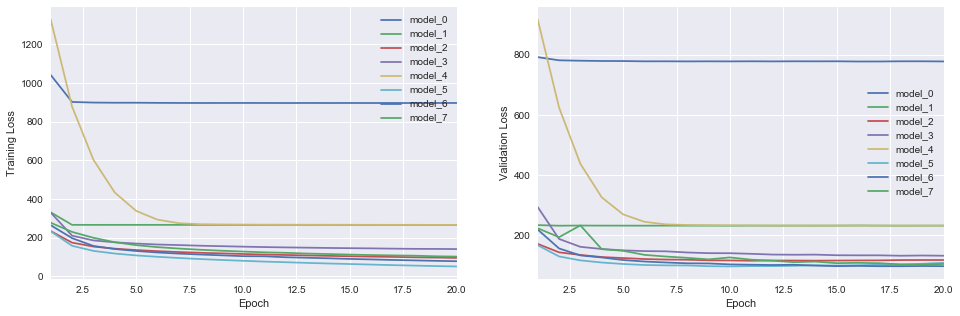

In [17]:
labels = {
          'model_0':'RNN', 
          'model_1':'RNN+TDD', 
          'model_2':'CNN+RNN+TDD',
          'model_3':'DeepRNN+TDD',
          'model_4':'BRNN+TDD',
          'model_5':'CNN+D-BRNN+TDD', 
          'model_6':'CNN+D-BRNN+TDD Drop', 
          'model_7':'DCNND-BRNN+TDD', 
          'model_final':'Final Keras Model'
         }

# Load saved model pickles
all_pickles = sorted(glob("results/*.pickle"))
# Extract model names
model_names = [item[8:-7] for item in all_pickles]
# Extract loss history
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# Identify number of epochs each model ran for
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# Plot the training loss vs. epochs
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# Plot the validation loss vs. epochs
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

<a id='test'></a>
### Final Model Performance

Language modeling, the component of a speech recognition system that estimates the prior probabilities of spoken sounds, is the system's knowledge of what probable word sequences are. This system uses a class based language model, which allows it to narrow down its search field through the vocabulary of the speech recognizer (the first part of the system) as it will rarely see a sentence that looks like "the dog the ate sand the water" so it will assume that 'the' is not likely to come after the word 'sand'. We do this by assigning a probability to every possible sentence and then picking the word with the highest prior probability of occurring. Language model smoothing (often called discounting) will help us overcome the problem that this creates a model that will assign a probability of 0 to anything it hasn't witnessed in training. This is done by distributing non zero probabilities over all possible occurences in proportion to the unigram probabilities of words. This overcomes the limitations of traditional n-gram based modeling and is all made possible by the added dimension of time sequences in the recurrent neural network.

The best performing model is considered the one that gives the highest probabilities to the words that are actually found in a test set, since it wastes less probability on words that actually occur.

More information on comparing models can be found in this [paper](resources/comparingmodels.pdf).

In [ ]:
def vis_audio_features(index, partition):
# Function for visualizing a single audio file based on index chosen
    if partition == 'validation':
        audio_gen = AudioGenerator(spectrogram=True)
        audio_gen.load_validation_data()
        vis_audio_path = audio_gen.valid_audio_paths[index]
        vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
        audio_gen = AudioGenerator(spectrogram=False)
        audio_gen.load_validation_data()
        vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
        vis_text = audio_gen.valid_texts[index]
        vis_raw_audio, _ = librosa.load(vis_audio_path)
        return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path
    
    elif partition == 'test':
        audio_gen.load_test_data()
        vis_audio_path = audio_gen.test_audio_paths[index]
        vis_audio_path = audio_gen.valid_audio_paths[index]
        vis_spectrogram_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
        audio_gen = AudioGenerator(spectrogram=False)
        audio_gen.load_test_data()
        vis_mfcc_feature = audio_gen.normalize(audio_gen.featurize(vis_audio_path))
        vis_text = audio_gen.test_texts[index]
        vis_raw_audio, _ = librosa.load(vis_audio_path)
        return vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path
    else:
        raise Exception('Invalid partition!  Must be "test", or "validation"')

In [18]:
def get_predictions(index, partition, input_to_softmax, model_path):
    # Load the train and test data
    data_gen = AudioGenerator(spectrogram = spectrogram)
    data_gen.load_train_data()
    data_gen.load_validation_data()
    data_gen.load_test_data()
    # Obtain ground truth transcriptions and audio features 
    if partition == 'validation':
        transcription = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'test':
        transcription = data_gen.test_texts[index]
        audio_path = data_gen.test_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train", "test", or "validation"')     
    # Obtain predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    # Play audio, display ground truth transcription and predicted transcripted.
    print('-'*80)
    print('True transcription:\n' + '\n' + transcription)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_seq_to_text(pred_ints)))
    print('-'*80)
    print(int_seq_to_text(pred_ints))

In [26]:
get_predictions(index=2012, 
                partition='validation',
                input_to_softmax=model_6, 
                model_path='./results/model_6.h5')

--------------------------------------------------------------------------------
True transcription:

then saw i many broken hinted sights in the uncertain state i stepp'd into
--------------------------------------------------------------------------------
Predicted transcription:

than so e many brok con hinte csits and uncern ste astup in to
--------------------------------------------------------------------------------
['t', 'h', 'a', 'n', ' ', 's', 'o', ' ', 'e', ' ', 'm', 'a', 'n', 'y', ' ', 'b', 'r', 'o', 'k', ' ', 'c', 'o', 'n', ' ', 'h', 'i', 'n', 't', 'e', ' ', 'c', 's', 'i', 't', 's', ' ', 'a', 'n', 'd', ' ', 'u', 'n', 'c', 'e', 'r', 'n', ' ', 's', 't', 'e', ' ', 'a', 's', 't', 'u', 'p', ' ', 'i', 'n', ' ', 't', 'o']


In [ ]:
# Display selected validation instance
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_audio_features(index=2012, 
    partition='validation')
# Plot the raw audio file
plot_raw_audio(vis_raw_audio)
# Printing the length of the audio file
display(Markdown('**Shape of the Audio File** : ' + str(vis_raw_audio.shape)))
# Playing the raw audio file
Audio(vis_audio_path)

In [ ]:
get_predictions(index=2012, 
                partition='test',
                input_to_softmax=model_6, 
                model_path='./results/model_6.h5')

In [ ]:
# Display selected test instance
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_audio_features(index=2012, 
    partition='test')
# Plot the raw audio file
plot_raw_audio(vis_raw_audio)
# Printing the length of the audio file
display(Markdown('**Shape of the Audio File** : ' + str(vis_raw_audio.shape)))
# Playing the raw audio file
Audio(vis_audio_path)

In [ ]:
get_predictions(index=2012, 
                partition='train',
                input_to_softmax=model_6, 
                model_path='./results/model_6.h5')

In [ ]:
# Display selected train instance
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features(2012)
# Plot the raw audio file
plot_raw_audio(vis_raw_audio)
# Printing the length of the audio file
display(Markdown('**Shape of the Audio File** : ' + str(vis_raw_audio.shape)))
# Playing the raw audio file
Audio(vis_audio_path)

<a id='export'></a>
## Exporting The Model For Inference

In [ ]:
# Converting TensorFlow Model trained in Keras into a frozen TensorFlow graph (.pb)
keras.backend.get_session().run(tf.global_variables_initializer())

In [ ]:
# Importing model from snapshot with custom lambda based loss function
keras.losses.add_ctc_loss = add_ctc_loss(input_to_softmax=model_0)
#keras_model = keras.models.load_model('./results/model_0.h5', custom_objects = {'<lambda>': lambda y_true, y_pred: y_pred, })

In [ ]:
keras_model.summary()

In [ ]:
keras_model.output.name.split(':')[0]

In [ ]:
def convert_keras_to_pb(model_path, out_names, models_dir, model_filename):
    model = load_model(model_path, custom_objects = {'<lambda>': lambda y_true, y_pred: y_pred, })
    K.set_learning_phase(0)
    sess = K.get_session()
    saver = saver_lib.Saver(write_version=saver_pb2.SaverDef.V2)
    checkpoint_path = saver.save(sess, './saved_ckpt', global_step=0, latest_filename='checkpoint_state')
    graph_io.write_graph(sess.graph, '.', 'tmp.pb')
    freeze_graph.freeze_graph('./tmp.pb', '',
                              False, checkpoint_path, out_names,
                              "save/restore_all", "save/Const:0",
                              models_dir+model_filename, False, "")
    
convert_keras_to_pb('./results/model_0.h5', 'ctc_21/ExpandDims', 'results/', 'model_0_converted')